# CHIMERA RETRIEVAL

In [1]:
#!/usr/bin/env python
# coding: utf-8

from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math, os
from fm import *
import pdb
import numpy as np
import pickle
from matplotlib.pyplot import *

In [2]:
#output path--note this will be name of folder
#for multinest output and also the generated
#pickle 
outpath="/user/lmiller/CHIMERA_results/OUTPUT_Lauren_new/wasp62_tess_cc_two-limbs-cov_new"
if not os.path.exists(outpath): os.mkdir(outpath)  #creating folder to dump MultiNest output
    
with open('tess_bandwidth.txt', 'r') as data:
        tess_w = []
        tess_trans = []
        for line in data:
            p = line.split()
            tess_w.append(float(p[0])) 
            tess_trans.append(float(p[1]))

In [3]:
#load crosssections between wnomin and wnomax
xsects=xsects_HST(1500,27900) # 1500 cm-1 (6.66 um) to 28000 cm-1 (0.358 um)

/user/lmiller/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/lmiller/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cross-sections Loaded


In [4]:
# log-likelihood
first_factor = 2. * np.log(2. * np.pi)
def loglike(cube, ndim, nparams):
    
    Rp = 1.390 #Stassun et al. 2017, Exoplanet Archive #0.930#*x[4]# Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
    Rstar = 1.2142700 #TICv8, Exoplanet Archive #0.598   #Stellar Radius in Solar Radii
    M = 0.52 #Stassun et al. 2017, Exoplanet Archive #1.78    #Mass in Jupiter Masses
   
    #TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
    #Tirr= 2091 #1500#x[0]#544.54 #terminator **isothermal** temperature--if full redistribution this is equilibrium temp
    #logKir= -1.5  #TP profile IR opacity controlls the "vertical" location of the gradient
    #logg1= -0.7     #single channel Vis/IR opacity. Controls the delta T between deep T and TOA T
    Tint= 200.
    
    #Composition parameters---assumes "chemically consistnat model" described in Kreidberg et al. 2015
    #logMet= 0.0 #x[1]#1.5742E-2 #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1 used -1.01*log10(M)+0.6
    #logCtoO= -0.26#x[2]#-1.97  #log C-to-O ratio: log solar is -0.26
    logPQCarbon = -5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value
    logPQNitrogen = -5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  --ad hoc for chemical kinetics--reasonable assumption
    
    #A&M Cloud parameters--includes full multiple scattering (for realzz) in both reflected and emitted light
    #logKzz=7 #log Rayleigh Haze Amplitude (relative to H2)
    #fsed=3.0 #haze slope--4 is Rayeigh, 0 is "gray" or flat.  
    #logPbase=-1.0  #gray "large particle" cloud opacity (-35 - -25)
    #logCldVMR=-25.0 #cloud fraction
    
    #simple 'grey+rayleigh' parameters--non scattering--just pure extinction
    logKcld = -40
    logRayAmp = -30
    RaySlope = 0

    #unpacking parameters to retrieve
    Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1 = cube[0],cube[1],cube[2],cube[3],cube[4],cube[5],                                                                          cube[6],cube[7], cube[8], cube[9]

    Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2 = cube[10], cube[11], cube[12], cube[13], cube[14], cube[15]

    #print('Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1:')
    #print(Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1)
    #print('Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2:')
    #print(Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2)
    
    # Force hemispheres to have different Tirr:
    if Tirr > Tirr2:
        return -np.inf

    ##all values required by forward model go here--even if they are fixed. First, one hemisphere:
    x=np.array([Tirr, logKir,logg1, Tint,logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
    gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free
    #wlgrid_fake=np.append(wlgrid,np.array([0.9,1.0,1.2]))
    wlgrid_tess=np.array(tess_w)
    wlgrid_tess=wlgrid_tess/1000 #convert from nm to microns
    transmission=np.array(tess_trans)
    #print('This is the TESS wavelength grid:')
    print(wlgrid_tess)
    foo1 = fx_trans(x,wlgrid_tess,gas_scale,xsects)
    #print(foo1[0])
    #print('This is foo1[0]:')
    #print(foo1[0])
    #y_binned1 = foo1[0]
    y_binned1 = (np.nansum(foo1[0]*transmission))/(np.nansum(transmission))

    # Next, the other hemisphere:
    x2=np.array([Tirr2, logKir,logg1, Tint,logMet, logCtoO2, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz2, fsed2,logPbase2,logCldVMR2, logKcld, logRayAmp, RaySlope])
    gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.])
    #foo2 = fx_trans(x2,wlgrid_fake,gas_scale,xsects)
    foo2 = fx_trans(x2,wlgrid_tess,gas_scale,xsects)
    #y_binned2 = foo2[0]
    y_binned2 = (np.nansum(foo2[0]*transmission))/(np.nansum(transmission))
    print('y_binned1,y_binned2:')
    print(y_binned1,y_binned2)
    # To get the (log)-likelihood, account for the fact that y_meas_cl and y_meas_hl are correlated, so compute entire thing:
    loglikelihood = 0.
#     for i in range(ndatapoints):
        
#         # Compute Mahalanobis distance:
#         residual = [y_meas_cl[i] - y_binned1[i]*0.5, y_meas_hl[i] - y_binned2[i]*0.5]
#         M = inv_cov[i]
#         MD = (residual[0]**2 * M[0,0]) + residual[0] * residual[1] * (M[0,1] + M[1,0]) + (residual[1]**2 * M[1,1])

#         # Get log-like for current datapoint:
#         loglikelihood += -0.5 * (first_factor + log_abs_det[i] + MD)
    # Compute Mahalanobis distance:
    print('This is ybinned1*0.5:')
    print(y_binned1*0.5)
    print('This is ybinned2*0.5:')
    print(y_binned2*0.5)
    print('This is y_meas_cl:')
    print(y_meas_cl)
    print('This is y_meas_hl:')
    print(y_meas_hl)
    residual = [y_meas_cl - y_binned1*0.5, y_meas_hl - y_binned2*0.5]
    M = inv_cov[0]
    print('This is first index of inverse cov matrix:')
    print(M)
   # print('This is residual:')
    #print(residual)
    #print(np.shape(residual))
    #print('This is M:')
    #print(M)
    #print(np.shape(M))
    MD = (residual[0]**2 * M[0,0]) + residual[0] * residual[1] * (M[0,1] + M[1,0]) + (residual[1]**2 * M[1,1])
   

    # Get log-like for current datapoint:
    loglikelihood += -0.5 * (first_factor + log_abs_det + MD)

 
    # Add up the likelihoods of both limbs. First, cold limb:
    #loglikelihood = -0.5*np.sum((y_meas_cl-(y_binned1*0.5))**2/err_cl**2)
    # Now hot limb:
    #loglikelihood += -0.5*np.sum((y_meas_hl-(y_binned2*0.5))**2/err_hl**2)
    #y_binned = (y_binned1*0.5) + (y_binned2*0.5)
    #loglikelihood=-0.5*np.sum((y_meas-y_binned)**2/err**2)  #nothing fancy here
    print('loglikelihood:')
    print(loglikelihood)
    return loglikelihood

In [5]:

# prior transform

Tstar= 6391 #TICv8, Exoplanet Archive #Effective Temperature of the star in Kelvin
semiratio= 9.55 #Stassun et al. 2017, Exoplanet Archive #Ratio of semi-major axis to stellar radius
f=2/3 
Ab=0 #Bond albedo
    
#Tmin, Tmax = 1000., 2500.      # Tirr: 1000 - 25000
Tmin, Tmax = 1000., (Tstar)*((semiratio**(-1))**(1/2)) #Irradiation Temperature==Tmax
MHmin, MHmax = -2., 3.        # [M/H]: -2.0 - 3.0 (0.01x - 1000x) 
logCOmin, logCOmax = -2., 0.3  # log(C/O): -2 - 0.3 (0.01 to 2.0 )
logKZZmin, logKZZmax = 5., 11. # log(Kzz): 5 - 11 (1E5 - 1E11 cm2/s)
FSEDmin, FSEDmax = 0.5, 6.0
logPBASEmin, logPBASEmax = -6., 1.5 # logPbase: -6.0 - 1.5 (1 ubar - 30 bar)
logCldVMRmin, logCldVMRmax = -15., -2. # logCldVMR: -15 - -2
xRPmin, xRPmax = 0.5, 1.5 # xRp: 0.5 - 1.5 (multiplicative factor to "fiducial" 10 bar radius)
logKIRmin, logKIRmax = -3, 0.
logg1min, logg1max = -3., 0.

def prior(cube,ndim,nparams):
    #prior ranges...
    cube[0] = (Tmax - Tmin) * cube[0] + Tmin                             # Tirr: 400 - 1800
    cube[1] = (MHmax - MHmin)*cube[1] + MHmin                            # [M/H]: -2.0 - 3.0 (0.01x - 1000x)
    cube[2] = (logCOmax - logCOmin)*cube[2] + logCOmin                   # log(C/O): -2 - 0.3 (0.01 to 2.0 )
    cube[3] = (logKZZmax - logKZZmin)*cube[3] + logKZZmin                 # log(Kzz): 5 - 11 (1E5 - 1E11 cm2/s)
    cube[4] = (FSEDmax - FSEDmin)*cube[4] + FSEDmin                 # fsed: 0.5 - 6.0
    cube[5] = (logPBASEmax - logPBASEmin)*cube[5] + logPBASEmin                 # logPbase: -6.0 - 1.5 (1 ubar - 30 bar)
    cube[6] = (logCldVMRmax - logCldVMRmin)*cube[6] + logCldVMRmin                   # logCldVMR: -15 - -2
    cube[7] = (xRPmax - xRPmin)*cube[7] + xRPmin                   # xRp: 0.5 - 1.5 (multiplicative factor to "fiducial" 10 bar radius)
    cube[8] = (logKIRmax - logKIRmin)*cube[8] + logKIRmin
    cube[9] = (logg1max - logg1min)*cube[9] + logg1min
    # Second hemisphere:
    cube[10] = (Tmax - Tmin) * cube[10] + Tmin
    cube[11] = (logCOmax - logCOmin)*cube[11] + logCOmin
    cube[12] = (logKZZmax - logKZZmin)*cube[12] + logKZZmin
    cube[13] = (FSEDmax - FSEDmin)*cube[13] + FSEDmin
    cube[14] = (logPBASEmax - logPBASEmin)*cube[14] + logPBASEmin
    cube[15] = (logCldVMRmax - logCldVMRmin)*cube[15] + logCldVMRmin

#####loading in data##########
# Stitch orders:
#wlgrid1, cl_d1, cl_derr1, hl_d1, hl_derr1, cov1 = np.loadtxt('/home/lmiller/TSRC/final_run/WASP-62b.dat',unpack=True)
wlgrid1, hl_d1, hl_derr1, cl_d1, cl_derr1, cov1 = np.loadtxt('/home/lmiller/TSRC/final_run/WASP-62b_new.dat',unpack=True)
#wlgrid2, cl_d2, cl_derr2, hl_d2, hl_derr2, cov2 = np.loadtxt('limb_data_order2.dat',unpack=True)
#wlgrid = np.append(wlgrid1, wlgrid2)
#wlgrid = np.append(wlgrid1)
wlgrid = np.array([wlgrid1])
#cl_d = np.append(cl_d1, cl_d2)
#cl_d = np.append(cl_d1)
cl_d = np.array([cl_d1])
#cl_derr = np.append(cl_derr1, cl_derr2)
#cl_derr = np.append(cl_derr1)
cl_derr = np.array([cl_derr1])
#hl_d = np.append(hl_d1, hl_d2)
#hl_d = np.append(hl_d1)
hl_d = np.array([hl_d1])
#hl_derr = np.append(hl_derr1, hl_derr2)
#hl_derr = np.append(hl_derr1)
hl_derr = np.array([hl_derr1])
#covariances = np.append(cov1, cov2)
#covariances = np.append(cov1)
covariances = np.array([cov1])

# Convert:
y_meas_cl = cl_d*1e-6
err_cl = cl_derr*1e-6

y_meas_hl = hl_d*1e-6
err_hl = hl_derr*1e-6

covariances = covariances * 1e-12

idx = np.argsort(wlgrid)
wlgrid, y_meas_cl, err_cl, y_meas_hl, err_hl, covariances = wlgrid[idx], y_meas_cl[idx], err_cl[idx], y_meas_hl[idx], err_hl[idx], covariances[idx]

ndatapoints = len(idx)

# Get inverse covariance matrix for each datapoint along with the log of the absolute value of the determinant:
inv_cov = []
log_abs_det = []
for i in range(len(wlgrid)):
    current_matrix = np.zeros([2,2])
    current_matrix[0,0] = err_cl[i]**2
    current_matrix[1,1] = err_hl[i]**2
    current_matrix[0,1] = covariances[i]
    current_matrix[1,0] = covariances[i]
    inv_cov.append( np.linalg.inv(current_matrix) )
    log_abs_det.append( np.linalg.slogdet(current_matrix)[1] )

In [6]:
#wlgrid, y_meas, err=np.loadtxt('w43b_trans.txt').T
outname=outpath+'.pic'  #dynesty output file name (saved as a pickle)
Nparam=16  #number of parameters--make sure it is the same as what is in prior and loglike
Nlive=500 #number of nested sampling live points

#calling pymultinest
pymultinest.run(loglike, prior, Nparam, outputfiles_basename=outpath+'/template_',resume=True, verbose=True,n_live_points=Nlive, importance_nested_sampling=False)

#converting pymultinest output into pickle format (weighting sampling points by volumes to get "true" posterior)
a = pymultinest.Analyzer(n_params = Nparam, outputfiles_basename=outpath+'/template_')
s = a.get_stats()
output=a.get_equal_weighted_posterior()
pickle.dump(output,open(outname,"wb"))

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =   16
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                        0.113915
Replacements:                               4835
Total Samples:                             42444
Nested Sampling ln(Z):                  8.807780
  analysing data from /user/lmiller/CHIMERA_results/OUTPUT_Lauren_new/wasp62_tess_cc_two-limbs-cov_new/template_.txt ln(ev)=   9.0581684363473265      +/-  0.10623019669458686     
 Total Likelihood Evaluations:        42444
 Sampling finished. Exiting MultiNest



# PLOTTING

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import pickle
import pdb 
from fm import *
from scipy import interp
import pickle
import corner
import os
import juliet

/user/lmiller/miniconda3/envs/py38/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


In [8]:
plot_corner = True

# Extract samples:
pic=pickle.load(open('/user/lmiller/CHIMERA_results/OUTPUT_Lauren_new/wasp62_tess_cc_two-limbs-cov_new.pic','rb'), \
                encoding='latin1')
samples=pic[:,:-1]

    
with open('tess_bandwidth.txt', 'r') as data:
        tess_w = []
        tess_trans = []
        for line in data:
            p = line.split()
            tess_w.append(float(p[0])) 
            tess_trans.append(float(p[1]))

In [9]:
samples.shape

(2446, 16)

In [10]:
np.median(samples[:,7])

0.8911870746585299

In [11]:
np.mean(samples[:,7])

0.8929576170437425

(array([  4.,   8.,  44., 115., 305., 673., 532., 412., 245., 108.]),
 array([0.81527884, 0.8277041 , 0.84012935, 0.85255461, 0.86497987,
        0.87740512, 0.88983038, 0.90225563, 0.91468089, 0.92710614,
        0.9395314 ]),
 <BarContainer object of 10 artists>)

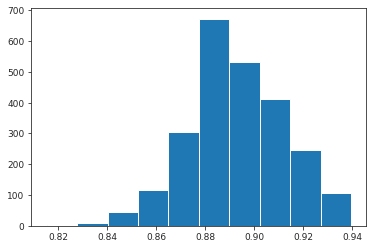

In [12]:
plt.hist(samples[:,7])

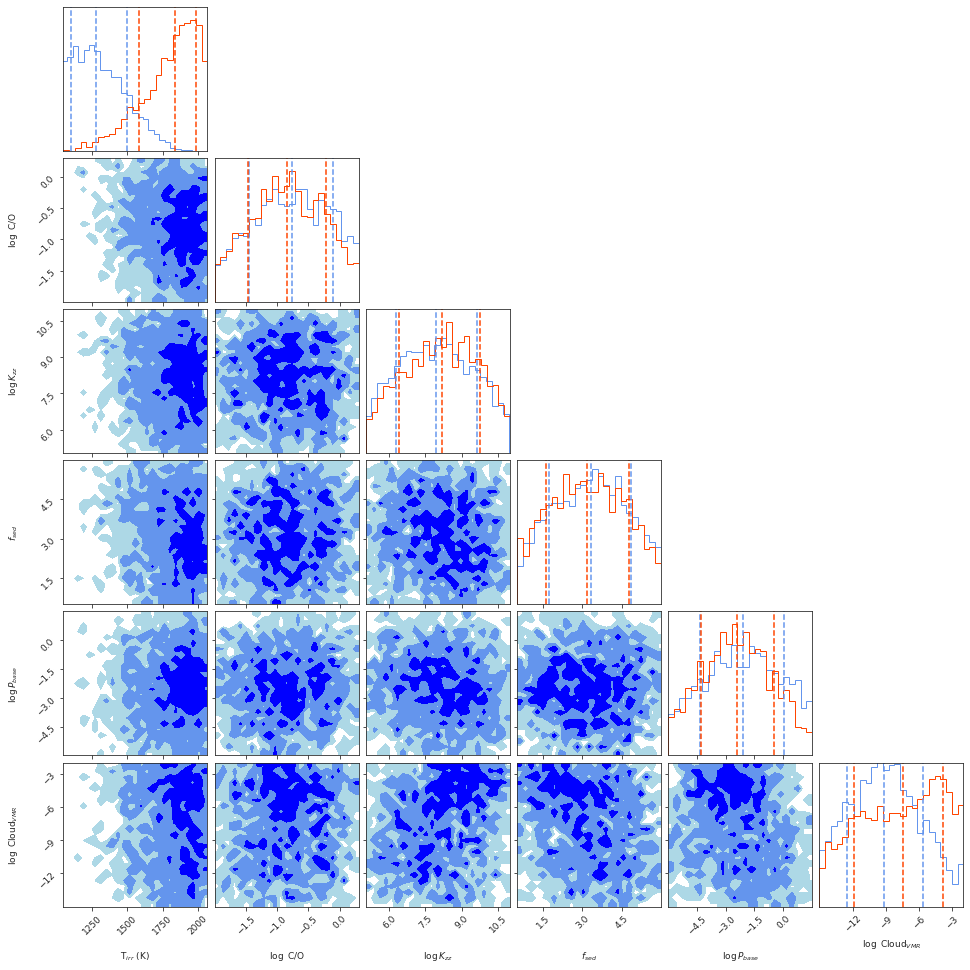

In [13]:
if plot_corner:
    # Samples has...all the samples. In our case, shape [nsamples, 16]. Let's 
    # extract the common properties of the limbs and plot them in a corner plot:

    # 0: Tirr, 2: log C/O, 3: logKzz, 4: fsed, 5: logPbase, 6:logCldVMR
    samples1 = samples[:, [0,2,3,4,5,6]]

    # 10: Tirr2, 11: log C/O_2, 12: logKzz2, 13: fsed2, 14: logPbase2, 15:logCldVMR2
    samples2 = samples[:, [10, 11, 12, 13, 14, 15]]

    # All right, let's put all this in its own corner plot:
    names = ['T$_{irr}$ (K)', '$\log$ C/O', '$\log K_{zz}$', '$f_{sed}$', '$\log P_{base}$', '$\log$ Cloud$_{VMR}$']
    figure = corner.corner(samples1, color = 'cornflowerblue', labels = names, plot_datapoints='False', plot_contours='False', bins=25, quantiles=[.16,0.5,.84], levels=(1.-np.exp(-(1)**2/2.),1.-np.exp(-(2)**2/2.),1.-np.exp(-(3)**2/2.)))
    corner.corner(samples2, fig = figure, color = 'orangered', plot_datapoints='False', plot_contours='False', bins=25, quantiles=[.16,0.5,.84], levels=(1.-np.exp(-(1)**2/2.),1.-np.exp(-(2)**2/2.),1.-np.exp(-(3)**2/2.)))
    plt.show()
    #plt.savefig('plot_comb_tess-cov_wasp62.png')

In [14]:
# Now plot models and spectra. First load cross sections:
if not os.path.exists('model_wavelengths_tess-limbs-cov_wasp62_test_new.npy'):
    xsects=xsects_HST(1500,27900) 

# Define function that will evaluate model and return model, depth1 and depth2 at a given set of wavelengths:
def gen_model(cube, wavelengths):

    wlgrid = wavelengths
    
    Rp = 1.390 #Stassun et al. 2017, Exoplanet Archive #0.930#*x[4]# Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
    Rstar = 1.2142700 #TICv8, Exoplanet Archive #0.598   #Stellar Radius in Solar Radii
    M = 0.52 #Stassun et al. 2017, Exoplanet Archive #1.78    #Mass in Jupiter Masses

    #TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
    #Tirr= 2091 #1500#x[0]#544.54 #terminator **isothermal** temperature--if full redistribution this is equilibrium temp
    #logKir= -1.5  #TP profile IR opacity controlls the "vertical" location of the gradient
    #logg1= -0.7     #single channel Vis/IR opacity. Controls the delta T between deep T and TOA T
    Tint= 200.

    #Composition parameters---assumes "chemically consistnat model" described in Kreidberg et al. 2015
    #logMet= 0.0 #x[1]#1.5742E-2 #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1 used -1.01*log10(M)+0.6
    #logCtoO= -0.26#x[2]#-1.97  #log C-to-O ratio: log solar is -0.26
    logPQCarbon = -5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value
    logPQNitrogen = -5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  --ad hoc for chemical kinetics--reasonable assumption

    #A&M Cloud parameters--includes full multiple scattering (for realzz) in both reflected and emitted light
    #logKzz=7 #log Rayleigh Haze Amplitude (relative to H2)
    #fsed=3.0 #haze slope--4 is Rayeigh, 0 is "gray" or flat.  
    #logPbase=-1.0  #gray "large particle" cloud opacity (-35 - -25)
    #logCldVMR=-25.0 #cloud fraction

    #simple 'grey+rayleigh' parameters--non scattering--just pure extinction
    logKcld = -40
    logRayAmp = -30
    RaySlope = 0

    #unpacking parameters to retrieve
    Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1 = cube[0],cube[1],cube[2],cube[3],cube[4],cube[5],\
                                                                          cube[6],cube[7], cube[8], cube[9]

    Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2 = cube[10], cube[11], cube[12], cube[13], cube[14], cube[15]

    # Force hemispheres to have different Tirr:
    if Tirr > Tirr2:
        return -np.inf

    ##all values required by forward model go here--even if they are fixed. First, one hemisphere:
    x=np.array([Tirr, logKir,logg1, Tint,logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
    gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free
    foo1 = fx_trans(x,wlgrid,gas_scale,xsects)
    y_binned1 = foo1[0]

    # Next, the other hemisphere:
    x2=np.array([Tirr2, logKir,logg1, Tint,logMet, logCtoO2, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz2, fsed2,logPbase2,logCldVMR2, logKcld, logRayAmp, RaySlope])
    gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.])
    foo2 = fx_trans(x2,wlgrid,gas_scale,xsects)
    y_binned2 = foo2[0]

    y_binned = (y_binned1*0.5) + (y_binned2*0.5)
    
    print(y_binned)
    print(y_binned1*0.5)
    print(y_binned2*0.5)

    return y_binned, y_binned1*0.5, y_binned2*0.5


Cross-sections Loaded


In [16]:
# Load dataset:
"""
wlgrid1, d1, derr1 = np.loadtxt('combined_data_order1.dat',unpack=True)
wlgrid2, d2, derr2 = np.loadtxt('combined_data_order2.dat',unpack=True)
wlgrid = np.append(wlgrid1, wlgrid2)
d = np.append(d1, d2) 
derr = np.append(derr1, derr2)

# Convert:
y_meas = d*1e-6
err = derr*1e-6
idx = np.argsort(wlgrid)
wavelengths, depths, errors = wlgrid[idx], y_meas[idx], err[idx]
"""
#wlgrid1, cl_d1, cl_derr1, hl_d1, hl_derr1,cov1 = np.loadtxt('/home/lmiller/TSRC/final_run/WASP-62b.dat',unpack=True)
wlgrid1, hl_d1, hl_derr1, cl_d1, cl_derr1,cov1 = np.loadtxt('/home/lmiller/TSRC/final_run/WASP-62b_new.dat',unpack=True)
#wlgrid2, cl_d2, cl_derr2, hl_d2, hl_derr2,cov2 = np.loadtxt('limb_data_order2.dat',unpack=True)
#wlgrid = np.append(wlgrid1, wlgrid2) 
wlgrid = np.array([wlgrid1]) 
#cl_d = np.append(cl_d1, cl_d2)
cl_d = np.array([cl_d1])
#cl_derr = np.append(cl_derr1, cl_derr2)
cl_derr = np.array([cl_derr1])
#hl_d = np.append(hl_d1, hl_d2)
hl_d = np.array([hl_d1])
#hl_derr = np.append(hl_derr1, hl_derr2)
hl_derr = np.array([hl_derr1])

# Convert:
y_meas_cl = cl_d
err_cl = cl_derr

y_meas_hl = hl_d
err_hl = hl_derr

idx = np.argsort(wlgrid)
wavelengths, depths_cl, errors_cl, depths_hl, errors_hl = wlgrid[idx], y_meas_cl[idx], err_cl[idx], y_meas_hl[idx], err_hl[idx]



In [17]:
# If not already done, sample using samples. If already done, just load results:
if os.path.exists('model_wavelengths_tess-limbs-cov_wasp62_test_new.npy'):

    model_samples = np.load('model_samples_tess-limbs-cov_wasp62_tes_new.npy')
    depth1_samples = np.load('model_depth1_samples_tess-limbs-cov_wasp62_test_new.npy')
    depth2_samples = np.load('model_depth2_samples_tess-limbs-cov_wasp62_test_new.npy')
    wavelengths_model = np.load('model_wavelengths_tess-limbs-cov_wasp62_test_new.npy')

else:
    # Define model wavelengths (ie waelengths at which we'll evaluate model). Here, upper limit is 3 microns because 
    # we want to evaluate up to SOSS wavelengths:   0.36
    #wavelengths_model = np.linspace(np.min(wavelengths), 3.0, 300) 
    wavelengths_model = np.linspace(0.6, 3.0, 264) 

    # Now random sample from the samples, and evaluate model at those random samples:
    nsamples, ndimensions = samples.shape
    nevaluations = 200 # evaluate at 200 random samples
    idx = np.random.choice(np.arange(nsamples),replace=False,size=nevaluations)

    counter = 0
    # Define arrays that will save results:
    model_samples, depth1_samples, depth2_samples = np.zeros([nevaluations, len(wavelengths_model)]), \
                                                    np.zeros([nevaluations, len(wavelengths_model)]), \
                                                    np.zeros([nevaluations, len(wavelengths_model)])

    # Sample and evaluate model:
    #print('This is idx:')
    #print(idx)
    for i in idx:
        #print(counter)
        #print('This is i:')
        #print(i)
        model_samples[counter, :], depth1_samples[counter, :], depth2_samples[counter, :] = gen_model(samples[i,:], wavelengths_model)
        counter += 1

    # Find nans, correct samples, save:
    idx = np.where(~np.isnan(model_samples[0,:]))[0]
    
    model_samples = model_samples[:,idx]
    depth1_samples = depth1_samples[:,idx]
    depth2_samples = depth2_samples[:,idx]
    wavelengths_model = wavelengths_model[idx]

    np.save('model_wavelengths_tess-limbs-cov_wasp62_test_new.npy', wavelengths_model)
    np.save('model_depth1_samples_tess-limbs-cov_wasp62_test_new.npy', depth1_samples)
    np.save('model_depth2_samples_tess-limbs-cov_wasp62_test_new.npy', depth2_samples)
    np.save('model_samples_tess-limbs-cov_wasp62_test_new.npy', model_samples)


[0.0123703  0.01235953 0.01234956 0.01234062 0.01233189 0.01232424
 0.01231614 0.01230814 0.01230049 0.01229304 0.01229006 0.01228241
 0.01227816 0.01228406 0.0122813  0.01227493 0.0122708  0.01226689
 0.01225706 0.01224956 0.01224496 0.0122396  0.01224031 0.01226725
 0.01226169 0.01225653 0.01225498 0.0122577  0.01224926 0.01224117
 0.01224211 0.01223758 0.01225945 0.01226027 0.01225548 0.01226916
 0.01235367 0.01239403 0.01238359 0.01238345 0.0123972  0.01240998
 0.01240287 0.01237833 0.01236359 0.01235286 0.01234695 0.01233018
 0.01231107 0.01230149 0.01229457 0.01228985 0.01228276 0.01228365
 0.01236632 0.01243707 0.01247531 0.01248476 0.01249995 0.01250707
 0.01250715 0.01251018 0.01251175 0.01250705 0.01249489 0.01247989
 0.01246329 0.01244156 0.01242815 0.01241522 0.01240131 0.012387
 0.01238085 0.01238206 0.01237766 0.01238045 0.01237933 0.01239305
 0.01241099 0.01242601 0.01252719 0.01273078 0.0127804  0.01279816
 0.01279289 0.01278798 0.01278463 0.0127977  0.01281191 0.012840

[0.01245743 0.01241627 0.01239053 0.01237173 0.01235533 0.01234259
 0.01232931 0.0123162  0.01230365 0.01229614 0.0123072  0.01230941
 0.01231073 0.0123266  0.01233119 0.01233518 0.01234131 0.01235412
 0.01247465 0.0124369  0.01234089 0.01232033 0.01230566 0.01231852
 0.01230754 0.01229695 0.01228822 0.01227666 0.01225727 0.01224268
 0.01223343 0.01222517 0.01225941 0.01226773 0.01225519 0.012284
 0.01236305 0.01240525 0.01238958 0.01238838 0.0123865  0.01238083
 0.01236795 0.01233983 0.0123164  0.01229401 0.01227424 0.01225063
 0.01222676 0.01221846 0.01220934 0.01220829 0.01221194 0.01221977
 0.01231376 0.01238493 0.01242055 0.01243701 0.0124444  0.01243748
 0.01243233 0.01243572 0.01243988 0.01242624 0.01240649 0.01237887
 0.01235632 0.01233283 0.01231658 0.01229917 0.01228016 0.01226495
 0.01225432 0.01225897 0.01226672 0.01227785 0.01228894 0.01230543
 0.01232416 0.01233799 0.01243287 0.01260613 0.01265867 0.01267986
 0.01267211 0.01267046 0.0126647  0.01266713 0.01268055 0.012704

[0.01246401 0.01240505 0.0123672  0.01234036 0.01231646 0.0123041
 0.01228419 0.01226108 0.01223652 0.01222381 0.01226357 0.01227081
 0.01228341 0.01233338 0.01234118 0.01234074 0.01234088 0.01235032
 0.01248835 0.01244468 0.01232876 0.01230147 0.01229334 0.0123379
 0.01232161 0.01230593 0.01229192 0.01227067 0.01223311 0.01220347
 0.01218889 0.01217375 0.01224367 0.0122779  0.01226667 0.01232455
 0.01242382 0.0124926  0.01247393 0.01247066 0.0124631  0.01245661
 0.01244063 0.01240554 0.01237169 0.01233655 0.01230409 0.01227012
 0.01223454 0.01222787 0.01221301 0.01221383 0.01222238 0.01223719
 0.01236617 0.01244642 0.01247899 0.01250481 0.01251523 0.01250888
 0.01250015 0.01250476 0.01250966 0.01249043 0.01247263 0.01243466
 0.01240735 0.01237984 0.01235981 0.01233799 0.01231368 0.01229205
 0.01227789 0.01228391 0.01229812 0.01231107 0.01232368 0.01235439
 0.01237846 0.01239388 0.01248846 0.01264175 0.01268885 0.01271187
 0.01271152 0.01271627 0.01270473 0.01270556 0.01271554 0.012737

[0.01243057 0.01235533 0.01239621 0.01237563 0.0123316  0.01231483
 0.01228962 0.01230361 0.01232251 0.01229574 0.01228374 0.01224929
 0.0123388  0.01238573 0.01233483 0.01227266 0.012232   0.01223295
 0.01242261 0.01239662 0.01229386 0.0122582  0.01225284 0.01230061
 0.01227282 0.01227374 0.01226722 0.01229087 0.01226622 0.01223724
 0.01221789 0.01218473 0.01226132 0.01226393 0.01223233 0.01227982
 0.01242069 0.01248588 0.0124628  0.01246101 0.01246326 0.01246021
 0.01244158 0.01240386 0.01237147 0.01233415 0.01231007 0.01227851
 0.01223683 0.01224048 0.01224719 0.01222933 0.01220412 0.01220555
 0.012354   0.01245195 0.01249302 0.01251566 0.01253163 0.01253425
 0.01253108 0.01253596 0.0125385  0.01252657 0.01251078 0.0124767
 0.01244697 0.01241314 0.01239011 0.01236419 0.0123359  0.01231136
 0.01229619 0.01230064 0.01230265 0.01231089 0.01231619 0.01234837
 0.0123787  0.01240198 0.01252643 0.01273466 0.01278996 0.01281574
 0.01282002 0.01282371 0.01281287 0.01282007 0.01283319 0.01286

[0.01258561 0.0124178  0.01260996 0.01257472 0.01246039 0.01241654
 0.01236174 0.01244688 0.01256234 0.01248848 0.01236471 0.01223645
 0.01253652 0.01259051 0.01238402 0.01216921 0.01204283 0.01204865
 0.01241245 0.01244811 0.01230931 0.01222729 0.01215614 0.01213462
 0.01211846 0.01217824 0.01218443 0.01231073 0.01226634 0.01216027
 0.01208655 0.01203948 0.01219317 0.0121372  0.01205539 0.01208275
 0.01230012 0.01233216 0.01227918 0.01225365 0.01224454 0.01225046
 0.01223211 0.01218208 0.0121569  0.0121151  0.01210845 0.01207557
 0.01202792 0.01203608 0.01205776 0.01202579 0.01197915 0.01196931
 0.0121129  0.01222737 0.01227391 0.0122883  0.01229755 0.01230188
 0.01229974 0.01230342 0.01230556 0.01229954 0.01228782 0.01225596
 0.01222394 0.01218638 0.01216186 0.01213459 0.01210509 0.01209168
 0.01207801 0.01208053 0.01207749 0.01207977 0.01208019 0.0121089
 0.01213928 0.01216526 0.01229993 0.01253328 0.01259007 0.01261603
 0.01262048 0.0126244  0.01261348 0.01262737 0.01263959 0.01267

[0.01259654 0.01239764 0.01261863 0.01258947 0.01245874 0.01240477
 0.01233928 0.01243988 0.01255179 0.01246955 0.01233677 0.01218693
 0.01252119 0.01259637 0.01237274 0.01214479 0.01205107 0.01206064
 0.01243914 0.01245097 0.01227933 0.0121797  0.01212288 0.01216826
 0.01214155 0.01216876 0.01216384 0.01229765 0.01223964 0.01214082
 0.01209461 0.012053   0.01218911 0.01214494 0.01208159 0.0121396
 0.0123428  0.01240658 0.01237046 0.01236007 0.01236734 0.01237419
 0.01235582 0.01231057 0.01227919 0.0122381  0.01221246 0.01217248
 0.01212055 0.01212662 0.01213865 0.01211333 0.01207823 0.01207863
 0.0122533  0.01236448 0.01241144 0.01243003 0.01244853 0.01245768
 0.01245738 0.01246248 0.01246431 0.01245668 0.01244188 0.01240916
 0.01237681 0.01233808 0.0123121  0.01228211 0.01224921 0.01221955
 0.01220199 0.0122063  0.01220341 0.01220944 0.01221167 0.01224961
 0.01228492 0.01231493 0.01245594 0.01269464 0.01275051 0.01277487
 0.01278236 0.012788   0.01277598 0.01279034 0.01280216 0.01283

[0.01254424 0.0124143  0.01255792 0.01253665 0.01244967 0.01241095
 0.01236504 0.01243378 0.0125101  0.0124543  0.01236128 0.01224345
 0.01248789 0.01254132 0.01238274 0.01218779 0.01208619 0.01209586
 0.0124161  0.01243751 0.01231867 0.01223947 0.01216809 0.01217542
 0.01216092 0.01219911 0.01219932 0.01230423 0.01225882 0.01215547
 0.01210004 0.01206062 0.01219998 0.01216376 0.01210405 0.0121519
 0.01232799 0.01237581 0.01233992 0.01232443 0.01232346 0.0123312
 0.01231753 0.01228309 0.01225542 0.01221832 0.01219621 0.01216077
 0.01211493 0.01211132 0.01211172 0.01209568 0.01207557 0.01208129
 0.01222795 0.01232384 0.01236239 0.01238012 0.0123932  0.01239845
 0.0123959  0.01240005 0.01240224 0.01239223 0.01237883 0.01234895
 0.01232233 0.01229092 0.01226958 0.0122448  0.01221757 0.01219448
 0.01217871 0.01218223 0.01218301 0.01218936 0.01219323 0.0122258
 0.01225486 0.01227823 0.01239226 0.01258392 0.01262895 0.01265137
 0.01265634 0.01266144 0.01265095 0.01266154 0.01267114 0.0126986

[0.01235257 0.01228894 0.01226367 0.01224705 0.01222892 0.01223397
 0.01222438 0.01222198 0.01222228 0.01220995 0.01224112 0.01222673
 0.01226348 0.01233125 0.01232698 0.01230825 0.01229636 0.01229181
 0.0124115  0.01235773 0.01225474 0.01223805 0.01225995 0.01235567
 0.01234113 0.01233299 0.01232745 0.01232708 0.01230356 0.0122809
 0.01227202 0.01225538 0.01232486 0.0123483  0.01233406 0.01238944
 0.01249718 0.01256747 0.01255514 0.0125494  0.01255207 0.01255789
 0.0125478  0.01251564 0.01249036 0.01246266 0.01243936 0.01240899
 0.01237466 0.01236211 0.01234785 0.01234334 0.01234195 0.01235207
 0.01248123 0.01255488 0.01258526 0.01260243 0.01261661 0.01262054
 0.01261899 0.01262265 0.01262475 0.01261481 0.01260086 0.0125759
 0.01255298 0.01252769 0.01250988 0.01248923 0.01246645 0.0124438
 0.0124328  0.01243696 0.01243912 0.01244593 0.01245029 0.01247571
 0.01250056 0.01251998 0.01261263 0.0127629  0.0128001  0.01281748
 0.01282428 0.01283114 0.01281937 0.01282615 0.01283448 0.0128574

[0.01247299 0.01235533 0.01247005 0.01245436 0.01238051 0.01235117
 0.012314   0.01237195 0.01243213 0.01238593 0.01231824 0.01222365
 0.01241885 0.01247637 0.01235272 0.01221201 0.01215487 0.01216119
 0.01239906 0.01239743 0.01228478 0.01222213 0.01218864 0.01223491
 0.01222031 0.01223747 0.01223642 0.01231781 0.01228329 0.01221741
 0.0121881  0.01215982 0.01225389 0.01223119 0.01219265 0.01223358
 0.01236519 0.01241296 0.01239275 0.01238351 0.01239014 0.01240039
 0.0123916  0.01236752 0.01234827 0.01232266 0.01230797 0.01228193
 0.0122463  0.01224023 0.01223923 0.0122244  0.01220495 0.01220799
 0.01232708 0.01239869 0.01242828 0.01243948 0.01245273 0.01246178
 0.01246345 0.01246638 0.01246666 0.01246305 0.01245444 0.01243655
 0.01241765 0.01239395 0.01237819 0.01235914 0.01233822 0.01231817
 0.01230694 0.01230887 0.01230331 0.01230562 0.01230436 0.01232961
 0.01235281 0.01237321 0.01246317 0.01261411 0.01264633 0.012662
 0.01266891 0.01267329 0.01266505 0.01267586 0.01268301 0.012704

[0.01237417 0.01233834 0.01232069 0.01230919 0.01229744 0.01229352
 0.01228513 0.01228235 0.01228101 0.01227318 0.01227987 0.01227373
 0.01229351 0.01231445 0.01230632 0.01229706 0.01229809 0.01230611
 0.01240003 0.0123689  0.01229591 0.01228189 0.01228548 0.01231734
 0.01230806 0.01229904 0.01229224 0.01229453 0.01229125 0.01228952
 0.01229713 0.01228686 0.0123011  0.01230099 0.01228791 0.01229005
 0.01232173 0.01234532 0.01234662 0.01235595 0.01236092 0.0123557
 0.0123421  0.0123388  0.01232234 0.0123004  0.01229513 0.0122925
 0.01228142 0.01229571 0.01230639 0.01230187 0.01228714 0.01227957
 0.01229936 0.01231233 0.01231482 0.01231159 0.01230444 0.01231891
 0.01229906 0.01229577 0.01231505 0.01234512 0.01235292 0.01234597
 0.01233557 0.01231467 0.01229468 0.01227417 0.01226051 0.01227811
 0.01226248 0.01225275 0.0122508  0.01224964 0.01225218 0.01225835
 0.01225528 0.01226236 0.0123021  0.01235866 0.0123699  0.01236802
 0.01236314 0.01235419 0.01234419 0.01234228 0.0123422  0.012347

[0.01262659 0.01246419 0.01265396 0.01261943 0.01250524 0.01245702
 0.01240065 0.01247843 0.01258818 0.01251452 0.01239058 0.01226549
 0.01255998 0.01260307 0.01239853 0.0121739  0.01201995 0.01203402
 0.01244493 0.01248887 0.01234996 0.01226369 0.01218693 0.01214303
 0.01210367 0.01216346 0.01216664 0.01229047 0.01225325 0.01216005
 0.01208732 0.0120289  0.01216082 0.01208747 0.01197606 0.01198588
 0.01224217 0.01226733 0.01220478 0.0121874  0.01218092 0.01216575
 0.01212495 0.01204814 0.01201585 0.01195864 0.01196497 0.01192458
 0.01186692 0.01192662 0.01199585 0.01194414 0.0118543  0.01181778
 0.01195089 0.01207769 0.01213147 0.01214    0.01213679 0.01213503
 0.01212753 0.01212998 0.0121368  0.01215364 0.01215824 0.01211833
 0.01206754 0.01201221 0.01197304 0.01193443 0.01189509 0.01189419
 0.01187671 0.01187904 0.01187982 0.01187902 0.0118807  0.01191103
 0.01194411 0.01197407 0.01212813 0.01239029 0.01245279 0.01247633
 0.01247608 0.0124776  0.012469   0.01248265 0.01249619 0.0125

[0.01256563 0.0124889  0.01243877 0.01240108 0.01236746 0.01234078
 0.01231251 0.01228371 0.01225585 0.01224057 0.01226617 0.01227723
 0.01228154 0.01230734 0.01232106 0.01233609 0.01235553 0.01238765
 0.01258682 0.01253405 0.01236719 0.01232423 0.01229049 0.01229202
 0.01227152 0.012247   0.0122298  0.01220732 0.01217438 0.01214984
 0.01214758 0.01213184 0.01217324 0.01218536 0.01217057 0.01219108
 0.01224398 0.01228798 0.0122684  0.01226252 0.01225696 0.01225507
 0.01224568 0.01226627 0.01224366 0.01221087 0.01219273 0.01217292
 0.01214793 0.01213351 0.01211979 0.01212013 0.01211988 0.01212844
 0.01220183 0.01226747 0.01230305 0.0123273  0.01233357 0.01236369
 0.01236182 0.01238164 0.01236696 0.01238332 0.01233155 0.01228177
 0.01226474 0.01222327 0.01219323 0.01215841 0.01214681 0.01216659
 0.01213777 0.01212131 0.0121233  0.01214757 0.01218132 0.01221711
 0.01224602 0.01227151 0.012359   0.01247556 0.01251483 0.01255596
 0.01256046 0.01256283 0.01256839 0.01257272 0.01257989 0.0125

[0.01237499 0.01233503 0.01230992 0.01229492 0.01228149 0.0122841
 0.01227383 0.01225792 0.0122404  0.01222994 0.01227251 0.01227662
 0.0122925  0.01234412 0.01234735 0.0123391  0.01233128 0.01232643
 0.01240166 0.01236697 0.01229862 0.01228663 0.01229932 0.01235786
 0.01234893 0.01234068 0.01233458 0.01232493 0.0123     0.01227642
 0.01226347 0.01224951 0.0123077  0.01233765 0.01233082 0.01237549
 0.01244649 0.01249423 0.01248468 0.01248127 0.01247968 0.01248057
 0.01247237 0.0124495  0.01242974 0.01240796 0.01238699 0.01236217
 0.01233558 0.0123281  0.01231458 0.01231362 0.0123175  0.01232847
 0.01242232 0.01247388 0.01249433 0.01250825 0.01251683 0.01251767
 0.01251431 0.01251706 0.01251908 0.01251021 0.01250035 0.01247972
 0.01246269 0.0124447  0.012431   0.01241569 0.01239856 0.01238116
 0.01237072 0.01237386 0.01237887 0.01238505 0.01239007 0.0124107
 0.0124295  0.01244247 0.01250531 0.01260334 0.01262813 0.01264058
 0.01264484 0.01265022 0.01264136 0.01264473 0.01265018 0.012664

[0.01246591 0.01242894 0.01240565 0.01238828 0.01237375 0.01236137
 0.01234947 0.01233796 0.01232723 0.01231693 0.01231014 0.01230197
 0.01229578 0.01229586 0.01228938 0.01228267 0.01227539 0.01226804
 0.01225896 0.01225084 0.01224482 0.01223979 0.01223729 0.01225466
 0.01226725 0.01224262 0.0122378  0.01223417 0.01222304 0.01221249
 0.01220604 0.01220111 0.0122253  0.0122266  0.01221602 0.01223442
 0.01230052 0.01233228 0.01232272 0.01232164 0.01232588 0.01232866
 0.01232136 0.01230193 0.01228836 0.01227638 0.01226719 0.01225265
 0.01223755 0.01223078 0.01222602 0.01222399 0.0122233  0.01222589
 0.01229068 0.01234016 0.01236613 0.01237541 0.01238207 0.01238541
 0.01238072 0.01238337 0.01238588 0.01237877 0.0123692  0.01235519
 0.01234295 0.01232804 0.01231868 0.01230748 0.01229569 0.01228491
 0.01227932 0.01228144 0.01228118 0.01228543 0.01228849 0.01229912
 0.01231228 0.01232329 0.01238691 0.01251216 0.01254539 0.01255419
 0.01254459 0.0125397  0.01254253 0.01254659 0.01255479 0.0125

[0.01253526 0.01249887 0.01247346 0.0124528  0.01243325 0.01241517
 0.01239653 0.01237739 0.01235782 0.01233876 0.01232725 0.01230829
 0.01229346 0.01229431 0.01227943 0.01226091 0.01224134 0.01222021
 0.01219444 0.01217113 0.0121545  0.01213903 0.01213611 0.01218376
 0.0121889  0.01215255 0.01213861 0.01212722 0.0120967  0.01207117
 0.01206762 0.01204978 0.01209791 0.01210582 0.01208821 0.01212171
 0.01222514 0.01228541 0.012266   0.01225927 0.01225969 0.0122597
 0.01224427 0.01220603 0.01217556 0.01214651 0.01212299 0.01208972
 0.01205408 0.01203634 0.01202134 0.01201457 0.01200938 0.01201475
 0.01214531 0.0122342  0.01227562 0.01229389 0.01230533 0.01230682
 0.0123007  0.01230404 0.0123046  0.01229147 0.01227024 0.0122387
 0.01221123 0.01217909 0.01215765 0.01213304 0.01210593 0.0120797
 0.01206702 0.0120707  0.0120715  0.01208059 0.01208757 0.01211205
 0.01213846 0.01215923 0.01228029 0.01249479 0.01255176 0.01257287
 0.01256561 0.0125622  0.01255855 0.01256561 0.01257804 0.0126028

[0.01260343 0.01242712 0.01261386 0.01258103 0.0124571  0.01240917
 0.01235208 0.01242653 0.01254474 0.01247065 0.01234641 0.01221133
 0.01251251 0.01256659 0.0123534  0.01212492 0.01197388 0.01198185
 0.01241845 0.01246011 0.01229871 0.01220538 0.0121254  0.01209231
 0.01205107 0.01211039 0.01211826 0.01224408 0.01220872 0.01211248
 0.01203466 0.01197166 0.01212271 0.01205146 0.01193754 0.01194993
 0.01221729 0.01226244 0.01220573 0.01218222 0.01218108 0.01218265
 0.0121495  0.01207219 0.01204427 0.01199082 0.01199717 0.01195409
 0.01189138 0.01193005 0.0119848  0.01193019 0.01183909 0.01180555
 0.01196677 0.01210437 0.01216313 0.01216899 0.01217224 0.01218069
 0.01217817 0.01218064 0.01218224 0.01220369 0.01220905 0.01217716
 0.01213028 0.01207547 0.01203765 0.0119991  0.01195905 0.01195734
 0.01193756 0.0119375  0.01192615 0.01191718 0.01190755 0.01194309
 0.01197947 0.01201511 0.01218641 0.01248757 0.01255126 0.01257426
 0.01258166 0.01258164 0.0125745  0.01259814 0.0126127  0.0126

[0.01256175 0.01238055 0.01257607 0.01254308 0.01242688 0.01237813
 0.01232086 0.01241764 0.01253408 0.01245907 0.01232277 0.01218014
 0.01249626 0.01255295 0.01233635 0.01210309 0.01197997 0.01199229
 0.01240057 0.0124218  0.01225892 0.01216859 0.01209939 0.01209612
 0.01207332 0.01212593 0.01212758 0.01226994 0.01222644 0.01212395
 0.01206039 0.01201688 0.01215542 0.01208717 0.0120005  0.012032
 0.01226214 0.01229974 0.01224702 0.01222959 0.01223083 0.01223324
 0.01220931 0.01215322 0.01212529 0.0120822  0.01207143 0.01203458
 0.01198567 0.01200907 0.01204443 0.01200816 0.01195118 0.01193586
 0.0120881  0.01220617 0.01225609 0.01226999 0.0122824  0.01228976
 0.01228881 0.01229296 0.01229553 0.01229393 0.0122831  0.01224932
 0.01221312 0.01217074 0.01214243 0.01211137 0.01207808 0.01205997
 0.01204349 0.01204701 0.01204286 0.01204588 0.01204632 0.01207934
 0.01211294 0.01214274 0.01229081 0.01254612 0.01260645 0.01263172
 0.01263721 0.01264145 0.01263046 0.01264574 0.01265896 0.012695

[0.01245075 0.01241176 0.01238662 0.01236791 0.01235158 0.01233797
 0.0123248  0.01231211 0.01230041 0.0122922  0.01229602 0.01229542
 0.01229323 0.01229953 0.01230193 0.01230676 0.01231519 0.01233019
 0.01243178 0.0124064  0.01231556 0.01229304 0.0122747  0.0122769
 0.0122726  0.01225598 0.0122479  0.01223933 0.01222481 0.01221293
 0.0122037  0.0121959  0.01221884 0.01222011 0.01220833 0.01222697
 0.0122874  0.01232128 0.01231133 0.01230857 0.01231052 0.0123124
 0.01230509 0.01228441 0.01226966 0.01225588 0.01224513 0.01222825
 0.01220991 0.01220082 0.0121931  0.01218944 0.01218713 0.01219101
 0.01226232 0.01230879 0.0123294  0.01233909 0.01234591 0.01234792
 0.01234487 0.01234608 0.0123475  0.01234252 0.01232998 0.01231588
 0.01230361 0.01228894 0.01227958 0.01226825 0.01225593 0.01224915
 0.01223932 0.01223908 0.01223798 0.01224178 0.01224431 0.01225625
 0.01226931 0.01227951 0.01233269 0.01242397 0.01244898 0.01245955
 0.01245617 0.01245549 0.01245326 0.0124543  0.01245895 0.012468

[0.01238196 0.0123396  0.0123132  0.0122982  0.01228513 0.01228999
 0.01228151 0.01226758 0.01225325 0.01224232 0.01228517 0.01228657
 0.01230336 0.01235997 0.01236441 0.0123553  0.01234889 0.01234487
 0.01242001 0.01238211 0.01231149 0.01229935 0.01231417 0.01238045
 0.01237214 0.012365   0.01236038 0.01235481 0.01233311 0.01231102
 0.01229829 0.01228521 0.01234209 0.01236828 0.01236046 0.01240394
 0.01247827 0.01252736 0.01251907 0.01251514 0.01251613 0.01252001
 0.01251273 0.01249008 0.01247196 0.01245198 0.01243383 0.01241042
 0.01238435 0.01237528 0.01236255 0.01235968 0.01236081 0.01237004
 0.01246438 0.01251593 0.01253668 0.01254912 0.0125589  0.01256195
 0.01256027 0.01256286 0.01256408 0.01255711 0.01254817 0.01253025
 0.01251396 0.01249632 0.0124836  0.01246857 0.01245197 0.01243493
 0.01242581 0.01242838 0.01243034 0.01243495 0.01243775 0.01245789
 0.01247623 0.01248992 0.01255382 0.01265451 0.01267923 0.01269112
 0.01269677 0.01270171 0.01269297 0.0126977  0.01270329 0.0127

[0.01243361 0.0122403  0.01247722 0.01243564 0.01229827 0.01225476
 0.01219092 0.0122796  0.01241272 0.01232396 0.01219861 0.01207951
 0.01240143 0.01247036 0.01225493 0.0120958  0.01204454 0.0120485
 0.01234093 0.01232283 0.01215253 0.01207652 0.01206446 0.01214902
 0.01211972 0.01212436 0.01211714 0.01220753 0.01215741 0.01210064
 0.01207913 0.01204392 0.01214587 0.01212665 0.0120871  0.01214694
 0.01231355 0.01238961 0.01236652 0.01235986 0.01236877 0.01237633
 0.01236122 0.01232249 0.01229147 0.0122539  0.01222769 0.01219031
 0.01214205 0.01213938 0.01214161 0.01212188 0.01209655 0.01210082
 0.01226964 0.01237137 0.01241482 0.01243381 0.01245336 0.01246282
 0.01246316 0.01246791 0.01246916 0.01246117 0.01244629 0.01241591
 0.01238621 0.01235042 0.01232608 0.01229806 0.01226694 0.0122365
 0.01222004 0.01222458 0.01222154 0.01222759 0.0122296  0.01226555
 0.01229899 0.01232706 0.01246004 0.01268305 0.012735   0.012758
 0.01276586 0.01277188 0.01275935 0.01277323 0.01278447 0.01281706

[0.01243364 0.0123623  0.01234311 0.01232335 0.01229595 0.01228323
 0.01226409 0.01226282 0.01225593 0.01224197 0.01225867 0.01223515
 0.01227975 0.0123391  0.01232448 0.01228693 0.01226359 0.01227118
 0.0124865  0.01242937 0.0122853  0.01225088 0.01225126 0.01234014
 0.01231456 0.01230348 0.01229193 0.01230322 0.01228055 0.0122586
 0.0122526  0.01223358 0.01230624 0.01231183 0.0122781  0.01233607
 0.01250039 0.01259107 0.01257097 0.01256748 0.01257651 0.01258213
 0.01256376 0.01251591 0.01247889 0.01243705 0.01240628 0.01236489
 0.0123153  0.012312   0.01231021 0.01229912 0.01228032 0.0122828
 0.01246457 0.01257892 0.01262944 0.01265289 0.01267516 0.01268432
 0.01268336 0.01268907 0.01269135 0.01268097 0.0126615  0.01262524
 0.01259046 0.01254891 0.01252058 0.01248768 0.01245196 0.01241868
 0.01239988 0.01240581 0.01240523 0.01241393 0.01241884 0.01245833
 0.01249599 0.0125277  0.01268248 0.01294509 0.01300922 0.01303552
 0.01304222 0.01304734 0.01303467 0.01304806 0.01306272 0.013100

[0.01271043 0.01260354 0.01253209 0.01247448 0.0124213  0.01237666
 0.01233268 0.01229556 0.01226506 0.01223583 0.01223055 0.01220615
 0.01220811 0.0122453  0.01224345 0.01222991 0.01223111 0.01224446
 0.01232611 0.01228776 0.01219759 0.01216949 0.01218294 0.01230061
 0.01236276 0.0122654  0.01225621 0.01227284 0.01225137 0.01223419
 0.01226427 0.01224441 0.01230237 0.01231049 0.01229698 0.01233158
 0.01248994 0.01258826 0.01257031 0.01256784 0.01258267 0.0125975
 0.01258246 0.01253879 0.01250483 0.01247173 0.01245241 0.01241923
 0.01238082 0.01237517 0.01237292 0.01236496 0.01234734 0.01234528
 0.01249984 0.01261201 0.01266205 0.01268463 0.01270786 0.0127244
 0.01271825 0.01272301 0.01272522 0.01271557 0.01269646 0.01266593
 0.01263624 0.01259909 0.01257552 0.0125486  0.01251963 0.0124944
 0.0124801  0.01248418 0.01248097 0.01248898 0.01249277 0.01252255
 0.01255512 0.0125818  0.0127253  0.01297799 0.01304277 0.01306963
 0.01306912 0.01307031 0.01306186 0.0130727  0.01308793 0.0131208

[0.0125641  0.01242071 0.01261258 0.0125836  0.01247809 0.01243509
 0.01238398 0.01246089 0.01257168 0.0125009  0.01237455 0.01225803
 0.01253991 0.01257448 0.01237663 0.01217366 0.01204534 0.01204993
 0.01239405 0.01244082 0.0123316  0.01225576 0.01218318 0.01213643
 0.01210952 0.01216586 0.01217336 0.01229581 0.01226261 0.01216901
 0.01210539 0.0120604  0.01218179 0.01211573 0.01202349 0.01202508
 0.01222593 0.01223747 0.0121901  0.01216965 0.01216334 0.01216123
 0.01213734 0.01208679 0.01206993 0.01203259 0.01203997 0.01201323
 0.01196992 0.0120012  0.01204869 0.01200524 0.01193403 0.01190211
 0.01200369 0.01210007 0.01214063 0.01214409 0.01214164 0.01214297
 0.0121412  0.01214486 0.01214799 0.01215798 0.01216408 0.01214322
 0.01211424 0.01207966 0.0120562  0.01203154 0.01200744 0.01201395
 0.01200027 0.01199952 0.01199144 0.01198487 0.01197858 0.01199594
 0.01201712 0.01203994 0.01214649 0.01233829 0.01238162 0.01239839
 0.01240102 0.01240161 0.01239914 0.01241307 0.01242251 0.0124

[0.01253314 0.01248947 0.0124616  0.01244079 0.01242267 0.01240735
 0.01239271 0.01237859 0.01236523 0.01235265 0.01234536 0.01233379
 0.01232553 0.01232771 0.01231991 0.01231094 0.01230242 0.01229339
 0.01228029 0.01226936 0.01226183 0.0122549  0.01225313 0.0122814
 0.01230741 0.01226841 0.01226252 0.01226065 0.0122478  0.01223534
 0.01222593 0.01221909 0.01225104 0.01225378 0.01224223 0.01226573
 0.0123427  0.01238458 0.01237527 0.01237202 0.01237905 0.01238669
 0.01238028 0.01235766 0.01234297 0.01232961 0.01231986 0.0123016
 0.01228087 0.01226987 0.01226081 0.01225544 0.01225026 0.01225345
 0.01233558 0.01238877 0.01241282 0.01242149 0.01243123 0.01244097
 0.01243593 0.01243664 0.01243694 0.01243255 0.01242339 0.01240995
 0.01239662 0.01237971 0.01236893 0.01235649 0.012343   0.01232905
 0.01232272 0.01232408 0.01232052 0.01232304 0.01232287 0.01233659
 0.01235159 0.01236381 0.01242945 0.01254698 0.01257447 0.01258397
 0.01258179 0.01258093 0.01257824 0.01258253 0.01258897 0.012602

[0.0124543  0.01229246 0.01253881 0.0125097  0.01239465 0.01234938
 0.01229492 0.01239855 0.01253398 0.01245243 0.01229814 0.01216738
 0.01249133 0.01252183 0.01229126 0.01207736 0.0119587  0.01196144
 0.01230981 0.01233816 0.0122208  0.01214887 0.01210048 0.01208736
 0.01205736 0.01210246 0.01210536 0.01223908 0.01220756 0.01213712
 0.01208752 0.01204483 0.01213879 0.01206723 0.01198472 0.0119939
 0.0122001  0.01222055 0.01217505 0.01216895 0.01217321 0.01216435
 0.01213416 0.01207801 0.01205227 0.01201235 0.01201214 0.01198378
 0.01194317 0.01198754 0.01204481 0.01199999 0.01192253 0.0118916
 0.01201188 0.01212208 0.01216993 0.0121804  0.01218921 0.01219701
 0.01219535 0.01219835 0.01220122 0.01220788 0.01220339 0.01217179
 0.01213437 0.01209019 0.01206048 0.01202969 0.01199788 0.01198881
 0.01197529 0.01197813 0.01197373 0.01197346 0.0119714  0.01199798
 0.01202765 0.0120551  0.01220024 0.0124534  0.01251358 0.01253859
 0.01254353 0.01254672 0.0125363  0.01255125 0.01256519 0.012601

[0.01246193 0.01240649 0.01237339 0.01235097 0.01233277 0.01232408
 0.0123121  0.01230321 0.01229473 0.01228626 0.01229914 0.01228591
 0.01230171 0.01234345 0.01233869 0.01232007 0.01230042 0.01228905
 0.01228797 0.01228297 0.01228015 0.01227369 0.01228817 0.01236377
 0.01235372 0.01234664 0.01234068 0.01234247 0.01232456 0.0123073
 0.01230471 0.01229842 0.01235303 0.01236425 0.01234552 0.01238733
 0.01250644 0.01257078 0.01255436 0.01255128 0.01255761 0.01256131
 0.0125473  0.01251159 0.01248413 0.01245583 0.01243393 0.01240477
 0.01237308 0.01236358 0.01235586 0.01235206 0.0123486  0.01235283
 0.0124805  0.01257098 0.01261539 0.01263285 0.01264753 0.01265134
 0.01264882 0.01265282 0.01265663 0.01264606 0.01262754 0.0125978
 0.0125697  0.01253832 0.01251607 0.01249192 0.01246637 0.01244371
 0.01243238 0.01243786 0.01244015 0.01244908 0.01245464 0.01247952
 0.01250669 0.01252894 0.01265858 0.0128905  0.01295003 0.01297353
 0.0129755  0.01297769 0.01296595 0.01297791 0.01299377 0.013028

[0.01240993 0.0123675  0.01234993 0.01233569 0.01232072 0.01230939
 0.01229762 0.01229132 0.01228293 0.01227565 0.01228037 0.0122757
 0.01228613 0.01230237 0.01230023 0.01229208 0.01229148 0.0123016
 0.01239468 0.01237567 0.01230359 0.01228246 0.01226845 0.01228146
 0.0122688  0.01226022 0.012252   0.01224983 0.01223272 0.0122178
 0.01220731 0.01219646 0.01223084 0.01223287 0.01221677 0.01224394
 0.01232982 0.01236941 0.01235183 0.01235315 0.01235378 0.01234608
 0.01233049 0.01230109 0.01227762 0.01225613 0.01223891 0.01221784
 0.01219642 0.0121951  0.01219342 0.01218785 0.01218334 0.01218719
 0.01227656 0.01235004 0.01238807 0.01240332 0.01241072 0.01240587
 0.01240009 0.01240312 0.01240769 0.01239653 0.01237847 0.01234984
 0.01232529 0.01229949 0.01228162 0.01226406 0.01224507 0.01223114
 0.01222197 0.0122263  0.01223293 0.01224319 0.01225262 0.01226828
 0.01228748 0.01230173 0.01240651 0.01259904 0.01265609 0.01267777
 0.01267208 0.01266966 0.01266346 0.01266895 0.01268375 0.0127107

[0.01236165 0.01232227 0.01236361 0.01235708 0.01233006 0.01232424
 0.01231259 0.01232892 0.01235411 0.01233673 0.01231689 0.01229177
 0.0123555  0.0123743  0.01233554 0.01230466 0.01229491 0.012295
 0.01235127 0.01234336 0.0123071  0.01229182 0.01229097 0.01231652
 0.01231255 0.01231305 0.01231243 0.01232715 0.01231543 0.01230046
 0.01229552 0.01228756 0.01231487 0.01231609 0.01230968 0.0123249
 0.01236045 0.01237974 0.0123759  0.01237359 0.01237578 0.01237946
 0.01237719 0.01236986 0.0123632  0.01235538 0.01234986 0.01234127
 0.01233007 0.01232534 0.01232102 0.01231832 0.01231557 0.01231821
 0.01235776 0.01237977 0.01238865 0.01239289 0.01239772 0.01240068
 0.01240116 0.01240215 0.01240219 0.01240062 0.01239768 0.01239197
 0.01238602 0.01237866 0.01237366 0.01236775 0.01236112 0.01235404
 0.0123504  0.01235102 0.0123496  0.01235048 0.01235016 0.0123583
 0.01236598 0.0123725  0.01240034 0.01244552 0.01245503 0.01245996
 0.0124627  0.01246472 0.01246177 0.01246499 0.01246698 0.01247351

[0.01267131 0.01250041 0.0126971  0.01265896 0.01254097 0.01248593
 0.01242482 0.01250709 0.01261459 0.01253737 0.01240505 0.01228197
 0.01257866 0.01261434 0.01240956 0.01219987 0.01208453 0.01210544
 0.01250159 0.01253118 0.01237733 0.01228606 0.01219744 0.01214292
 0.01212064 0.01217323 0.0121742  0.01230043 0.01225279 0.01214688
 0.01207171 0.01202269 0.01215678 0.01209033 0.0120025  0.01202164
 0.01224164 0.01226773 0.01221233 0.01219045 0.01218427 0.01218465
 0.01216124 0.01210399 0.01207846 0.01203653 0.01203342 0.01199855
 0.01194946 0.01196901 0.01200104 0.01196148 0.01190277 0.01188685
 0.01203228 0.01214958 0.01219813 0.01221106 0.01221853 0.01222242
 0.01221982 0.01222333 0.01222612 0.01222591 0.01221577 0.01218296
 0.01214814 0.01210831 0.01208206 0.01205364 0.01202291 0.0120155
 0.01199889 0.01200006 0.01199625 0.01199724 0.01199717 0.01202825
 0.01205777 0.01208444 0.01222071 0.01245681 0.01251596 0.01254133
 0.01254291 0.01254466 0.01253624 0.01254869 0.01256112 0.01259

[0.0126895  0.01262241 0.01257452 0.01253607 0.01250131 0.01246975
 0.01244022 0.0124121  0.01238559 0.0123606  0.01233904 0.01231782
 0.01229795 0.01228101 0.01226285 0.01224644 0.01223047 0.01221433
 0.01219764 0.01218006 0.01216495 0.01215333 0.01214117 0.01213891
 0.01218024 0.01211839 0.01210642 0.01209569 0.01208273 0.01207224
 0.01206279 0.01205413 0.01205781 0.01205113 0.01204085 0.01204314
 0.01208568 0.01210043 0.01209004 0.01208754 0.01209213 0.01209497
 0.01208728 0.01207131 0.01205845 0.01205061 0.01204461 0.01203485
 0.01202734 0.0120243  0.01202026 0.01201824 0.01201732 0.01201812
 0.01206378 0.01210587 0.01212941 0.012134   0.01214166 0.0121819
 0.01214955 0.01214693 0.01214897 0.01214731 0.01214062 0.01213187
 0.01212199 0.01210817 0.01209926 0.01209072 0.01208074 0.01207127
 0.01206726 0.01206959 0.0120677  0.01207023 0.01207134 0.01208202
 0.01209554 0.01210754 0.01217081 0.01229024 0.01231801 0.01233047
 0.01232889 0.01234622 0.01236693 0.0123855  0.01240937 0.01243

[0.01235889 0.01228652 0.01226265 0.01223903 0.01221285 0.01220233
 0.01218421 0.0121765  0.01217139 0.01215717 0.0121782  0.01216737
 0.0122008  0.01225379 0.01224717 0.01223196 0.01222327 0.01222992
 0.01240289 0.01234913 0.01221551 0.0121872  0.01218956 0.0122625
 0.01224075 0.01222793 0.01221635 0.01221157 0.01218702 0.01216914
 0.01216332 0.01214731 0.01221415 0.01223156 0.01221127 0.0122675
 0.01239233 0.01247427 0.01245559 0.0124515  0.01245115 0.0124508
 0.01243546 0.01239567 0.0123621  0.01232665 0.01229867 0.01226468
 0.01222607 0.01221862 0.01221112 0.012206   0.01220122 0.012209
 0.01235448 0.01244596 0.01248396 0.01250913 0.01252507 0.01252334
 0.01251971 0.01252474 0.01252819 0.01251144 0.01249261 0.01245775
 0.01242926 0.01239898 0.0123778  0.01235397 0.01232747 0.0123029
 0.01228943 0.01229485 0.01230003 0.01231072 0.01231951 0.01234974
 0.01237767 0.0123985  0.01251156 0.0126985  0.01275203 0.01277726
 0.01277907 0.01278388 0.012773   0.01277618 0.01278851 0.0128147
 0

[0.01259578 0.01242978 0.01261529 0.01258309 0.01246464 0.01241714
 0.0123621  0.01243599 0.01255188 0.01247981 0.01235075 0.0122233
 0.0125129  0.01254983 0.01234303 0.01212985 0.0119966  0.01200695
 0.01240941 0.01245068 0.01230172 0.0122127  0.01212133 0.01205325
 0.01202644 0.01209056 0.01209996 0.01221882 0.01217927 0.01207471
 0.01198838 0.01192499 0.01208281 0.01201453 0.01191379 0.01192013
 0.01215527 0.01218252 0.01212081 0.0120865  0.01206806 0.01207309
 0.01205219 0.01199005 0.01196812 0.01192174 0.01192362 0.01188531
 0.01183088 0.01184126 0.01187109 0.01182481 0.01176085 0.01174375
 0.01189454 0.01202881 0.01208543 0.01209289 0.01209349 0.0120976
 0.01208958 0.01209182 0.01209434 0.01209847 0.01208747 0.0120563
 0.01201904 0.01197585 0.01194779 0.01191744 0.01188499 0.01188786
 0.01186949 0.0118712  0.01186785 0.01186562 0.01186398 0.01188959
 0.01192023 0.0119489  0.01209609 0.01235908 0.01241962 0.01244075
 0.01244035 0.01243948 0.0124349  0.01245062 0.01246446 0.0124988

[0.01261933 0.0124569  0.01264707 0.01261432 0.01249831 0.01244932
 0.01239379 0.01247109 0.01258569 0.01251303 0.01237978 0.01225395
 0.01254605 0.01257603 0.01237019 0.01215294 0.01201772 0.01203688
 0.01244077 0.01248025 0.01233732 0.01224926 0.01215753 0.0120794
 0.01205062 0.01211618 0.0121238  0.01224698 0.01221163 0.0121117
 0.01202944 0.01196929 0.01210321 0.01202436 0.01192031 0.01191465
 0.01214055 0.01214951 0.01208419 0.01205496 0.01203769 0.01203087
 0.01200211 0.01193865 0.01191664 0.01187055 0.01188127 0.01185054
 0.01180419 0.01183729 0.01188884 0.01184153 0.01176713 0.01174
 0.01184901 0.01197175 0.01202641 0.01203149 0.01202514 0.01202316
 0.01201363 0.01201548 0.01201999 0.0120311  0.01202339 0.011989
 0.01194759 0.01190179 0.01187087 0.01184009 0.01180901 0.01182218
 0.01180421 0.01180524 0.01180717 0.01180619 0.01180783 0.01182899
 0.01185523 0.01187997 0.01202002 0.01227027 0.01233092 0.01235205
 0.01234743 0.01234529 0.0123409  0.01235441 0.0123683  0.01239962
 0

[0.01258753 0.01241736 0.01260267 0.01256735 0.01244803 0.01239981
 0.0123423  0.01241706 0.01252777 0.01245353 0.01233358 0.01220481
 0.01249974 0.01255202 0.01234596 0.01212346 0.01197962 0.01198952
 0.01240897 0.01244722 0.01229207 0.01220145 0.01212321 0.01209028
 0.01205284 0.01211103 0.01211668 0.01224139 0.012203   0.01210546
 0.01202889 0.011969   0.01211606 0.01204904 0.01194251 0.01195927
 0.01221301 0.01225011 0.01219182 0.0121703  0.01216536 0.01216083
 0.01212774 0.01205657 0.0120289  0.01197856 0.0119824  0.01194403
 0.0118884  0.01192888 0.01198247 0.01193169 0.01184868 0.0118191
 0.01196177 0.01208805 0.0121408  0.01214867 0.01215019 0.01215306
 0.01214847 0.01215096 0.01215456 0.01216878 0.0121705  0.01213692
 0.01209256 0.01204286 0.01200859 0.01197469 0.01193986 0.01193928
 0.0119227  0.01192393 0.01191862 0.01191434 0.01191024 0.01193939
 0.0119709  0.01200124 0.01215251 0.01241791 0.01247974 0.01250334
 0.01250697 0.01250875 0.01250019 0.01251713 0.01253098 0.01256

[0.01258433 0.01241818 0.01260885 0.01257799 0.01245901 0.01241238
 0.01235687 0.01243339 0.01254934 0.01247675 0.01235122 0.01222046
 0.01251851 0.01256551 0.01235573 0.01212853 0.01197704 0.01198633
 0.01239754 0.01244374 0.01230374 0.01221523 0.01213663 0.01209177
 0.01205084 0.01211109 0.01211682 0.01223793 0.01220179 0.01210912
 0.01203616 0.01197617 0.01211362 0.01204132 0.01193096 0.01193791
 0.01218576 0.01221603 0.01215594 0.01213611 0.01212814 0.01211796
 0.0120807  0.0120062  0.01197529 0.01191993 0.01192259 0.0118815
 0.01182375 0.01187279 0.01193426 0.01188471 0.01179971 0.01176634
 0.01190529 0.01203477 0.01208935 0.01209754 0.01209563 0.01209487
 0.01208788 0.01209072 0.01209522 0.01211109 0.01211345 0.01207647
 0.01202799 0.011974   0.01193607 0.01189795 0.011859   0.01185943
 0.01184005 0.01184192 0.01184217 0.01183961 0.01183937 0.01187006
 0.01190302 0.01193398 0.0120901  0.01235922 0.01242252 0.01244546
 0.01244773 0.01244833 0.01244063 0.01245723 0.01247081 0.01250

[0.01262575 0.01246971 0.01265617 0.01262698 0.01251467 0.01246632
 0.01241218 0.01248862 0.01259829 0.01252959 0.0123998  0.01227803
 0.01256025 0.01259013 0.01239441 0.01218266 0.01204904 0.01206559
 0.0124498  0.01249496 0.01236847 0.01228295 0.01218651 0.01210038
 0.0120779  0.01214536 0.01215817 0.01228322 0.01224993 0.01214751
 0.0120662  0.01202092 0.01218496 0.01210813 0.01199456 0.01197044
 0.01213755 0.01213159 0.01208423 0.01205875 0.0120517  0.01206284
 0.01205472 0.01202625 0.01202125 0.01198508 0.01198908 0.01195661
 0.01190523 0.0119075  0.01193326 0.01189567 0.01184421 0.01183713
 0.01193549 0.01204776 0.01211317 0.01214297 0.01214311 0.01216383
 0.01217114 0.01220089 0.01217789 0.01220489 0.01218348 0.01215492
 0.01211719 0.01206409 0.01201998 0.01197382 0.01194322 0.01192479
 0.01190389 0.01190446 0.01190837 0.0119195  0.01193602 0.01198475
 0.01202398 0.0120555  0.01217205 0.01235097 0.01239384 0.01242752
 0.01243108 0.01243406 0.01243772 0.01245318 0.01245984 0.0124

[0.01245149 0.01237528 0.01233307 0.01230655 0.01228499 0.01227233
 0.01225651 0.01224382 0.01222937 0.01222085 0.01224355 0.01223901
 0.01225456 0.0122974  0.01230033 0.01228951 0.01228408 0.01229924
 0.01248859 0.01243304 0.01228873 0.01226152 0.01225106 0.01230461
 0.01228828 0.01227567 0.01226342 0.01225607 0.01222733 0.01220336
 0.01219172 0.01218128 0.01224775 0.01226105 0.01223508 0.01228853
 0.01243122 0.01251341 0.01249133 0.01248757 0.01249041 0.01249194
 0.01247367 0.01242528 0.01238603 0.0123455  0.0123112  0.01226736
 0.01222146 0.01221445 0.01220494 0.01220163 0.01220048 0.01221045
 0.01238122 0.01249476 0.01254567 0.01257223 0.01259007 0.01259307
 0.01258869 0.01259455 0.0125978  0.01258258 0.01255989 0.01251957
 0.01248479 0.01244479 0.01241781 0.01238647 0.01235134 0.0123198
 0.01230055 0.01230773 0.01231547 0.01232978 0.0123424  0.0123787
 0.01241438 0.01244039 0.01258779 0.01283697 0.01290365 0.0129313
 0.0129312  0.01293245 0.01292361 0.01293418 0.01294763 0.0129810

[0.01259812 0.01242796 0.01260787 0.01257905 0.01246481 0.01241983
 0.012369   0.0124535  0.01257421 0.01250789 0.01236946 0.01223191
 0.01252535 0.01256097 0.01235067 0.01211988 0.01197446 0.01198941
 0.01242418 0.01246195 0.01230578 0.0122191  0.01213711 0.01208487
 0.01205837 0.01212535 0.01213465 0.01226475 0.01224205 0.01215501
 0.012086   0.01203398 0.01215926 0.01207727 0.01196847 0.01194682
 0.01217174 0.01218598 0.01213065 0.01210885 0.01210008 0.01209772
 0.01206861 0.01200905 0.01198499 0.01193612 0.01194798 0.01192349
 0.01188267 0.01193105 0.01199382 0.01194834 0.0118647  0.01182478
 0.0119157  0.01202592 0.01207408 0.01207539 0.01207345 0.01207998
 0.01207479 0.01207619 0.01208078 0.01210236 0.01210551 0.01207912
 0.01204097 0.01199274 0.01195727 0.0119207  0.01188558 0.01189469
 0.01187496 0.01187347 0.01186478 0.01185734 0.01185105 0.0118764
 0.01190265 0.0119333  0.01208759 0.01235612 0.01241532 0.01243732
 0.01244239 0.0124426  0.01243482 0.01245569 0.01246959 0.01250

[0.01260914 0.01245832 0.01263094 0.01260449 0.01250195 0.01245767
 0.01240426 0.01248382 0.01257646 0.01251003 0.0123993  0.01226318
 0.01255208 0.012612   0.0124212  0.01218037 0.01204155 0.0120545
 0.01244775 0.01248116 0.01234884 0.01225789 0.01216914 0.01215803
 0.01213805 0.01219282 0.01219441 0.01232492 0.01227561 0.01215259
 0.01207798 0.01202876 0.0121942  0.01213984 0.01205586 0.0121047
 0.01232831 0.01237395 0.01232386 0.01230335 0.01229931 0.01230501
 0.01228624 0.01223876 0.01220763 0.01216255 0.01213892 0.01209682
 0.01204226 0.01205029 0.01206386 0.01203975 0.01200611 0.01200711
 0.01217322 0.0122885  0.01233505 0.01235426 0.01236684 0.01237128
 0.01236754 0.01237228 0.01237517 0.01236473 0.01234975 0.01231358
 0.0122807  0.01224246 0.01221642 0.01218664 0.0121542  0.01212984
 0.01211078 0.01211495 0.01211644 0.01212418 0.01212986 0.01216658
 0.01220063 0.0122278  0.01236317 0.01259165 0.01264638 0.01267234
 0.01267669 0.01268149 0.01267032 0.0126825  0.01269405 0.012726

[0.01252746 0.01239605 0.01256263 0.01251204 0.01241596 0.01237723
 0.01232884 0.01237991 0.01248054 0.01240725 0.01230886 0.01224761
 0.01247268 0.01248372 0.01232153 0.01223786 0.01222522 0.01224054
 0.01243913 0.01242988 0.01229657 0.01224375 0.01221334 0.01221285
 0.0121997  0.01219999 0.01219164 0.01224517 0.01220364 0.01216044
 0.01213709 0.01212186 0.01217551 0.01215707 0.01213267 0.01215779
 0.01224858 0.01227693 0.01225446 0.01225087 0.01225081 0.01224639
 0.01223281 0.01220504 0.01218641 0.01216604 0.0121503  0.01212727
 0.01210349 0.01210414 0.01210692 0.01209591 0.01208695 0.01209037
 0.01217348 0.01223492 0.01226585 0.01227644 0.01228019 0.01227496
 0.01227135 0.01227388 0.01227657 0.01226923 0.01225579 0.01223287
 0.01221226 0.01219106 0.01217669 0.01216067 0.01214313 0.01213068
 0.01211976 0.0121224  0.01212554 0.01213253 0.01213945 0.01215416
 0.0121704  0.0121834  0.01226494 0.01241942 0.01246282 0.01247789
 0.01246899 0.01246425 0.01246093 0.01246549 0.01247742 0.0124

[0.01258145 0.01250086 0.01244954 0.01241139 0.01237795 0.01234974
 0.01232242 0.01229583 0.0122712  0.01225621 0.01226942 0.01227666
 0.01227533 0.01228738 0.01229833 0.01231518 0.01233832 0.01237446
 0.0125965  0.0125394  0.01235328 0.01230816 0.01226892 0.01225895
 0.01223987 0.01221491 0.01219908 0.01217949 0.01215193 0.01213077
 0.01211467 0.01210387 0.01213945 0.01213793 0.01210988 0.0121267
 0.01219102 0.01222867 0.01221506 0.01221097 0.01221261 0.01221413
 0.01220604 0.01218418 0.01216546 0.01214106 0.01211993 0.01208918
 0.01206057 0.01204754 0.01203701 0.0120349  0.01203966 0.01205314
 0.01215463 0.01223769 0.01228838 0.01231822 0.01233089 0.01235573
 0.01236633 0.0123893  0.01236443 0.01238582 0.01233836 0.01229319
 0.01226008 0.01222292 0.01219094 0.01215803 0.01213529 0.01213341
 0.01210719 0.01210246 0.01211207 0.01213176 0.01215556 0.01219741
 0.01223722 0.01226591 0.01236684 0.01251317 0.01255538 0.01259573
 0.01259954 0.01260038 0.01260676 0.01261236 0.01261899 0.01261

[0.01244884 0.01239573 0.01237657 0.01235927 0.01234109 0.01233166
 0.01232096 0.01232198 0.0123242  0.01231723 0.01231569 0.01230374
 0.01232696 0.01234797 0.01233628 0.01232109 0.01231666 0.01232625
 0.01243582 0.01241122 0.01232492 0.01230598 0.01230517 0.01234024
 0.01232718 0.01231942 0.0123122  0.01231645 0.01231048 0.01230865
 0.01230697 0.01230142 0.01232603 0.01232192 0.01230134 0.01232255
 0.01240368 0.01244337 0.01243062 0.01243504 0.01243707 0.01242822
 0.01241208 0.01238369 0.01236152 0.01234106 0.01232654 0.01230831
 0.01229063 0.01230215 0.01231291 0.01230646 0.01229312 0.01228838
 0.0123618  0.01242523 0.01245791 0.01247318 0.01248117 0.01247645
 0.01247227 0.01247566 0.01247999 0.01247051 0.01245579 0.01243026
 0.01240773 0.01238481 0.01236903 0.01235354 0.01233707 0.01232465
 0.01231698 0.01232038 0.01232458 0.01233251 0.01233952 0.01235406
 0.01237108 0.01238414 0.0124758  0.01264601 0.01269773 0.01271868
 0.01271299 0.01271177 0.01270449 0.01270872 0.01272238 0.0127

[0.01247447 0.01240196 0.01237121 0.01235021 0.01232779 0.01231426
 0.01229857 0.01229843 0.0122927  0.01228536 0.01229644 0.01228271
 0.01231734 0.01235473 0.01234757 0.01232161 0.01231306 0.01233276
 0.01253276 0.01247903 0.01234185 0.0123096  0.01230149 0.01236021
 0.01233981 0.01232299 0.01230763 0.01230847 0.01228769 0.0122739
 0.0122854  0.01227059 0.01231215 0.0123136  0.01228494 0.01231653
 0.01243982 0.0125128  0.01249233 0.01249233 0.01249451 0.01249096
 0.01247205 0.01244024 0.01240436 0.01236259 0.01233397 0.01230447
 0.01226246 0.01226296 0.01226309 0.01226002 0.01224747 0.01224878
 0.01238784 0.01248608 0.01253012 0.01255447 0.01257016 0.01257269
 0.01256819 0.01257497 0.01257673 0.01256521 0.01254611 0.01250973
 0.0124803  0.01244306 0.01241756 0.0123883  0.01235814 0.01233263
 0.01231272 0.01231854 0.01232434 0.01233578 0.01234652 0.01238296
 0.01241285 0.01243673 0.01256763 0.01278684 0.01284705 0.0128733
 0.01287417 0.01287525 0.01286733 0.01287528 0.01288792 0.012917

[0.0123845  0.01226319 0.01223555 0.01220759 0.01218526 0.01217508
 0.01216304 0.01216187 0.01216416 0.01215399 0.01215807 0.01213906
 0.01216544 0.01221599 0.0122118  0.01218434 0.0121657  0.01216468
 0.01223152 0.01220134 0.01215501 0.01213819 0.01215389 0.01227012
 0.01230447 0.01223773 0.01223935 0.01227053 0.01225668 0.01223876
 0.01224669 0.01222477 0.01230458 0.01230584 0.01228424 0.01232787
 0.01256038 0.01270783 0.01269444 0.01269123 0.0127259  0.01276945
 0.01275925 0.01270114 0.01266432 0.01262677 0.01261838 0.01257663
 0.01251501 0.01250161 0.0124985  0.01247628 0.01242984 0.01241938
 0.01264809 0.01279855 0.01285593 0.01288128 0.01292103 0.01295205
 0.01295305 0.01295976 0.01295961 0.01295527 0.01294062 0.0129137
 0.01288336 0.01284062 0.01281529 0.01278718 0.01275706 0.01273015
 0.01271469 0.01271757 0.01270406 0.0127084  0.01270386 0.01273757
 0.01277538 0.01280685 0.01296238 0.01323766 0.0133034  0.01333297
 0.01333804 0.01334088 0.0133306  0.01334664 0.01336118 0.01339

[0.01235784 0.01232333 0.01230111 0.01228506 0.01227098 0.01226181
 0.01225026 0.01223795 0.01222568 0.01221921 0.01223735 0.01224084
 0.01224628 0.01227075 0.01227512 0.01227639 0.01227801 0.0122853
 0.01238047 0.01234874 0.01227293 0.0122564  0.01224842 0.01227139
 0.01226131 0.01225199 0.01224355 0.01223143 0.01220982 0.01219359
 0.01218585 0.01217842 0.0122194  0.01223473 0.01222541 0.01225938
 0.01233606 0.01237911 0.0123637  0.01236289 0.0123598  0.01235315
 0.01233983 0.01231262 0.01228788 0.01226336 0.01224022 0.01221524
 0.01219013 0.01218437 0.01217473 0.01217603 0.01218311 0.0121931
 0.01228697 0.01235744 0.01239275 0.01240996 0.01241643 0.01240981
 0.01240318 0.01240701 0.01241148 0.0123972  0.01237909 0.0123495
 0.01232565 0.01230145 0.01228399 0.01226555 0.01224554 0.0122283
 0.01221737 0.0122229  0.01223435 0.01224699 0.01225972 0.01227727
 0.0122967  0.01230953 0.01240644 0.01258219 0.01263479 0.01265489
 0.01264978 0.01264786 0.01264042 0.01264481 0.01265932 0.01268475

[0.01241403 0.01235433 0.0123505  0.01233028 0.01230113 0.01228472
 0.01226534 0.01226508 0.01226477 0.0122515  0.01225284 0.01223431
 0.01227522 0.01231007 0.01229105 0.01225562 0.01222712 0.01223715
 0.01242992 0.01239475 0.01228094 0.01224923 0.01224016 0.01227921
 0.01225358 0.01224937 0.01224111 0.01225371 0.01224259 0.01223167
 0.01222275 0.01220508 0.01224967 0.01224252 0.01220539 0.01223277
 0.01236247 0.01241692 0.01239703 0.01240251 0.01240562 0.01239338
 0.01236764 0.01232333 0.01229203 0.01225639 0.01224329 0.0122175
 0.01218436 0.01220644 0.01223004 0.01221173 0.01217491 0.01216021
 0.01227343 0.01236465 0.01240462 0.01242388 0.0124341  0.0124338
 0.01242956 0.01243333 0.01243791 0.01243544 0.01242459 0.01239141
 0.01235858 0.01232136 0.01229487 0.01226722 0.01223894 0.01222756
 0.01221365 0.01221732 0.01221984 0.01222538 0.01223004 0.01225481
 0.01228097 0.01230259 0.0124261  0.01263612 0.01269463 0.01272094
 0.01272135 0.01272362 0.01271429 0.01271992 0.01273357 0.012761

[0.01248597 0.01246025 0.01243787 0.01241872 0.01240124 0.01238605
 0.01237185 0.01235896 0.01234779 0.01233798 0.01233312 0.01232466
 0.01232055 0.01232855 0.01232986 0.01232531 0.01232585 0.01232729
 0.01231995 0.01231661 0.01231712 0.01231531 0.01231861 0.01234835
 0.0123499  0.01235145 0.01235663 0.01236891 0.01237068 0.01236956
 0.01237268 0.01237846 0.01240895 0.0124155  0.01242063 0.01244148
 0.01256912 0.01262791 0.01262327 0.01263478 0.01267822 0.01272268
 0.01272299 0.01269422 0.0126852  0.01268274 0.01268797 0.01267045
 0.01264999 0.01264564 0.01264337 0.01264279 0.01263776 0.01264352
 0.01277937 0.0129084  0.01297594 0.01299357 0.01304719 0.01309441
 0.01311021 0.01312458 0.01312719 0.01313919 0.01313513 0.01313796
 0.01312699 0.01309527 0.01307974 0.01306886 0.01305365 0.01303447
 0.01302929 0.01303407 0.01302174 0.01302739 0.01302147 0.01305478
 0.01310209 0.01313429 0.01329735 0.01360355 0.01366461 0.01370951
 0.01373466 0.01374647 0.01375816 0.01378859 0.01380691 0.0138

[0.01243973 0.01237117 0.01234339 0.0123209  0.01229695 0.01228048
 0.01226261 0.01225407 0.01224322 0.0122323  0.01224157 0.0122322
 0.01225209 0.01228168 0.01227694 0.01225824 0.01224282 0.01225891
 0.01246428 0.01241779 0.0122789  0.01224781 0.01223174 0.01226479
 0.01224366 0.01223376 0.01222302 0.01222356 0.01220405 0.01218629
 0.0121728  0.01215686 0.01221016 0.01221031 0.01217374 0.01221125
 0.01234965 0.01241455 0.01239388 0.01239589 0.01239781 0.01239068
 0.01236826 0.01232066 0.01228639 0.01224985 0.01223149 0.01219884
 0.01216015 0.01217068 0.01218122 0.01216574 0.01213629 0.01212797
 0.012272   0.01237266 0.01241628 0.01243863 0.01245228 0.01245134
 0.01244768 0.01245259 0.012457   0.0124478  0.01243013 0.01239584
 0.01236369 0.01232765 0.01230267 0.01227562 0.01224632 0.01222939
 0.01221383 0.01221795 0.01222041 0.01222814 0.01223462 0.01226293
 0.01229268 0.01231659 0.01244196 0.01265345 0.01271381 0.01273987
 0.01273667 0.01273846 0.01273109 0.01273399 0.01274724 0.01277

[0.01264311 0.01248001 0.01267278 0.01263481 0.01251951 0.01246714
 0.01240859 0.01248732 0.0125977  0.01252168 0.01238923 0.01226745
 0.01256151 0.01259035 0.01238613 0.01217207 0.01204001 0.01206004
 0.01246038 0.01250237 0.01235801 0.01226877 0.01218609 0.0121258
 0.01208873 0.01214235 0.01214422 0.01226851 0.01223392 0.01214493
 0.01207586 0.01201897 0.0121307  0.01205075 0.01194888 0.01194884
 0.01217806 0.01219323 0.0121339  0.0121181  0.01211414 0.01210151
 0.01206622 0.01200128 0.01197601 0.01193117 0.01193793 0.01190674
 0.01186145 0.01190946 0.01197182 0.01192137 0.01183564 0.01180241
 0.01191806 0.01203535 0.01208628 0.0120945  0.01209463 0.01209656
 0.01209042 0.01209266 0.01209776 0.01210977 0.01210824 0.01207381
 0.01203207 0.01198574 0.01195503 0.01192434 0.01189307 0.01189606
 0.01188012 0.01188015 0.01187687 0.01187626 0.01187641 0.01190134
 0.01192898 0.01195507 0.01209425 0.01233956 0.01239943 0.01242308
 0.01242034 0.01241995 0.01241384 0.01242642 0.01243932 0.01247

[0.01253931 0.01244439 0.01253867 0.01252485 0.01246394 0.0124333
 0.01240021 0.01244814 0.01249617 0.01246018 0.01239287 0.0123074
 0.01247152 0.01250827 0.01239835 0.0122353  0.01213065 0.01214293
 0.01243553 0.01245851 0.01236662 0.01230647 0.01224357 0.01221744
 0.01219988 0.01224087 0.01224214 0.01233482 0.01231032 0.01223417
 0.01218733 0.01215501 0.01224584 0.01219555 0.0121276  0.01213789
 0.01229484 0.01230993 0.01226848 0.0122564  0.01225415 0.01225028
 0.01222958 0.01220058 0.01218175 0.01214859 0.01214461 0.01212491
 0.01209312 0.01212099 0.01215406 0.0121299  0.01208676 0.01207176
 0.01214479 0.01221126 0.01223817 0.01224346 0.0122451  0.01224645
 0.01224354 0.01224531 0.01224834 0.01225332 0.01225366 0.01223282
 0.01221028 0.01218286 0.01216413 0.01214434 0.01212541 0.01212077
 0.01210877 0.01210979 0.01210825 0.01210938 0.01211052 0.01213068
 0.01214748 0.01216373 0.01224382 0.0123797  0.0124119  0.01242611
 0.01242898 0.0124319  0.01242463 0.01243268 0.01243967 0.012459

[0.01259262 0.01242154 0.01260143 0.01256571 0.01244721 0.01239627
 0.01233844 0.01241148 0.01251976 0.01244749 0.01232185 0.01219603
 0.01248178 0.01252099 0.01231982 0.01210152 0.01195828 0.01197693
 0.01242098 0.01245514 0.01228821 0.01219645 0.01211194 0.01205752
 0.01201979 0.01207556 0.01208008 0.01220389 0.01217031 0.01207825
 0.01200324 0.01194328 0.01207198 0.01199246 0.01188013 0.01188179
 0.01213942 0.01216991 0.01210937 0.01208698 0.01208456 0.01207856
 0.01203984 0.0119615  0.01193481 0.01188053 0.01189814 0.01186228
 0.0118047  0.01185354 0.01191729 0.01186054 0.01176296 0.01172272
 0.01185066 0.01197669 0.01203052 0.01203218 0.01202568 0.0120301
 0.01202244 0.01202263 0.0120286  0.01206375 0.01207657 0.01204352
 0.01199226 0.01193385 0.01189154 0.01185121 0.01181214 0.01182993
 0.01180846 0.01180648 0.01179842 0.01178769 0.01177858 0.01180751
 0.01183595 0.01186805 0.01202842 0.01230677 0.01236783 0.01238872
 0.01239336 0.01239308 0.01238439 0.01240436 0.01241913 0.01245

[0.01238467 0.01234546 0.01231937 0.01230018 0.01228302 0.01227272
 0.01225944 0.01224653 0.01223408 0.01222393 0.01223458 0.0122234
 0.01223077 0.01226378 0.01225997 0.01224614 0.01223142 0.01221842
 0.0122078  0.01220047 0.01219909 0.01219443 0.01220805 0.01226634
 0.01225903 0.01225236 0.01224674 0.01224319 0.01222654 0.01221247
 0.01220734 0.01220125 0.01224443 0.01225695 0.01224476 0.01227788
 0.01235785 0.01240342 0.01239068 0.01238802 0.01238796 0.01238594
 0.01237458 0.01234808 0.01232619 0.01230403 0.01228588 0.01226338
 0.0122391  0.01223348 0.01222741 0.01222405 0.01222059 0.01222375
 0.01231476 0.01237919 0.01241169 0.01242575 0.01243404 0.01243084
 0.01242636 0.01242957 0.01243251 0.01242123 0.01240545 0.01237965
 0.01235667 0.01233236 0.01231514 0.01229657 0.01227643 0.01225781
 0.01224778 0.01225021 0.01225249 0.0122582  0.01226262 0.01228134
 0.01230075 0.01231686 0.01241554 0.01259701 0.01264695 0.01266485
 0.01266181 0.01266131 0.01265273 0.01265859 0.01267313 0.01269

[0.01252309 0.01245313 0.01243501 0.012408   0.0123769  0.01235448
 0.0123315  0.01232192 0.01231433 0.0122919  0.01226868 0.01223988
 0.01225297 0.01225117 0.01222011 0.01218221 0.01214467 0.01212678
 0.01215087 0.01214353 0.01212573 0.01210972 0.01213037 0.01220596
 0.01224379 0.01216593 0.01214914 0.01216702 0.01215427 0.01214778
 0.01221861 0.01217753 0.01218895 0.01218286 0.01218257 0.01217027
 0.01223284 0.01228347 0.0122547  0.01224973 0.01224978 0.01225528
 0.01224142 0.0123105  0.01228568 0.01223976 0.01223936 0.01224019
 0.01221965 0.01221729 0.01222692 0.01221776 0.01218797 0.01217522
 0.01221732 0.01227005 0.01229287 0.01229061 0.01229232 0.01238019
 0.01231857 0.01230659 0.01229413 0.01229605 0.01227482 0.01225983
 0.0122705  0.01222607 0.01220476 0.01217432 0.01215988 0.01217588
 0.01215162 0.01215808 0.01214062 0.01215402 0.01217777 0.01219076
 0.01219878 0.01222173 0.01231    0.0124418  0.01247017 0.01249631
 0.01250009 0.01252006 0.01255371 0.01257887 0.01261188 0.0126

[0.01255139 0.01238167 0.01256365 0.01253247 0.01241349 0.01236874
 0.01231368 0.01238671 0.01249882 0.01242716 0.01231155 0.012181
 0.01247361 0.01253226 0.01232712 0.01210426 0.01195823 0.01196263
 0.01237419 0.01241406 0.01226402 0.01217521 0.01209499 0.01206179
 0.01202861 0.01209247 0.01210102 0.01222298 0.01218184 0.01207568
 0.01199204 0.01193062 0.01209573 0.01203505 0.01193225 0.0119546
 0.01220759 0.01225068 0.01219346 0.01216487 0.01215729 0.01216333
 0.0121385  0.01207188 0.01204558 0.01199611 0.01199429 0.01195185
 0.0118914  0.01191164 0.01194647 0.01190048 0.01183016 0.01181066
 0.01197856 0.012112   0.01216705 0.01217719 0.01218417 0.01219047
 0.01218889 0.0121922  0.01219326 0.01219982 0.01219531 0.01216339
 0.01212323 0.01207632 0.0120444  0.01201044 0.01197427 0.0119645
 0.01194655 0.01194794 0.01193954 0.01193557 0.01193015 0.01196534
 0.01200089 0.01203424 0.01219296 0.01247179 0.01253316 0.01255746
 0.01256348 0.01256549 0.01255734 0.01257754 0.01259127 0.01262942

[0.01246591 0.01242894 0.01240565 0.01238828 0.01237375 0.01236137
 0.01234947 0.01233796 0.01232723 0.01231693 0.01231014 0.01230197
 0.01229578 0.01229586 0.01228938 0.01228267 0.01227539 0.01226804
 0.01225896 0.01225084 0.01224482 0.01223979 0.01223729 0.01225466
 0.01226725 0.01224262 0.0122378  0.01223417 0.01222304 0.01221249
 0.01220604 0.01220111 0.0122253  0.0122266  0.01221602 0.01223442
 0.01230052 0.01233228 0.01232272 0.01232164 0.01232588 0.01232866
 0.01232136 0.01230193 0.01228836 0.01227638 0.01226719 0.01225265
 0.01223755 0.01223078 0.01222602 0.01222399 0.0122233  0.01222589
 0.01229068 0.01234016 0.01236613 0.01237541 0.01238207 0.01238541
 0.01238072 0.01238337 0.01238588 0.01237877 0.0123692  0.01235519
 0.01234295 0.01232804 0.01231868 0.01230748 0.01229569 0.01228491
 0.01227932 0.01228144 0.01228118 0.01228543 0.01228849 0.01229912
 0.01231228 0.01232329 0.01238691 0.01251216 0.01254539 0.01255419
 0.01254459 0.0125397  0.01254253 0.01254659 0.01255479 0.0125

[0.01261118 0.01244709 0.01261379 0.01257995 0.01246868 0.01242348
 0.0123692  0.01243815 0.0125367  0.01246825 0.01236248 0.01224138
 0.01251325 0.01257191 0.01238427 0.01217389 0.01203791 0.01204829
 0.01245921 0.01248575 0.01232753 0.01224187 0.01216094 0.0121291
 0.01210508 0.01216871 0.01217708 0.01229967 0.01225771 0.01214731
 0.01206033 0.01200107 0.01217    0.01211325 0.01201656 0.01204373
 0.01229655 0.0123378  0.01227954 0.01224686 0.01223808 0.01224756
 0.01222575 0.01216546 0.01214171 0.01209364 0.01209668 0.01205982
 0.01200177 0.01201436 0.0120434  0.01199896 0.01193201 0.01191478
 0.0120736  0.01220238 0.01225552 0.01226452 0.01227025 0.01227752
 0.01227596 0.01227852 0.01227985 0.01228612 0.01228076 0.01225009
 0.01221196 0.01216683 0.01213656 0.01210381 0.01206983 0.01206406
 0.01204704 0.0120481  0.01203963 0.01203525 0.01202935 0.01206184
 0.01209457 0.01212621 0.01227931 0.01254786 0.01260718 0.01263189
 0.01263835 0.01264132 0.01263126 0.01265106 0.01266453 0.01270

[0.01249139 0.01241432 0.01236554 0.01233073 0.01230004 0.01228192
 0.01225743 0.01223139 0.0122055  0.01219125 0.0122328  0.01223716
 0.0122503  0.01230928 0.01231807 0.01232007 0.01232574 0.01234156
 0.01253383 0.01247311 0.01231099 0.01227496 0.01226311 0.01232687
 0.01230892 0.01229099 0.01227698 0.01226212 0.01222295 0.01218989
 0.01217799 0.01216147 0.01224527 0.0122763  0.01225944 0.01232622
 0.01246611 0.01255785 0.01253779 0.01253145 0.01253258 0.01253618
 0.0125198  0.01247376 0.01243556 0.01239469 0.01235911 0.01231477
 0.0122667  0.01225106 0.01223066 0.01222805 0.01223179 0.01224763
 0.01242558 0.01253372 0.01258047 0.01260738 0.01262525 0.01262772
 0.01262269 0.01262838 0.01263163 0.01261567 0.01259468 0.01255472
 0.01252079 0.01248382 0.01245779 0.01242765 0.01239471 0.01236349
 0.01234447 0.01235103 0.01235852 0.01237074 0.01238082 0.01241987
 0.01245398 0.01247965 0.01261621 0.01284358 0.012904   0.01293031
 0.0129338  0.01293749 0.01292583 0.01293304 0.01294744 0.0129

[0.01252932 0.01244695 0.01239358 0.0123543  0.01231992 0.01229515
 0.01226864 0.01224729 0.01223078 0.0122175  0.01223783 0.01223747
 0.01225377 0.01229223 0.01229544 0.01230042 0.01231489 0.01234393
 0.01256418 0.01250276 0.01231976 0.0122769  0.01225563 0.01230148
 0.01228418 0.01226765 0.01225243 0.01224114 0.01221997 0.01220728
 0.01220418 0.01219688 0.01225155 0.01226133 0.0122354  0.01227403
 0.01239682 0.01247486 0.01245696 0.01245535 0.0124577  0.0124574
 0.01243986 0.01239803 0.01236248 0.01232487 0.01229667 0.01226327
 0.01222916 0.0122319  0.01223245 0.01222959 0.01222359 0.01222446
 0.01235797 0.01245079 0.01249224 0.01251478 0.01253146 0.01253356
 0.01252941 0.01253455 0.01253929 0.01252716 0.01250706 0.01247202
 0.01244117 0.01240628 0.01238149 0.01235358 0.01232381 0.01230088
 0.01228404 0.01228944 0.01229484 0.01230499 0.01231397 0.01234689
 0.01237508 0.01239985 0.01252754 0.01274267 0.01280126 0.0128255
 0.01282664 0.01283153 0.01282043 0.01282616 0.0128395  0.012870

[0.0124705  0.01243874 0.01241804 0.01240256 0.01238884 0.01237824
 0.01236709 0.0123563  0.01234641 0.01234129 0.01235193 0.01235487
 0.01235754 0.01237242 0.01237711 0.0123803  0.01238491 0.01239525
 0.01247151 0.01244976 0.01238498 0.01236863 0.01235746 0.01236708
 0.01235892 0.0123515  0.01234511 0.01233646 0.01232317 0.01231504
 0.01231211 0.01230975 0.01233233 0.01233998 0.01233414 0.01235242
 0.01239759 0.01242441 0.01241287 0.01241229 0.01240864 0.01240265
 0.01239283 0.01237555 0.01235844 0.01234274 0.01232972 0.01231815
 0.01230814 0.01230716 0.0123059  0.0123073  0.01231121 0.0123144
 0.01235966 0.012401   0.01242206 0.01243435 0.01243772 0.01243102
 0.01242613 0.01242849 0.01243184 0.01242045 0.01240779 0.0123873
 0.01237226 0.01235715 0.0123468  0.01233641 0.01232559 0.01231823
 0.01231407 0.01231769 0.01232593 0.01233405 0.01234247 0.01234965
 0.01235983 0.01236552 0.01242339 0.01253784 0.01257464 0.01258659
 0.0125769  0.01257204 0.01257159 0.0125728  0.01258172 0.012595

[0.01231107 0.01228281 0.01226212 0.01224555 0.01223278 0.01222714
 0.0122192  0.0122116  0.01220626 0.0122014  0.01221789 0.01220737
 0.01221496 0.01227744 0.0122945  0.01228425 0.01228928 0.01229546
 0.0122655  0.01225033 0.01224938 0.01223881 0.01225714 0.01239323
 0.01238889 0.01237692 0.01238335 0.01241217 0.01239305 0.01236917
 0.01237582 0.01237007 0.01246805 0.01248345 0.01247579 0.01253714
 0.01280951 0.01298369 0.01297007 0.01296827 0.01302032 0.01309
 0.01308679 0.01301409 0.01297708 0.01294782 0.01294081 0.01288774
 0.01282071 0.01278943 0.01276643 0.01275057 0.01272237 0.01272465
 0.01299828 0.01317914 0.01324825 0.01328094 0.01333838 0.01337662
 0.01338896 0.01339776 0.01339566 0.01338883 0.01337146 0.01334784
 0.01331928 0.01327446 0.01325076 0.01322414 0.01319535 0.01316081
 0.01314584 0.01314829 0.01312846 0.01313394 0.01312484 0.013164
 0.01320977 0.01324363 0.01341027 0.01370896 0.01377947 0.01381396
 0.0138195  0.0138221  0.01381473 0.01382687 0.01384245 0.01387683


[0.01242626 0.01239437 0.01238698 0.01236864 0.01235214 0.01234098
 0.01232912 0.01232207 0.01232274 0.01231038 0.01231136 0.01231187
 0.01233365 0.01233798 0.01232844 0.01232969 0.01233492 0.01234614
 0.01241918 0.01240022 0.01233763 0.0123208  0.01230751 0.01231041
 0.01230207 0.01229393 0.01228682 0.01227782 0.01226297 0.01225299
 0.01224703 0.01224186 0.01226203 0.01226711 0.0122592  0.01227565
 0.01231914 0.01234409 0.01233305 0.01233273 0.01232843 0.01232164
 0.01231231 0.01229483 0.01227781 0.01226199 0.01224829 0.01223487
 0.01222298 0.01222104 0.01221883 0.0122204  0.01222485 0.01222898
 0.01227781 0.01231945 0.01233923 0.01235077 0.01235302 0.01234627
 0.01234231 0.01234443 0.01234676 0.01233647 0.01232353 0.01230469
 0.01229075 0.01227619 0.01226623 0.01225521 0.01224339 0.01223476
 0.01222903 0.01223255 0.01224098 0.01225028 0.01226038 0.01226719
 0.01227772 0.01228371 0.01233335 0.01241804 0.01244583 0.01245695
 0.01245045 0.01244814 0.0124475  0.01244635 0.01245145 0.0124

[0.01249106 0.01241876 0.01243052 0.01241311 0.01237623 0.01235269
 0.01232893 0.01234221 0.01234875 0.01233014 0.0123013  0.01225294
 0.01232033 0.01235238 0.01230599 0.01222324 0.01215798 0.0121479
 0.01225306 0.01227184 0.0122499  0.01222313 0.01222521 0.01228209
 0.01225304 0.01225508 0.01224722 0.01228433 0.0122799  0.01227038
 0.01226144 0.01223991 0.01228218 0.0122544  0.01220181 0.01222409
 0.01237863 0.01243319 0.01241055 0.01241894 0.01242857 0.01241718
 0.01238754 0.01233646 0.01230225 0.01226391 0.01224763 0.01221658
 0.01218143 0.01221897 0.01225818 0.01223367 0.01218427 0.01216286
 0.01228865 0.01239017 0.01243673 0.0124551  0.01246993 0.01247571
 0.01247315 0.01247765 0.01248173 0.01248002 0.01246914 0.01243449
 0.012398   0.01235565 0.01232662 0.01229543 0.01226282 0.01224111
 0.01222739 0.01223219 0.01223259 0.01223868 0.01224306 0.01227343
 0.01230443 0.01233182 0.01247614 0.01272329 0.01278683 0.01281226
 0.01281428 0.01281734 0.01280628 0.01281733 0.01283241 0.01286

[0.01249089 0.01242319 0.0123806  0.01234969 0.01232212 0.01230393
 0.01228077 0.01225588 0.01223038 0.01221687 0.01225338 0.01226114
 0.01227132 0.01231783 0.01232767 0.01233217 0.01233864 0.01235599
 0.01252335 0.0124734  0.01233397 0.0123003  0.01228295 0.0123222
 0.01230333 0.01228595 0.01227015 0.01224865 0.01220977 0.01217877
 0.01216232 0.01214627 0.012219   0.01224924 0.01223412 0.01229559
 0.01241039 0.01248838 0.01246807 0.01246366 0.01245812 0.01245424
 0.01243775 0.0123975  0.01236126 0.01232337 0.01228931 0.01225144
 0.01221092 0.01220065 0.01218334 0.01218258 0.01218913 0.01220451
 0.01235442 0.01244656 0.01248528 0.01251198 0.01252507 0.01251984
 0.0125122  0.01251766 0.01252234 0.01250291 0.01248265 0.01244296
 0.01241249 0.01238116 0.01235865 0.01233372 0.01230629 0.01228148
 0.01226602 0.0122725  0.0122857  0.01229852 0.01231111 0.01234556
 0.01237285 0.0123922  0.01250235 0.0126843  0.01273899 0.01276331
 0.0127631  0.01276719 0.01275677 0.01275776 0.01276962 0.01279

[0.01234397 0.01233423 0.01232509 0.01231679 0.01230844 0.01230112
 0.0122929  0.01228449 0.0122761  0.01226776 0.01226486 0.01225609
 0.01225113 0.01225775 0.01225352 0.01224568 0.01223932 0.0122331
 0.01222172 0.0122127  0.01220677 0.01220022 0.01219779 0.01222352
 0.01221697 0.01221151 0.0122082  0.01220747 0.0121966  0.01218633
 0.01217954 0.0121751  0.01220179 0.01220425 0.01219541 0.01221376
 0.01228403 0.01232321 0.01231443 0.01231267 0.01231799 0.01232346
 0.01231714 0.01229687 0.01228307 0.01227192 0.01226445 0.01224987
 0.01223342 0.01222518 0.01221879 0.01221495 0.01221037 0.01221214
 0.0122786  0.01232538 0.01234678 0.01235598 0.01236389 0.01236452
 0.01236442 0.0123656  0.01236575 0.01235943 0.01235033 0.01233793
 0.01232686 0.01231293 0.01230431 0.01229437 0.01228381 0.01227303
 0.01226808 0.01226915 0.0122673  0.01227031 0.01227154 0.01228145
 0.01229357 0.01230258 0.01235541 0.01245354 0.01248148 0.012491
 0.0124852  0.01248173 0.01248299 0.01248354 0.01248879 0.0124973

[0.01255235 0.01250926 0.01248073 0.01245924 0.01244016 0.01242446
 0.01240875 0.01239326 0.01237845 0.01236459 0.01235951 0.01234615
 0.01233837 0.01234753 0.01233905 0.01232805 0.01231679 0.01230504
 0.01228856 0.01227591 0.01226812 0.01226055 0.01226065 0.01230384
 0.01231263 0.01228658 0.01227999 0.0122769  0.01225853 0.01224214
 0.01223094 0.01222311 0.0122717  0.01227761 0.01226161 0.01229764
 0.01242453 0.01248709 0.01246785 0.01246549 0.01247747 0.01248711
 0.01247307 0.01243414 0.01240801 0.01238466 0.01236644 0.01233729
 0.0123074  0.01229318 0.01228198 0.0122767  0.01227342 0.01227984
 0.01241189 0.01251358 0.01256525 0.01258155 0.01260018 0.01260989
 0.01260721 0.01261101 0.01261384 0.01260531 0.01258645 0.01255947
 0.01253209 0.01249761 0.01247576 0.01245147 0.01242535 0.01239993
 0.01238943 0.01239393 0.01239271 0.01240041 0.01240434 0.0124286
 0.01245839 0.01248347 0.01262738 0.01289397 0.01295676 0.01297945
 0.01297459 0.012973   0.01296881 0.01298344 0.01299881 0.01303

[0.01235412 0.01229587 0.01230227 0.0122876  0.01226087 0.01225701
 0.0122419  0.01224478 0.01224973 0.01223256 0.01224776 0.01222744
 0.01227992 0.01233586 0.01231677 0.01228594 0.01226691 0.01226356
 0.01240083 0.01235566 0.01225845 0.0122361  0.01225033 0.01233305
 0.01231394 0.01230619 0.01229976 0.01230632 0.01228394 0.01226254
 0.01225986 0.01223571 0.01230202 0.01231876 0.01230281 0.01235434
 0.01246787 0.01253781 0.01252428 0.01251903 0.01252325 0.01252937
 0.01251848 0.01249227 0.01246504 0.01243393 0.01241087 0.01238153
 0.01234398 0.01233233 0.0123218  0.01231496 0.0123076  0.01231597
 0.01244933 0.01252808 0.01256106 0.01257874 0.0125943  0.01260004
 0.01259856 0.01260239 0.01260398 0.0125945  0.012581   0.01255525
 0.0125319  0.01250438 0.01248573 0.01246367 0.0124396  0.01241572
 0.01240289 0.01240685 0.0124077  0.01241416 0.01241785 0.01244582
 0.01247199 0.01249269 0.01259396 0.01276    0.01280068 0.01281977
 0.01282676 0.01283274 0.01282062 0.01282978 0.01283876 0.0128

[0.01252332 0.01246284 0.01242722 0.01240137 0.01237899 0.01235912
 0.0123406  0.01232265 0.01230628 0.01229691 0.01230453 0.01231259
 0.01231209 0.01231382 0.01232355 0.01233845 0.01235766 0.01238466
 0.01256254 0.01251238 0.01237375 0.01234541 0.01232489 0.01231849
 0.01230781 0.01228243 0.01227183 0.01226504 0.01224908 0.01223738
 0.01226636 0.01224357 0.01223132 0.01222835 0.0122327  0.0122116
 0.01219937 0.01220519 0.0121874  0.01217634 0.01217086 0.01217243
 0.01216785 0.01223144 0.01222367 0.01219508 0.01219796 0.01221067
 0.01220201 0.01218391 0.01217422 0.01217575 0.01216644 0.01216197
 0.01214285 0.01215055 0.01215287 0.01214303 0.01212999 0.01218474
 0.01214519 0.01215427 0.01217489 0.01220714 0.01215985 0.01214165
 0.01215754 0.01212964 0.01211089 0.0120859  0.01208781 0.01214761
 0.01211029 0.01207595 0.0120742  0.01208594 0.01211006 0.01213172
 0.01212699 0.01213909 0.01215634 0.01217489 0.01216872 0.01217242
 0.01217004 0.01218298 0.01221528 0.01223932 0.01226719 0.01227

[0.0125283  0.01244277 0.01249177 0.0124668  0.01241281 0.01238317
 0.01235119 0.0123742  0.01240894 0.01237444 0.01232769 0.01227329
 0.01239635 0.01241854 0.01233294 0.01223091 0.01215578 0.01215792
 0.01240918 0.01241723 0.01230396 0.01224819 0.01218968 0.01214645
 0.01212102 0.01215528 0.01215705 0.01222087 0.01219163 0.01212292
 0.01206008 0.0120085  0.01212134 0.01208224 0.01201045 0.01201665
 0.01219091 0.01221863 0.01216999 0.01213612 0.01210985 0.01210959
 0.0120908  0.01203708 0.01201543 0.01197244 0.0119698  0.01193327
 0.01188178 0.01187484 0.0118851  0.01184285 0.0117903  0.01177769
 0.01190234 0.01201468 0.01206004 0.01206448 0.01205821 0.01206109
 0.01204765 0.01204451 0.0120414  0.0120392  0.01202914 0.0120004
 0.01196706 0.01192745 0.0119006  0.01187182 0.01184076 0.01184458
 0.01182821 0.0118262  0.01181984 0.01181105 0.0118039  0.01182073
 0.01184249 0.0118635  0.0119808  0.01219161 0.01223932 0.01225961
 0.01226053 0.01226019 0.01225342 0.01226478 0.01227369 0.01229

[0.01241837 0.0123483  0.01230463 0.01227545 0.01225088 0.01224089
 0.01222211 0.01220007 0.01217669 0.01216871 0.01221812 0.01223
 0.01224489 0.01229771 0.0123066  0.01230636 0.01230633 0.01231552
 0.01245769 0.01241246 0.01229399 0.0122665  0.0122583  0.0123039
 0.01228719 0.01227067 0.01225585 0.01223218 0.01219171 0.01216086
 0.01214697 0.01213225 0.01220511 0.0122402  0.0122282  0.01228935
 0.01239447 0.01246799 0.01244676 0.01244361 0.01243427 0.01242636
 0.01240818 0.01236907 0.01233089 0.01229082 0.0122523  0.0122125
 0.01217187 0.01216537 0.01214824 0.0121511  0.01216294 0.01218078
 0.01232457 0.01241561 0.01245326 0.01248187 0.01249248 0.01248466
 0.01247452 0.01248021 0.01248517 0.01246337 0.01244279 0.01240015
 0.01236841 0.01233705 0.01231341 0.01228708 0.01225909 0.01223354
 0.01221599 0.01222347 0.0122431  0.01225907 0.01227659 0.01231055
 0.01233852 0.01235525 0.01246083 0.01263084 0.0126838  0.01270881
 0.01270809 0.01271241 0.01270081 0.01270056 0.01271215 0.01273577


[0.01258163 0.01241958 0.01261782 0.01258613 0.01247137 0.01242561
 0.01237193 0.01245882 0.01257988 0.01250614 0.01236637 0.01222535
 0.01253163 0.01257396 0.01235413 0.01211229 0.01194987 0.01194384
 0.0122707  0.01233853 0.01226445 0.01218795 0.01212321 0.01209714
 0.01206533 0.01212977 0.01213742 0.0122736  0.01224375 0.01215326
 0.01208342 0.01203048 0.01216135 0.01208214 0.01197453 0.01197891
 0.01222298 0.01224688 0.01218738 0.01216721 0.01216252 0.01215608
 0.01212348 0.0120561  0.01203001 0.01198229 0.01198795 0.01195352
 0.01190412 0.01195106 0.01201286 0.0119638  0.01187991 0.01184589
 0.0119692  0.01208954 0.01214084 0.01214848 0.01215066 0.01215405
 0.01215013 0.01215251 0.01215609 0.01216689 0.01216773 0.01213439
 0.01209175 0.01204392 0.01201126 0.01197868 0.01194516 0.01194138
 0.01192782 0.01192946 0.01192437 0.01192142 0.01191841 0.01194557
 0.01197606 0.01200515 0.01215428 0.01241723 0.0124785  0.0125027
 0.01250574 0.01250793 0.01249916 0.01251543 0.01252929 0.01256

[0.01248488 0.01233674 0.01254531 0.01252307 0.01241969 0.01237993
 0.01233236 0.01242401 0.01254481 0.01247527 0.01233885 0.01220951
 0.01250328 0.0125381  0.01232964 0.01211512 0.0119962  0.01199939
 0.01234817 0.01237665 0.01226195 0.01218991 0.01212631 0.01209809
 0.01207887 0.01213253 0.0121391  0.01226808 0.01223815 0.01215181
 0.01209021 0.01205023 0.01216556 0.01209673 0.01201748 0.01202831
 0.01222093 0.01223972 0.01218807 0.01216972 0.01216596 0.01216573
 0.01214432 0.01209623 0.01207615 0.01204297 0.01204002 0.01201378
 0.01198045 0.01200651 0.01204385 0.01201241 0.01196339 0.01194726
 0.01204376 0.01214128 0.01218586 0.01219347 0.01219846 0.0122011
 0.01219809 0.01220027 0.01220322 0.01220329 0.01219479 0.01216727
 0.01213612 0.01210071 0.01207717 0.01205312 0.0120282  0.012021
 0.01201014 0.01201266 0.01201077 0.01201258 0.01201357 0.01203379
 0.01205804 0.01208026 0.01220654 0.0124365  0.01249261 0.01251636
 0.01251964 0.012522   0.01251253 0.01252729 0.01254062 0.0125756

[0.01228421 0.01225761 0.01224085 0.01223117 0.01222265 0.0122253
 0.0122195  0.01221032 0.01220066 0.01219332 0.01221999 0.01222072
 0.01223123 0.01226648 0.01226864 0.0122629  0.01225821 0.01225513
 0.01230642 0.01228044 0.01223271 0.01222459 0.01223412 0.01227688
 0.01227103 0.0122663  0.01226298 0.01225897 0.01224429 0.0122292
 0.01221988 0.01221063 0.01224898 0.01226654 0.01226087 0.01229025
 0.01234098 0.01237381 0.01236786 0.01236506 0.01236573 0.01236831
 0.01236341 0.01234769 0.01233533 0.01232161 0.01230897 0.01229277
 0.01227464 0.01226819 0.01225893 0.01225682 0.01225747 0.01226397
 0.01232964 0.0123651  0.01237949 0.01238777 0.01239452 0.01239669
 0.01239569 0.01239742 0.01239839 0.01239365 0.01238719 0.01237487
 0.01236361 0.01235122 0.01234212 0.01233152 0.01231964 0.01230748
 0.0123011  0.01230293 0.0123041  0.01230715 0.01230886 0.01232306
 0.01233612 0.01234614 0.01239077 0.01246113 0.01247797 0.01248604
 0.01249021 0.01249407 0.01248802 0.01249144 0.01249497 0.012505

[0.01238873 0.01231621 0.01227073 0.01223943 0.01221283 0.01220271
 0.012184   0.01216485 0.01214621 0.0121334  0.01217702 0.0121745
 0.01219482 0.0122664  0.01227256 0.01226752 0.01226837 0.01227729
 0.01244965 0.01238566 0.01223593 0.0122064  0.01221158 0.01230772
 0.01228959 0.0122733  0.01226295 0.01225855 0.01222241 0.01218752
 0.0121894  0.01216669 0.01225184 0.01228186 0.01226569 0.01233206
 0.01248143 0.0125751  0.01255691 0.01254942 0.01255572 0.01256519
 0.01255123 0.01251034 0.01247585 0.01243723 0.01240647 0.01236825
 0.01231842 0.01229604 0.0122726  0.01226789 0.01226532 0.01227876
 0.01246015 0.01256926 0.01261738 0.01264023 0.01266046 0.01266747
 0.01266547 0.01267098 0.01267341 0.01266072 0.01264138 0.01260683
 0.01257553 0.01253817 0.01251303 0.01248345 0.01245099 0.01241987
 0.01240176 0.01240696 0.01240763 0.01241629 0.01242221 0.01245967
 0.0124942  0.01252285 0.01266517 0.01290671 0.01296749 0.01299311
 0.01299825 0.01300297 0.01299016 0.01300335 0.01301641 0.01305

[0.0125083  0.01237296 0.01255464 0.01253808 0.01244573 0.01240932
 0.0123673  0.01244808 0.01255172 0.01249368 0.01237026 0.01224954
 0.01250564 0.01253606 0.01235107 0.01213253 0.01197046 0.01197577
 0.01236068 0.01239869 0.01229547 0.01222855 0.01216332 0.01210717
 0.01207641 0.01214375 0.01215451 0.01228132 0.01226181 0.01218409
 0.01212051 0.01207082 0.01216991 0.01208867 0.0119824  0.01195564
 0.01217827 0.01217266 0.01211103 0.01209331 0.01208369 0.01206168
 0.01201635 0.01194795 0.01192577 0.01187081 0.01191365 0.01190253
 0.01186522 0.01193849 0.01202511 0.01197241 0.01186951 0.01181346
 0.01182705 0.01190746 0.01194175 0.01193001 0.01189727 0.01188448
 0.01186794 0.01186227 0.01187829 0.01194667 0.01198588 0.01195801
 0.01190555 0.01184322 0.01179178 0.01174904 0.01171553 0.01176735
 0.01175177 0.01174712 0.01174546 0.01172962 0.01172205 0.0117253
 0.01173215 0.01175183 0.01187589 0.01208441 0.01213449 0.0121486
 0.01214528 0.01214234 0.01213274 0.01214513 0.01215712 0.012189

[0.01257482 0.01242576 0.01259375 0.01256713 0.01246431 0.01242322
 0.0123724  0.01244253 0.01253414 0.01247071 0.01236784 0.01225038
 0.01251281 0.01256833 0.01238715 0.01216853 0.01201064 0.01201855
 0.01240999 0.01244944 0.01232607 0.01224682 0.01217938 0.01214351
 0.01210574 0.01216649 0.01217108 0.01228909 0.01225289 0.01216072
 0.01209026 0.01203252 0.01216334 0.01209943 0.01199232 0.01199351
 0.01223908 0.01225906 0.01219479 0.01217411 0.0121608  0.01213924
 0.01209092 0.01201419 0.01198403 0.01191885 0.01194939 0.01192447
 0.0118722  0.01193928 0.01201527 0.01196249 0.01186429 0.01181686
 0.01187532 0.01197145 0.01200856 0.01200361 0.01196943 0.01195318
 0.01193275 0.01192726 0.01194363 0.01201351 0.0120545  0.01201854
 0.01195865 0.01188868 0.01183039 0.011779   0.01173633 0.01178949
 0.01176845 0.01176483 0.01177014 0.01175473 0.01174851 0.01175898
 0.0117696  0.01179163 0.01192447 0.01213844 0.01219045 0.01220602
 0.0122026  0.01219997 0.01218795 0.01219904 0.01220992 0.0122

[0.01247706 0.0124062  0.01236212 0.01233168 0.0123054  0.01229036
 0.01226892 0.01224459 0.01221987 0.01220866 0.01224262 0.0122544
 0.01226297 0.01229513 0.01230473 0.01231158 0.01232034 0.01233821
 0.01251866 0.01246401 0.01231971 0.01228917 0.01227215 0.01228851
 0.01227347 0.01225392 0.0122393  0.01221729 0.01218549 0.01216109
 0.01214758 0.01213325 0.01217313 0.01219098 0.01217833 0.01221101
 0.01228305 0.01232624 0.01230702 0.01230276 0.01229703 0.01229022
 0.01227437 0.01224311 0.01221454 0.01218436 0.01215676 0.01212574
 0.01209485 0.01208631 0.01207323 0.01207404 0.01207895 0.01208856
 0.0121972  0.01227373 0.01230766 0.01232592 0.01233585 0.01234658
 0.01232909 0.01233218 0.01234333 0.01233892 0.01231136 0.01227405
 0.01224701 0.01221825 0.01219522 0.01217157 0.01214605 0.0121479
 0.01211986 0.01211338 0.01212785 0.01213755 0.01214924 0.01218784
 0.01220827 0.01222663 0.01232912 0.0125035  0.01254953 0.01256878
 0.01256869 0.01257122 0.01256116 0.01256575 0.01257721 0.012601

[0.01262652 0.01251173 0.01245103 0.01239715 0.01234478 0.01230291
 0.01226257 0.01223642 0.01221508 0.01218746 0.01217189 0.01214102
 0.01215397 0.01218297 0.01217125 0.01214261 0.01212725 0.01213207
 0.01222477 0.01218807 0.01211686 0.0120979  0.01212483 0.01225071
 0.01233203 0.01221214 0.01220468 0.0122346  0.01221851 0.01220546
 0.01225341 0.01222616 0.01227004 0.01226881 0.01225879 0.01227831
 0.01244146 0.01253673 0.01251715 0.01251741 0.01253955 0.01256046
 0.01254429 0.01250794 0.01247537 0.01244038 0.01242729 0.01239939
 0.01235908 0.01235624 0.01236147 0.0123504  0.01231999 0.01231156
 0.01246297 0.01258071 0.01263358 0.01265164 0.01267935 0.01270996
 0.01270009 0.01270444 0.01270584 0.01270219 0.01268696 0.01266079
 0.01263113 0.01259011 0.01256421 0.01253517 0.01250536 0.01248048
 0.01246478 0.01246807 0.01245921 0.01246427 0.01246456 0.0124949
 0.01252924 0.01255966 0.01271718 0.01300006 0.013065   0.01309171
 0.01309493 0.01309675 0.01308922 0.01310694 0.01312222 0.01316

[0.01263239 0.01246683 0.01265217 0.01261233 0.01249939 0.012447
 0.01238836 0.01246643 0.01257185 0.01249589 0.01236784 0.01224584
 0.01253683 0.01256989 0.01236815 0.01215344 0.01202807 0.01205272
 0.01247393 0.01249695 0.01233317 0.01224331 0.0121643  0.0121217
 0.01208595 0.012136   0.01213561 0.01226343 0.01222709 0.01213566
 0.01206585 0.01201075 0.01213094 0.01205304 0.01194997 0.01196613
 0.01221549 0.01224175 0.01218288 0.01217009 0.0121727  0.01216257
 0.01212538 0.01205402 0.01202503 0.01197709 0.01197839 0.0119388
 0.01188486 0.01193474 0.01199507 0.01194198 0.01185543 0.01182444
 0.01197365 0.01210033 0.01215549 0.01216448 0.01216877 0.01217385
 0.01216917 0.01217172 0.01217769 0.0121923  0.01218924 0.01215234
 0.01210679 0.01205603 0.01202156 0.01198675 0.0119501  0.01194656
 0.01192573 0.01192732 0.01192291 0.01192269 0.01192173 0.01195395
 0.01198799 0.01201901 0.01217503 0.01244427 0.01250645 0.01252919
 0.01252865 0.01252972 0.01252155 0.01253651 0.01255065 0.01258661

[0.01238374 0.01235204 0.01232891 0.01231157 0.01229659 0.01228841
 0.01227716 0.01226505 0.01225313 0.012251   0.01227602 0.01228441
 0.01229079 0.01231191 0.01231684 0.01231737 0.01231785 0.01232317
 0.01238712 0.01236654 0.01231344 0.01229989 0.01229314 0.01230732
 0.01229944 0.0122905  0.01228301 0.01226993 0.01225073 0.01223812
 0.01223313 0.01222799 0.01225834 0.01227272 0.01226649 0.012291
 0.01233596 0.01236764 0.01235569 0.01235524 0.01234845 0.0123402
 0.01232993 0.01231115 0.01229114 0.01227155 0.01225259 0.01223442
 0.01221664 0.01221503 0.01220832 0.0122113  0.01221832 0.01222669
 0.01228761 0.01233254 0.01235328 0.01236835 0.01237115 0.0123631
 0.01235672 0.01236027 0.01236256 0.01234997 0.01233765 0.01231451
 0.01229811 0.01228223 0.01227    0.01225721 0.01224429 0.01223278
 0.01222383 0.01222766 0.01223989 0.01225006 0.01226176 0.01227536
 0.0122876  0.01229344 0.0123474  0.01244618 0.01247951 0.01249215
 0.01248436 0.01247979 0.01247948 0.01247795 0.01248634 0.0124974


[0.01241549 0.01235373 0.01231483 0.01229024 0.01226858 0.01226733
 0.01225114 0.01222903 0.01220498 0.01218994 0.0122465  0.01224966
 0.01227064 0.01234583 0.0123517  0.01234255 0.01233549 0.01233367
 0.01246149 0.01240818 0.01229387 0.01227151 0.01228306 0.0123693
 0.01235419 0.01234171 0.01233196 0.01231893 0.01228176 0.01224652
 0.01222657 0.01220715 0.01229609 0.01233728 0.01232445 0.01239363
 0.01251227 0.01259083 0.01257552 0.01256976 0.01256932 0.01257243
 0.01255919 0.01252152 0.01249009 0.01245564 0.01242367 0.01238435
 0.01234166 0.01232851 0.01230783 0.01230483 0.01230909 0.01232541
 0.01247885 0.01256524 0.01260067 0.01262276 0.0126373  0.01263954
 0.01263518 0.01263964 0.01264257 0.01262905 0.01261264 0.01258009
 0.01255242 0.01252279 0.01250101 0.01247591 0.01244807 0.01242034
 0.01240446 0.01240969 0.01241643 0.01242604 0.0124335  0.01246707
 0.0124968  0.01251818 0.01262449 0.01279598 0.01283957 0.0128608
 0.01286647 0.01287316 0.01286001 0.01286673 0.01287645 0.012901

[0.01239689 0.0123369  0.0122993  0.01227376 0.01225118 0.01224288
 0.0122262  0.01220717 0.01218881 0.01217647 0.01221679 0.01221908
 0.01223404 0.01229034 0.01229846 0.01229636 0.01229887 0.0123077
 0.0124438  0.01239275 0.01227438 0.01224965 0.01224906 0.01231073
 0.0122967  0.01228524 0.01227624 0.01226701 0.01223886 0.01221267
 0.01219821 0.01218317 0.01224821 0.01227269 0.01225896 0.01231156
 0.01241437 0.01248214 0.01246876 0.01246341 0.01246474 0.01246884
 0.01245763 0.01242446 0.0123981  0.01236933 0.01234474 0.01231277
 0.01227695 0.01226394 0.01224753 0.01224335 0.01224414 0.01225576
 0.01238872 0.01246518 0.01249721 0.01251601 0.01252958 0.01253204
 0.01252962 0.01253349 0.01253572 0.01252472 0.01251117 0.01248349
 0.01245976 0.01243406 0.01241588 0.01239465 0.01237115 0.01234837
 0.01233575 0.01234025 0.01234493 0.01235191 0.01235686 0.0123877
 0.01241151 0.01243041 0.01252491 0.01268081 0.01272138 0.01274001
 0.01274413 0.01274871 0.0127382  0.01274429 0.01275357 0.012775

[0.01264156 0.01248695 0.01266264 0.01262695 0.01251549 0.01247094
 0.01241808 0.01248506 0.0125961  0.01252572 0.01240763 0.01229528
 0.01256794 0.01260091 0.01240697 0.01221597 0.01209068 0.01209248
 0.01246812 0.01251048 0.01237113 0.01229002 0.01221377 0.01215599
 0.01211753 0.01217265 0.01218167 0.01229096 0.01225776 0.01217251
 0.01209897 0.01203543 0.01216908 0.01210493 0.01200608 0.01200342
 0.01222443 0.01225541 0.01220001 0.01217054 0.0121521  0.012151
 0.01212658 0.01206366 0.01204177 0.01199389 0.0119945  0.01195578
 0.01190111 0.01191653 0.01195288 0.01190277 0.01183069 0.0118084
 0.01194868 0.0120814  0.01213622 0.01214303 0.01214108 0.01214482
 0.01213691 0.01213822 0.01213803 0.01214399 0.01214156 0.01211274
 0.01207593 0.01203127 0.01200212 0.01197189 0.0119399  0.01194431
 0.01192908 0.01193037 0.01192658 0.01192107 0.01191656 0.01193988
 0.0119682  0.01199398 0.01213223 0.01238006 0.0124376  0.01246156
 0.01246448 0.01246441 0.01246026 0.01247581 0.01248766 0.0125187

[0.01237753 0.01232424 0.0122908  0.0122694  0.01225057 0.01224811
 0.01223343 0.01221387 0.01219228 0.01217978 0.01222584 0.01222959
 0.0122465  0.01230688 0.01231112 0.01230407 0.01229729 0.01229567
 0.01240962 0.01236527 0.01226592 0.01224649 0.01225436 0.01232149
 0.01230838 0.01229679 0.01228752 0.01227351 0.01224027 0.01221007
 0.01219412 0.01217756 0.01225251 0.01228914 0.01227929 0.01233801
 0.0124349  0.01249984 0.012486   0.0124815  0.01247873 0.01247891
 0.01246724 0.01243548 0.01240782 0.0123777  0.01234909 0.01231595
 0.01228074 0.01227125 0.01225431 0.01225322 0.01225883 0.01227312
 0.01239914 0.01247052 0.01249945 0.01251918 0.01253075 0.01253049
 0.01252554 0.01252948 0.01253252 0.01251941 0.01250517 0.01247585
 0.012452   0.01242696 0.01240814 0.01238734 0.01236417 0.01234121
 0.01232757 0.0123323  0.01234033 0.01234921 0.01235679 0.01238517
 0.01240979 0.01242703 0.01251459 0.01265444 0.01269109 0.01270879
 0.0127131  0.01271963 0.01270809 0.0127122  0.01272038 0.0127

[0.01257686 0.01241015 0.01259519 0.01255495 0.01244141 0.01238968
 0.0123322  0.01240823 0.01251665 0.01244102 0.01231152 0.01219182
 0.01247659 0.01250243 0.0123011  0.01209474 0.01196402 0.01197318
 0.01239664 0.01243381 0.01227167 0.01218346 0.01209546 0.01201639
 0.01198671 0.01204759 0.01205728 0.01218469 0.01214808 0.01204807
 0.01195735 0.0118833  0.0120324  0.0119571  0.01185428 0.01184995
 0.01209142 0.01211244 0.01204881 0.01201306 0.01199462 0.01200161
 0.0119816  0.01191905 0.01190046 0.01185629 0.01186102 0.0118234
 0.01176972 0.01177713 0.01180706 0.01175344 0.01168275 0.01166476
 0.01181837 0.01195904 0.0120187  0.01202477 0.01202775 0.01204148
 0.012031   0.01203215 0.01203356 0.01204044 0.01202954 0.01200077
 0.0119655  0.01192216 0.01189535 0.01186626 0.01183494 0.01184098
 0.01182269 0.01182213 0.01181476 0.01181    0.01180426 0.0118303
 0.01186111 0.01188975 0.01203854 0.01230668 0.01236648 0.0123912
 0.01239287 0.0123932  0.0123871  0.01240333 0.01241715 0.0124511

[0.01247713 0.01240183 0.01235816 0.01232949 0.01230637 0.01229142
 0.01227481 0.01225861 0.01224302 0.01223429 0.01225534 0.01225759
 0.01226288 0.01229555 0.01230136 0.01230514 0.01231061 0.01232499
 0.01251231 0.01245546 0.01230513 0.01227908 0.0122661  0.01230213
 0.0122869  0.01227498 0.01226423 0.01225116 0.01222317 0.01220181
 0.01218989 0.0121796  0.01223833 0.01225381 0.01223707 0.01228561
 0.01240719 0.01247744 0.01245497 0.01245093 0.01245208 0.01245164
 0.0124348  0.01239233 0.01235781 0.01232264 0.01229195 0.01225591
 0.0122206  0.01220885 0.01219531 0.01219382 0.01219902 0.01221102
 0.0123573  0.01245855 0.01250519 0.01252792 0.01254314 0.0125422
 0.0125374  0.01254154 0.01254665 0.0125311  0.01250762 0.01246943
 0.01243639 0.01239976 0.01237369 0.01234596 0.01231594 0.01229075
 0.01227612 0.01228469 0.01229521 0.01230961 0.01232256 0.01235024
 0.01238035 0.01240333 0.01254045 0.01277832 0.01284188 0.01286689
 0.01286549 0.01286926 0.01285918 0.01286615 0.01288116 0.01291

[0.01257813 0.01240664 0.01259558 0.01256318 0.01245025 0.01240571
 0.0123536  0.01244219 0.01256287 0.01249189 0.01235627 0.01221878
 0.01252329 0.01256636 0.01235206 0.01211648 0.01196353 0.01197513
 0.01240157 0.01243996 0.01228863 0.01220422 0.01213477 0.01210649
 0.01207    0.01213261 0.01213872 0.01227591 0.01224975 0.01216448
 0.01209728 0.01204402 0.01216848 0.01208361 0.01196834 0.01197013
 0.01222767 0.01225414 0.01219462 0.01217677 0.01217583 0.01216756
 0.01212972 0.01205518 0.01202754 0.01197602 0.01198605 0.0119498
 0.01189757 0.01195685 0.0120303  0.01197612 0.01187899 0.01183649
 0.0119612  0.01208568 0.0121392  0.01214517 0.01214544 0.01215085
 0.01214675 0.0121484  0.01215286 0.0121733  0.01217946 0.01214553
 0.01209796 0.0120446  0.01200731 0.01197052 0.01193343 0.01193409
 0.01191846 0.0119195  0.01191269 0.01190719 0.01190154 0.01193057
 0.01196272 0.01199378 0.01215235 0.01242991 0.01249185 0.01251595
 0.01251968 0.01252154 0.0125119  0.01253124 0.0125452  0.01258

[0.0123633  0.01233139 0.01231062 0.01229535 0.01228249 0.01227319
 0.01226442 0.01225675 0.01225028 0.01224658 0.01225219 0.01225226
 0.01225313 0.01226336 0.01226539 0.01226634 0.01226878 0.01227684
 0.01235162 0.01232877 0.01226574 0.01225223 0.01224435 0.01225332
 0.01224776 0.01224264 0.01223842 0.01223259 0.01222355 0.01221835
 0.01221653 0.01221497 0.0122301  0.01223444 0.01222939 0.01224126
 0.01227559 0.01229462 0.01228432 0.01228388 0.01228062 0.01227485
 0.01226622 0.01225253 0.01223883 0.01222726 0.01221821 0.01221059
 0.01220402 0.01220289 0.0122021  0.01220259 0.01220437 0.0122055
 0.01223601 0.01226702 0.01228204 0.01229074 0.01229298 0.01228765
 0.01228309 0.01228368 0.01228629 0.01227662 0.01226633 0.01225013
 0.01223816 0.01222626 0.01221794 0.01221031 0.01220251 0.01219762
 0.01219491 0.01219721 0.01220321 0.0122089  0.01221485 0.01221884
 0.01222525 0.01222904 0.01227281 0.01235851 0.01238806 0.0123976
 0.0123914  0.01238891 0.01238686 0.01238705 0.01239341 0.012405

[0.01231199 0.01230307 0.01229381 0.01228527 0.0122782  0.01227194
 0.01226518 0.01225802 0.01225303 0.01224694 0.0122476  0.01224301
 0.01224374 0.01225949 0.01226134 0.01225729 0.01225633 0.0122566
 0.01224493 0.01223682 0.0122332  0.01222783 0.0122282  0.01226791
 0.01226371 0.01226012 0.01226029 0.01226839 0.01226063 0.01224943
 0.01224692 0.01224762 0.01228211 0.0122858  0.01227854 0.01230101
 0.01239352 0.01244686 0.01244215 0.01244145 0.01245539 0.01247105
 0.01246685 0.0124443  0.01243056 0.01241964 0.01241445 0.0123979
 0.0123767  0.01236649 0.0123598  0.01235469 0.0123464  0.01234556
 0.01243146 0.01249093 0.01251849 0.0125284  0.01254159 0.01254728
 0.01254932 0.01255347 0.01255486 0.01254975 0.0125425  0.01253144
 0.01252009 0.01250405 0.01249455 0.01248357 0.01247233 0.01246114
 0.01245485 0.01245569 0.01245064 0.01245276 0.01245148 0.01246314
 0.0124779  0.01249036 0.0125587  0.01269453 0.0127278  0.01273684
 0.01273215 0.01272889 0.01273114 0.01273775 0.01274643 0.012762

[0.01246096 0.01241804 0.01238995 0.01236848 0.01235015 0.0123345
 0.01231918 0.01230402 0.01228986 0.01227599 0.01226826 0.0122563
 0.01224851 0.01225345 0.01224695 0.01223775 0.0122299  0.01222268
 0.01220872 0.01219756 0.0121909  0.01218363 0.01218467 0.01222609
 0.01226917 0.01221502 0.0122076  0.01220891 0.01219747 0.01218584
 0.01218189 0.01217843 0.01221154 0.0122167  0.01220773 0.01223089
 0.01230713 0.01235275 0.0123463  0.01234456 0.01235122 0.01235888
 0.01235367 0.0123333  0.0123198  0.01230828 0.01230114 0.01228598
 0.0122676  0.01225859 0.01225177 0.01224739 0.01224237 0.01224384
 0.01231839 0.01236778 0.01238977 0.01240062 0.01241026 0.01241648
 0.01241323 0.01241578 0.01241658 0.01240993 0.01240225 0.01239045
 0.01238003 0.01236669 0.01235869 0.01234891 0.0123386  0.01232836
 0.01232323 0.01232475 0.01232215 0.01232539 0.01232661 0.01233766
 0.0123507  0.01236071 0.01241356 0.01251086 0.01253957 0.01255034
 0.01254652 0.01254443 0.01254674 0.01254747 0.01255289 0.012562

[0.01227209 0.01225982 0.01225164 0.01225129 0.01225113 0.01225901
 0.01225861 0.01225433 0.0122503  0.01224733 0.01226201 0.0122644
 0.01227005 0.0122859  0.01228692 0.01228319 0.01227919 0.01227537
 0.01228609 0.0122762  0.012265   0.01226417 0.0122717  0.01228961
 0.01228801 0.01228586 0.01228452 0.01228183 0.01227544 0.01226954
 0.01226657 0.01226286 0.01227753 0.01228587 0.01228455 0.01229548
 0.01231144 0.01232258 0.01232019 0.01231952 0.01231875 0.01231857
 0.01231654 0.01231122 0.01230635 0.0123011  0.01229591 0.01229007
 0.01228408 0.01228277 0.01227975 0.01227988 0.01228101 0.01228359
 0.01230479 0.01231658 0.01232109 0.01232456 0.01232647 0.01232643
 0.01232533 0.01232599 0.01232652 0.01232419 0.0123219  0.01231682
 0.01231299 0.01230944 0.01230663 0.01230299 0.01229922 0.01229511
 0.01229231 0.01229261 0.01229382 0.01229553 0.01229703 0.01230126
 0.01230601 0.01230895 0.01232297 0.01234399 0.01234958 0.01235242
 0.01235352 0.01235485 0.01235283 0.01235321 0.01235445 0.01235

[0.01240078 0.01236747 0.01234498 0.01232779 0.01231254 0.01229988
 0.01228713 0.01227439 0.01226222 0.01225125 0.01224925 0.01223942
 0.01223453 0.01224528 0.01223945 0.01223006 0.01221937 0.01220766
 0.01219302 0.01218214 0.012177   0.0121715  0.01217763 0.01222023
 0.01222242 0.0122071  0.01220209 0.01219875 0.01218327 0.01217017
 0.01217118 0.01216394 0.01219998 0.012211   0.01220343 0.01222975
 0.01228973 0.01232703 0.0123174  0.01231581 0.01231473 0.0123129
 0.01230518 0.01228617 0.01227023 0.01225489 0.01224264 0.01222721
 0.01221046 0.01220398 0.01219766 0.01219615 0.01219652 0.01220137
 0.0122678  0.01231245 0.01233261 0.01234451 0.01234972 0.01234562
 0.01234303 0.01234553 0.01234738 0.012338   0.01232733 0.01231074
 0.012298   0.01228444 0.01227544 0.01226502 0.01225346 0.01224261
 0.01223743 0.01223994 0.01224275 0.01224886 0.01225478 0.01226572
 0.01227784 0.01228634 0.01233737 0.01242787 0.01245781 0.01246888
 0.01246192 0.01245888 0.01246041 0.01245907 0.01246489 0.01247

[0.01264082 0.01247398 0.01265106 0.01261439 0.01250116 0.01245042
 0.01239281 0.01246705 0.01256851 0.01249719 0.01237705 0.01225405
 0.01253544 0.01257924 0.01238377 0.01216146 0.01200778 0.01202954
 0.01248103 0.01250949 0.01234564 0.01225629 0.01217635 0.0121325
 0.01209349 0.01215299 0.01215664 0.01228688 0.01225415 0.01216219
 0.01209258 0.01203569 0.01216228 0.01208304 0.01196737 0.01196543
 0.01223814 0.01226417 0.01219964 0.01217989 0.01217852 0.01216509
 0.01211752 0.01203212 0.01200194 0.01193956 0.01196791 0.01193593
 0.01187985 0.01194863 0.01202962 0.01197226 0.01186646 0.011816
 0.01191083 0.01202682 0.01207624 0.01207375 0.01205782 0.01205695
 0.01204646 0.01204481 0.01205693 0.0121126  0.0121397  0.01210429
 0.01204524 0.01197766 0.0119258  0.01187775 0.01183499 0.01186385
 0.011841   0.01183811 0.01183093 0.01181905 0.01181155 0.01183575
 0.0118604  0.01189162 0.01205161 0.01231996 0.01237917 0.01239874
 0.01240069 0.01240039 0.01239007 0.01240761 0.01242147 0.0124586

[0.01262201 0.0124434  0.01263082 0.01259581 0.01247109 0.01242085
 0.01236271 0.01243781 0.01255658 0.01248158 0.01235108 0.01221646
 0.01251607 0.01256063 0.01234661 0.01212271 0.01197887 0.0119838
 0.01242223 0.01246978 0.01230248 0.01220744 0.01211742 0.0120591
 0.01202522 0.01208729 0.01209879 0.01222744 0.01219008 0.01208654
 0.01199783 0.01192655 0.01209109 0.01201879 0.01190751 0.01191299
 0.01217434 0.01221515 0.01215412 0.01211861 0.0121041  0.01211213
 0.01208927 0.01201977 0.01199913 0.01195041 0.01195748 0.01191715
 0.01185666 0.01186989 0.01190576 0.0118479  0.01176475 0.01174073
 0.01190511 0.01204964 0.01210928 0.01211493 0.01211695 0.01212749
 0.01212031 0.01212131 0.01212112 0.0121316  0.01212984 0.0121013
 0.01206245 0.01201554 0.01198554 0.01195484 0.01192203 0.01192738
 0.01191205 0.01191213 0.01190156 0.01189279 0.01188291 0.01191069
 0.01194267 0.01197282 0.01212821 0.01240939 0.0124706  0.0124946
 0.01249917 0.01249943 0.01249421 0.01251362 0.01252777 0.01256506

[0.01250285 0.01244099 0.01243342 0.01241321 0.01238236 0.01236053
 0.01233791 0.0123376  0.01233247 0.01231752 0.01231022 0.01228512
 0.01232553 0.01235305 0.01233091 0.01228398 0.01224545 0.01225569
 0.01242021 0.01241036 0.01231965 0.01228271 0.01226385 0.01229026
 0.01226095 0.01225805 0.01224785 0.01226671 0.01225595 0.01224328
 0.01223145 0.01221218 0.01225319 0.01223405 0.01218579 0.01220749
 0.0123508  0.0124014  0.01237892 0.01238549 0.01239054 0.0123765
 0.01234663 0.01229533 0.01226116 0.01222286 0.01220953 0.01217939
 0.0121437  0.0121764  0.01221019 0.01218736 0.01214017 0.0121187
 0.01223947 0.01233824 0.01238291 0.01240147 0.01241243 0.01241404
 0.01240955 0.01241345 0.01241802 0.01241695 0.0124064  0.01237118
 0.01233438 0.01229286 0.01226378 0.01223369 0.01220225 0.01218635
 0.01217262 0.01217675 0.01217869 0.01218453 0.01218916 0.01221621
 0.01224538 0.01226986 0.01240645 0.01263998 0.01270214 0.01272743
 0.01272694 0.0127281  0.01271907 0.01272701 0.0127417  0.012772

[0.01234453 0.01228246 0.01224309 0.01221595 0.01219608 0.01218553
 0.01217463 0.01216836 0.01216392 0.01215892 0.01217268 0.0121613
 0.01217584 0.01222981 0.01224288 0.01222823 0.01223362 0.01225649
 0.0123425  0.01230502 0.01222186 0.01219846 0.01220613 0.01230582
 0.01229609 0.01228435 0.01228667 0.01231322 0.01229973 0.01228131
 0.01229032 0.01227408 0.0123323  0.01233382 0.01231258 0.01234104
 0.01250388 0.01258736 0.0125741  0.01257386 0.01259062 0.0126028
 0.01258503 0.01253592 0.01251046 0.01248183 0.01248223 0.01245519
 0.0124163  0.01241655 0.01242278 0.01239992 0.01235668 0.01234244
 0.01248326 0.01259611 0.01264757 0.01266279 0.01267849 0.01269397
 0.01268735 0.01268957 0.01269486 0.01270174 0.01268769 0.01265951
 0.01262528 0.01258166 0.01255361 0.01252481 0.01249602 0.01250401
 0.01248665 0.01248516 0.01248061 0.01247895 0.01247502 0.01249792
 0.01252448 0.0125497  0.01269318 0.01295211 0.01301503 0.01304125
 0.01304135 0.01304156 0.0130347  0.01304692 0.01306175 0.013094

[0.0125589  0.01248212 0.01243549 0.01240158 0.01237246 0.0123479
 0.01232468 0.01230247 0.0122815  0.01226218 0.01225086 0.01223363
 0.01222094 0.01222267 0.01221013 0.01219639 0.01218219 0.01216713
 0.01214859 0.01213318 0.01212246 0.01211296 0.01210959 0.01214577
 0.01215371 0.01212344 0.01211564 0.01210864 0.01208641 0.01206687
 0.01205333 0.01204419 0.01209666 0.01210079 0.0120793  0.01211524
 0.01224128 0.01230221 0.01228115 0.01227904 0.01228759 0.01229217
 0.01227676 0.01223741 0.01221076 0.01218491 0.01216408 0.01213432
 0.01210561 0.01209395 0.01208509 0.01208296 0.01208457 0.01209347
 0.01222136 0.01232206 0.01237483 0.01239175 0.01240592 0.01241457
 0.01240805 0.01241304 0.01241519 0.01240705 0.01238525 0.01235515
 0.01232699 0.01229233 0.01226912 0.0122437  0.01221684 0.01219094
 0.0121794  0.01218407 0.01218626 0.0121968  0.01220498 0.01222942
 0.01225864 0.01228313 0.01242411 0.01268157 0.01274258 0.01276257
 0.01275315 0.01274928 0.01274766 0.0127605  0.01277537 0.01280

[0.01248065 0.01230499 0.01250518 0.01247736 0.01236012 0.01230704
 0.01224661 0.01233793 0.01243988 0.01236594 0.01223723 0.01209812
 0.01240478 0.01246269 0.01225404 0.01202281 0.01191024 0.01192342
 0.01230967 0.01233757 0.01218871 0.01209362 0.01201653 0.01200803
 0.01198459 0.01202661 0.0120243  0.01215951 0.01210662 0.01199958
 0.01194196 0.01189897 0.01203272 0.01197662 0.01190328 0.01194253
 0.0121445  0.01218321 0.01213651 0.01212449 0.01212527 0.01212428
 0.01210183 0.01205854 0.01202939 0.01198795 0.01196927 0.01193555
 0.01188928 0.01190776 0.0119332  0.01190453 0.01186136 0.01185472
 0.01199857 0.01210359 0.01214701 0.01216388 0.01217566 0.01217963
 0.0121768  0.01218114 0.01218409 0.01217737 0.01216547 0.01213187
 0.01210036 0.0120634  0.01203884 0.01201141 0.01198192 0.01196144
 0.01194504 0.01194865 0.01194833 0.01195458 0.01195843 0.01199123
 0.01202151 0.01204666 0.01217519 0.01239358 0.0124481  0.01247269
 0.01247631 0.01248012 0.01246951 0.01248124 0.01249254 0.0125

[0.0124222  0.01240577 0.01239097 0.01237785 0.01236562 0.01235457
 0.01234394 0.01233391 0.01232467 0.01231607 0.0123102  0.01230263
 0.0122975  0.01229911 0.01229715 0.01229163 0.01228923 0.01228727
 0.01227948 0.0122734  0.0122699  0.01226559 0.01226354 0.01227739
 0.01227529 0.01227303 0.01227303 0.01227675 0.01227393 0.01226977
 0.01226856 0.01226905 0.01228423 0.01228454 0.01228492 0.01229374
 0.0123781  0.01240965 0.01240219 0.01240691 0.01243591 0.01246241
 0.01245678 0.01243263 0.01242308 0.0124191  0.01241988 0.01240314
 0.01238448 0.01237704 0.0123723  0.01236848 0.01236005 0.0123602
 0.01245191 0.01254979 0.01261085 0.01261755 0.01265239 0.01268013
 0.01268652 0.01269369 0.01269384 0.01270041 0.01269068 0.01268807
 0.01267284 0.01264006 0.01261985 0.01260691 0.0125898  0.01257019
 0.012562   0.01256051 0.01254695 0.01254625 0.0125372  0.01255768
 0.01259271 0.01261639 0.01279191 0.01315987 0.01322473 0.01325898
 0.01327369 0.01325859 0.01327654 0.0133245  0.01334189 0.01339

[0.01259934 0.01242511 0.01260861 0.01257452 0.01245298 0.01240388
 0.01234676 0.01242052 0.01253498 0.01246175 0.01233615 0.01220519
 0.01249941 0.01254562 0.01233752 0.01211508 0.01196976 0.01198256
 0.01242013 0.01245809 0.01229327 0.01220097 0.01211903 0.01207806
 0.01203905 0.01209566 0.01210188 0.01222569 0.01219087 0.01209676
 0.01202019 0.0119588  0.012102   0.01202784 0.01191596 0.01192866
 0.01219295 0.01223557 0.01217937 0.01215728 0.01215836 0.01216091
 0.01212875 0.0120533  0.01202514 0.01197389 0.01197779 0.01193378
 0.01187101 0.01190801 0.01196062 0.01190672 0.01181809 0.01178682
 0.01195624 0.01209459 0.01215369 0.01216091 0.01216745 0.01217802
 0.0121761  0.01217914 0.01218078 0.01219917 0.01220051 0.01216868
 0.01212331 0.01206995 0.01203377 0.01199623 0.01195636 0.01195034
 0.01192923 0.01192915 0.01191749 0.01191018 0.01190139 0.01193962
 0.0119771  0.01201358 0.01218591 0.01248745 0.01255187 0.0125749
 0.01258169 0.01258179 0.01257404 0.01259847 0.01261276 0.01265

[0.01236458 0.01234157 0.0123281  0.01231937 0.01231192 0.01230845
 0.0123026  0.0122957  0.01228878 0.01228452 0.01229383 0.012296
 0.0122989  0.01230925 0.01231178 0.01231311 0.01231546 0.01232015
 0.01237795 0.01235866 0.01231192 0.01230349 0.01230181 0.01231126
 0.0123076  0.01230027 0.01229637 0.01229204 0.01228362 0.01227669
 0.01228323 0.01227417 0.01228139 0.01228687 0.01228742 0.01229141
 0.01230099 0.01231056 0.01230471 0.01230126 0.01229932 0.0122986
 0.01229607 0.01231084 0.01230447 0.01229225 0.01228896 0.01228982
 0.0122832  0.01227785 0.01227282 0.01227353 0.01227181 0.01227248
 0.01228361 0.0122924  0.01229296 0.01229086 0.01228938 0.01230884
 0.01229035 0.01228901 0.0123033  0.01231026 0.01229502 0.01228638
 0.01228929 0.01228117 0.01227594 0.01227026 0.0122691  0.01228466
 0.01227332 0.01226306 0.01225985 0.01226224 0.01226647 0.01227022
 0.01227019 0.01227447 0.0122872  0.0123065  0.01230841 0.01230877
 0.01230899 0.012315   0.01232242 0.01233097 0.01234107 0.0123477

[0.0126003  0.01242926 0.01261028 0.012576   0.0124636  0.01241667
 0.01235925 0.01243802 0.01253437 0.01246118 0.01235317 0.01222951
 0.01251591 0.01258113 0.0123864  0.01217301 0.01205363 0.01206312
 0.01244721 0.01246785 0.01231364 0.01222742 0.01215805 0.01214747
 0.01212659 0.01217948 0.01218274 0.01231128 0.01226161 0.01215298
 0.01207995 0.01203132 0.01218142 0.0121307  0.01204841 0.01208063
 0.01230563 0.01233789 0.01228313 0.01226121 0.01225446 0.01225323
 0.01222822 0.01217453 0.0121493  0.0121046  0.01210339 0.01207238
 0.01202367 0.01204546 0.01207815 0.01203935 0.01197942 0.01196245
 0.0120951  0.01220688 0.01225327 0.01226354 0.01226746 0.01226996
 0.01226586 0.01226863 0.01227202 0.01227584 0.01227054 0.01223766
 0.01220106 0.01215848 0.01212947 0.01209922 0.01206827 0.01206365
 0.01204843 0.01205048 0.01204832 0.01204754 0.0120464  0.01207366
 0.01210214 0.01212886 0.01226452 0.0124985  0.01255559 0.01257969
 0.01258448 0.0125886  0.01257719 0.01259064 0.01260319 0.0126

[0.01240504 0.01234803 0.01231318 0.01229081 0.01227159 0.0122665
 0.01225051 0.01222963 0.01220627 0.01219503 0.01223855 0.01224605
 0.01226104 0.01231545 0.0123216  0.01231708 0.01231173 0.01231418
 0.01243486 0.01239383 0.01229222 0.01226983 0.01226968 0.01232121
 0.01230674 0.01229162 0.01227874 0.01225672 0.01221795 0.01218773
 0.01217473 0.01216021 0.01223173 0.01227026 0.01226128 0.01231984
 0.01241398 0.01248055 0.01246193 0.01245925 0.0124503  0.01244254
 0.01242641 0.01239209 0.01235787 0.01232217 0.01228743 0.01225204
 0.01221639 0.01221145 0.01219603 0.01219886 0.01220988 0.01222636
 0.01235226 0.01243081 0.01246235 0.01248821 0.01249768 0.01249113
 0.01248104 0.01248573 0.01249063 0.01247102 0.01245336 0.01241482
 0.01238742 0.01236013 0.01233952 0.01231712 0.01229275 0.01227038
 0.01225489 0.01226117 0.01227784 0.01229158 0.012306   0.01233586
 0.01236074 0.01237536 0.012467   0.01261256 0.01265698 0.01267936
 0.01267987 0.01268506 0.01267347 0.01267346 0.01268309 0.01270

[0.01254669 0.01239778 0.01258165 0.01254432 0.01243593 0.01239402
 0.0123425  0.0124073  0.01251428 0.01243902 0.01231694 0.0122146
 0.0124663  0.01249603 0.01230399 0.01216167 0.01210968 0.01209893
 0.01223361 0.01225603 0.01219421 0.01214144 0.01211771 0.01214092
 0.01213166 0.01214496 0.0121414  0.0122161  0.0121691  0.01210549
 0.01207401 0.01205621 0.01214599 0.01212667 0.01209517 0.01212735
 0.01223394 0.01226044 0.01223078 0.0122251  0.01222109 0.01221402
 0.01219887 0.01217025 0.01215095 0.01212826 0.01211262 0.01209116
 0.01206917 0.01207521 0.01208174 0.01207179 0.0120631  0.01206649
 0.01214209 0.01220648 0.0122392  0.01225033 0.01225109 0.01224251
 0.01223623 0.01223928 0.012244   0.01223418 0.01222133 0.01219506
 0.01217279 0.01215113 0.01213616 0.01212139 0.01210534 0.01209449
 0.01208678 0.01209053 0.01209813 0.01210716 0.01211692 0.01212975
 0.01214487 0.01215553 0.01224034 0.01240226 0.01244966 0.01246532
 0.01245496 0.01244988 0.01244631 0.01245239 0.01246493 0.01248

[0.01235411 0.01234214 0.01233143 0.01232195 0.01231293 0.01230458
 0.01229648 0.01228877 0.0122815  0.01227467 0.01226963 0.01226361
 0.01225879 0.01225714 0.01225339 0.01224885 0.01224519 0.01224175
 0.0122369  0.01223266 0.01222956 0.01222673 0.01222472 0.01222979
 0.01222735 0.01222491 0.0122236  0.01222295 0.01221976 0.01221699
 0.01221549 0.01221433 0.01222103 0.01222071 0.01221858 0.01222287
 0.01226731 0.01227986 0.01227329 0.01227535 0.01228518 0.0122904
 0.01228448 0.01227098 0.01226348 0.01225957 0.01225754 0.01224972
 0.01224162 0.01223813 0.01223585 0.01223426 0.01223148 0.01223189
 0.01227426 0.01232776 0.01236521 0.01237091 0.01238426 0.01238947
 0.01239001 0.01239416 0.01239552 0.0123933  0.01238311 0.01237456
 0.01236274 0.01234482 0.0123333  0.01232562 0.01231592 0.01230634
 0.01230229 0.01230264 0.01229914 0.01230097 0.01229975 0.01230934
 0.01232549 0.01233697 0.01243458 0.01264269 0.01269216 0.01271748
 0.01271777 0.01271144 0.01271333 0.01272971 0.01274384 0.01277

[0.01232294 0.01228831 0.01226702 0.01225431 0.0122433  0.01224521
 0.01223802 0.01222757 0.01221737 0.01220944 0.01224001 0.01224045
 0.01225314 0.0122952  0.0122985  0.01229221 0.01228809 0.01228626
 0.01235128 0.01232125 0.01226179 0.01225144 0.01226119 0.01231056
 0.01230396 0.01229836 0.0122947  0.01229045 0.01227402 0.01225769
 0.0122492  0.01223995 0.01228241 0.0123014  0.01229545 0.0123281
 0.01238497 0.01242282 0.01241624 0.01241326 0.01241388 0.01241659
 0.01241085 0.01239335 0.0123792  0.01236371 0.01234976 0.01233195
 0.01231229 0.01230559 0.01229625 0.01229426 0.01229529 0.01230216
 0.01237378 0.0124135  0.01242951 0.0124393  0.01244677 0.01244889
 0.01244746 0.01244945 0.01245049 0.01244491 0.01243793 0.01242379
 0.0124113  0.01239783 0.01238821 0.01237667 0.01236397 0.01235105
 0.01234409 0.01234603 0.01234764 0.01235142 0.0123538  0.01236885
 0.01238293 0.0123933  0.01244261 0.01252046 0.01253976 0.01254916
 0.01255332 0.01255712 0.01255037 0.0125539  0.01255825 0.01256

[0.01243887 0.01233641 0.01245106 0.01241447 0.01234388 0.01232356
 0.01229425 0.01232896 0.01241691 0.01236655 0.01229177 0.0122471
 0.01241346 0.01241705 0.01229184 0.01223668 0.01222671 0.01223254
 0.01239069 0.01237267 0.01226304 0.01223381 0.01221874 0.01222349
 0.01222007 0.01222076 0.01221899 0.01224773 0.01222775 0.01220769
 0.01219878 0.01219511 0.01222452 0.01221326 0.01220102 0.01221213
 0.01226825 0.01228631 0.01227231 0.0122699  0.01227245 0.01227248
 0.01226383 0.01224544 0.01223324 0.01222147 0.01221277 0.01220062
 0.01218971 0.01218727 0.01218721 0.01218365 0.01218063 0.01218166
 0.01222872 0.01227271 0.01229714 0.01230313 0.01230812 0.01230965
 0.01230702 0.01230822 0.01231026 0.01230679 0.01229576 0.01228026
 0.01226512 0.0122481  0.01223646 0.01222423 0.01221142 0.0122031
 0.01219641 0.01219865 0.01220012 0.01220401 0.01220637 0.01221558
 0.0122276  0.01223722 0.01230933 0.0124559  0.01249283 0.01250183
 0.01249581 0.0124905  0.01248964 0.0124983  0.01250869 0.012528

[0.01259146 0.01240555 0.01267458 0.01261844 0.01248326 0.01243417
 0.01237049 0.01247054 0.01263328 0.01253274 0.01236934 0.01224894
 0.01260359 0.01263232 0.01237688 0.01219194 0.01209937 0.01209476
 0.01233124 0.01236916 0.01228728 0.01222546 0.01220646 0.0122296
 0.0121955  0.01221997 0.01221717 0.01232716 0.01229481 0.01224892
 0.01221546 0.01217872 0.01225455 0.01220138 0.01213627 0.01215616
 0.01233276 0.01236776 0.01233243 0.01233382 0.01233884 0.01232532
 0.01229543 0.0122442  0.01221516 0.01217738 0.01216943 0.01214152
 0.01210448 0.01214494 0.0121946  0.01215659 0.01209295 0.01206933
 0.01218829 0.01229094 0.01233593 0.01235116 0.01236121 0.01236482
 0.01236182 0.01236547 0.01236922 0.01236928 0.01236151 0.01232743
 0.01229123 0.01225053 0.01222322 0.01219493 0.0121654  0.01215196
 0.01213991 0.0121436  0.0121434  0.01214722 0.01214967 0.01217509
 0.01220349 0.01222802 0.01236369 0.01259843 0.01265943 0.01268506
 0.01268799 0.01269109 0.01267988 0.01269106 0.01270531 0.01273

[0.0124505  0.01240371 0.01237566 0.01235739 0.01234163 0.01233527
 0.01232319 0.01230879 0.01229456 0.01228541 0.01230799 0.01231209
 0.01231909 0.01234418 0.01234951 0.01235206 0.01235708 0.01236665
 0.01248522 0.01244464 0.01234752 0.01232961 0.01232864 0.01235752
 0.01234932 0.01233223 0.01232508 0.01231962 0.01230105 0.0122853
 0.01230101 0.01228073 0.0122992  0.01231208 0.01231466 0.01232385
 0.01235036 0.01237705 0.01236332 0.01235501 0.01235237 0.01235442
 0.01234945 0.01238198 0.01236802 0.01234045 0.01233486 0.0123366
 0.01232095 0.01230685 0.01229463 0.01229609 0.0122913  0.01229268
 0.0123216  0.01234312 0.01234611 0.0123404  0.01233629 0.01237419
 0.01233806 0.01233716 0.01236395 0.01237719 0.0123438  0.01232927
 0.01233853 0.01231851 0.01230784 0.01229168 0.01228885 0.01232022
 0.01229636 0.01227656 0.01226866 0.01227431 0.01228483 0.01229419
 0.0122941  0.01230526 0.01233722 0.01238564 0.01239073 0.01239213
 0.01239308 0.0124059  0.01242284 0.01244211 0.01246484 0.012480

[0.01240646 0.0123456  0.01230908 0.01228586 0.01226549 0.01226077
 0.01224423 0.01222296 0.01219967 0.01218687 0.01223439 0.01223938
 0.01225582 0.01231734 0.0123232  0.01231805 0.01231348 0.01231575
 0.01244867 0.0124013  0.01228714 0.01226304 0.01226555 0.01233133
 0.01231664 0.01230303 0.0122923  0.01227611 0.01224001 0.01220873
 0.01219317 0.01217685 0.01225532 0.01229291 0.01228192 0.01234425
 0.01244912 0.01252056 0.01250417 0.01249995 0.01249581 0.01249421
 0.01248071 0.01244574 0.01241456 0.01238148 0.01235071 0.01231597
 0.01227927 0.01227011 0.01225324 0.01225262 0.01225867 0.01227345
 0.01240716 0.01248598 0.01251827 0.01254102 0.01255332 0.01255102
 0.01254479 0.01254933 0.01255294 0.01253708 0.01252078 0.01248744
 0.01246106 0.01243406 0.01241369 0.01239142 0.01236714 0.01234346
 0.01232927 0.01233454 0.01234427 0.01235468 0.01236412 0.01239401
 0.01241988 0.01243761 0.01253358 0.01268845 0.01273145 0.01275203
 0.01275522 0.01276105 0.01274982 0.01275235 0.01276226 0.0127

[0.0126182  0.01245095 0.012641   0.01260933 0.01248971 0.0124396
 0.01238324 0.01245982 0.01257624 0.01250444 0.012369   0.01224189
 0.01253447 0.01256319 0.01235697 0.01213983 0.01200439 0.01202002
 0.01243036 0.01247651 0.012332   0.01224207 0.01215344 0.01207531
 0.01203923 0.01209883 0.01211255 0.01224    0.01221531 0.01213233
 0.0120668  0.01202545 0.012152   0.01206866 0.01195619 0.0119246
 0.01208791 0.01208217 0.01203979 0.01202483 0.01202285 0.01202286
 0.01200396 0.01196409 0.01195731 0.01192368 0.0119357  0.01190921
 0.01186811 0.01190258 0.0119565  0.011913   0.01184576 0.0118246
 0.0118837  0.01197558 0.01202421 0.01203471 0.01202895 0.01204073
 0.01204682 0.01206237 0.0120467  0.01207992 0.01207578 0.01204988
 0.0120145  0.01197088 0.01193641 0.01190142 0.01187613 0.01187134
 0.01185734 0.01185906 0.01185974 0.01186329 0.01187094 0.01190002
 0.01192777 0.01195149 0.01205217 0.01221768 0.01225577 0.01228392
 0.01229075 0.01229119 0.01229403 0.01231076 0.0123174  0.0123294

[0.01264027 0.01247122 0.01265617 0.01262026 0.01250296 0.01245308
 0.012396   0.0124715  0.0125827  0.01250894 0.01238107 0.01225489
 0.01254628 0.01258361 0.01237814 0.01215835 0.01201707 0.01203698
 0.0124699  0.01250175 0.01233999 0.01225012 0.01215513 0.01208255
 0.01205712 0.01212826 0.01213648 0.01226355 0.01222235 0.01210979
 0.01201737 0.01195293 0.0121144  0.0120399  0.01192994 0.01193533
 0.01220075 0.01222412 0.01215257 0.01211087 0.01209018 0.01209174
 0.01206263 0.01198717 0.01196564 0.0119091  0.01193443 0.01189817
 0.01183586 0.01186218 0.01190934 0.01185267 0.01176415 0.01173206
 0.01186299 0.01200047 0.01205973 0.01205997 0.01204638 0.01204831
 0.01203433 0.01203256 0.0120392  0.01206699 0.01206908 0.01203307
 0.01198202 0.01192492 0.01188452 0.01184466 0.01180486 0.01183983
 0.01181571 0.01181366 0.01181033 0.01179879 0.01179117 0.01181637
 0.01184446 0.0118749  0.01203566 0.01231653 0.01237789 0.01239791
 0.01239869 0.01239797 0.01239008 0.01240866 0.01242363 0.0124

[0.01253067 0.01244771 0.01252543 0.0124845  0.01242055 0.01239655
 0.0123647  0.01237765 0.01244221 0.01239541 0.01233955 0.0123136
 0.01244586 0.0124396  0.01234375 0.01231622 0.01232283 0.01234292
 0.01249174 0.01247243 0.01235827 0.01232197 0.0122933  0.01227241
 0.01226401 0.01225285 0.01224405 0.01225173 0.0122339  0.01221816
 0.01220821 0.0122014  0.01220609 0.0121932  0.01218418 0.01217992
 0.01218422 0.01217959 0.01217341 0.01216989 0.01216733 0.01216435
 0.01216099 0.0121573  0.01215518 0.01215282 0.01215136 0.01214864
 0.01214638 0.01214603 0.01214664 0.0121442  0.0121411  0.01213963
 0.0121408  0.01214608 0.01215092 0.01215019 0.01214819 0.01216398
 0.01214696 0.01214659 0.01215486 0.01216794 0.01214298 0.01213696
 0.01213299 0.01212969 0.0121266  0.01212448 0.01212267 0.0121392
 0.01212643 0.01211886 0.01211862 0.01211795 0.01211769 0.01212107
 0.01212065 0.01212194 0.01213817 0.01218866 0.01220245 0.01220244
 0.01219287 0.01218372 0.01219087 0.0121948  0.01219881 0.012201

[0.01267125 0.01250227 0.01268929 0.01265547 0.01253605 0.01248474
 0.0124273  0.01250289 0.01261635 0.01254391 0.01240957 0.01228353
 0.01257437 0.01260161 0.0123972  0.01217917 0.0120386  0.01205899
 0.01249131 0.01253158 0.01237607 0.01228477 0.01219386 0.01211319
 0.01207615 0.0121362  0.01214173 0.01226414 0.01223556 0.01214611
 0.0120712  0.01201294 0.01211685 0.01202836 0.01192167 0.0118981
 0.01208212 0.01206975 0.01201513 0.01199162 0.0119817  0.01197275
 0.01194488 0.01189296 0.011879   0.01184218 0.01185714 0.0118307
 0.01179014 0.01183325 0.0118939  0.01184485 0.01176162 0.01172695
 0.01180062 0.01189507 0.01194094 0.01194546 0.01194159 0.01195722
 0.01195628 0.01196658 0.01195932 0.01199322 0.0119804  0.01194885
 0.01191103 0.01186796 0.0118344  0.01180269 0.01177609 0.0117977
 0.0117716  0.01176233 0.01176093 0.0117593  0.01176095 0.01179648
 0.01182381 0.01185073 0.01196408 0.01215793 0.01220092 0.01222374
 0.01222671 0.01222436 0.01222528 0.01224177 0.01225044 0.0122682

[0.01257569 0.01242213 0.01258018 0.01254804 0.01244386 0.01239926
 0.01234797 0.01241227 0.0125048  0.01244102 0.01233569 0.01222902
 0.01247762 0.01251899 0.01234556 0.01217433 0.01209682 0.01211354
 0.01245013 0.01246279 0.0123105  0.01223175 0.01215446 0.01212303
 0.01211453 0.01215414 0.0121551  0.01225511 0.01220977 0.01211022
 0.01204444 0.01201326 0.01214426 0.01210061 0.01204087 0.01207379
 0.01225188 0.01228978 0.01224522 0.01222255 0.01222183 0.01223472
 0.01222122 0.01217804 0.01215672 0.0121249  0.01211129 0.01207704
 0.0120368  0.01203087 0.01203118 0.01201285 0.0119948  0.01199831
 0.01213222 0.01223387 0.01228095 0.0122914  0.01230165 0.01230844
 0.01230672 0.01230983 0.01231231 0.01230859 0.01229503 0.01226813
 0.01223903 0.01220554 0.01218268 0.01215712 0.0121297  0.01211321
 0.01209844 0.01210178 0.01210014 0.01210397 0.0121054  0.0121343
 0.01216203 0.01218693 0.0123205  0.01256106 0.01261618 0.01263802
 0.01264293 0.01264453 0.01263522 0.0126533  0.01266702 0.01270

[0.01252693 0.01237292 0.01254994 0.01252297 0.0124125  0.01237084
 0.01231912 0.01238966 0.01249379 0.01242706 0.01231665 0.01219438
 0.01247089 0.01252337 0.01233055 0.01211626 0.01197428 0.01197803
 0.01235127 0.01239577 0.01227162 0.01218935 0.01210595 0.01205589
 0.01203264 0.01209805 0.01210673 0.01222027 0.01217643 0.01206706
 0.01198339 0.01192521 0.01209074 0.01203794 0.01194811 0.01196911
 0.01219104 0.01222288 0.01216606 0.01213626 0.01212042 0.01212543
 0.01210597 0.01205401 0.01202832 0.01198249 0.01197631 0.01194079
 0.01188827 0.0118972  0.01191925 0.01188452 0.01183428 0.01182471
 0.011972   0.01209253 0.01214098 0.01215497 0.01216101 0.01216229
 0.01215794 0.01216177 0.01216322 0.01215906 0.01214891 0.01211615
 0.01208228 0.01204292 0.01201677 0.01198842 0.01195807 0.01194786
 0.01193167 0.01193356 0.01193177 0.01193254 0.01193273 0.0119639
 0.01199477 0.0120214  0.01215873 0.01239788 0.01245567 0.01248064
 0.01248442 0.01248606 0.01247797 0.01249285 0.01250549 0.01253

[0.01257425 0.01241495 0.01260729 0.01257426 0.0124599  0.01241016
 0.01235415 0.0124327  0.01254528 0.01247256 0.01234063 0.01221683
 0.01250941 0.01254058 0.01233722 0.01211856 0.0119788  0.01199804
 0.01239627 0.01243844 0.01230512 0.01221862 0.01213638 0.01207223
 0.01203534 0.01209361 0.01209821 0.01222154 0.01219054 0.01210366
 0.01203332 0.01197835 0.0120915  0.01201017 0.01190251 0.01189463
 0.01211448 0.01212362 0.012064   0.01204826 0.01204026 0.0120239
 0.01198768 0.01192275 0.01189706 0.01185013 0.01185943 0.01182852
 0.011783   0.01183577 0.01190252 0.01185409 0.01177083 0.01173611
 0.01183706 0.01195157 0.0120026  0.01201261 0.01200806 0.01200592
 0.01200178 0.01200924 0.01200952 0.01202811 0.01202512 0.01198849
 0.01194399 0.01189446 0.01185932 0.01182585 0.01179328 0.01179677
 0.01178035 0.0117823  0.0117847  0.01178622 0.01179025 0.01181706
 0.0118454  0.01187031 0.01200498 0.01223737 0.01229646 0.01232062
 0.01231732 0.01231552 0.01231172 0.01232374 0.01233606 0.01236

[0.01229106 0.01229    0.01228884 0.01228774 0.01228665 0.01228561
 0.01228466 0.01228373 0.01228298 0.01228229 0.01228175 0.01228128
 0.0122808  0.01228026 0.01227962 0.01227906 0.01227836 0.01227769
 0.01227687 0.01227586 0.01227492 0.01227419 0.01227324 0.01227257
 0.01227191 0.01227118 0.01227064 0.01226991 0.01226928 0.01226881
 0.01226839 0.01226803 0.01226776 0.01226736 0.0122667  0.01226631
 0.01226679 0.0122665  0.0122658  0.01226516 0.01226422 0.01226308
 0.01226214 0.01226119 0.01226029 0.01225975 0.0122592  0.01225843
 0.01225785 0.01225716 0.01225677 0.01225635 0.01225589 0.0122555
 0.01225533 0.01225592 0.01225728 0.01225778 0.01225697 0.01225499
 0.01225476 0.01225468 0.01225415 0.0122527  0.01225167 0.01225062
 0.01224999 0.01224932 0.01224872 0.01224812 0.0122475  0.01224696
 0.01224647 0.0122459  0.01224534 0.01224509 0.0122447  0.01224428
 0.01224394 0.0122436  0.01224486 0.01225421 0.0122592  0.01226071
 0.01225782 0.01225421 0.01225751 0.0122562  0.01225642 0.01225

[0.0126008  0.01244286 0.01262549 0.01259511 0.0124822  0.01243705
 0.01238287 0.01245629 0.0125623  0.01249289 0.01237674 0.01225387
 0.01253626 0.01258487 0.01238837 0.01217302 0.01203453 0.01204195
 0.01242301 0.01246625 0.01233605 0.01225139 0.01216611 0.01211274
 0.01208893 0.01215308 0.01216048 0.01227805 0.01223431 0.012126
 0.01204374 0.01198798 0.01214479 0.01208735 0.01199586 0.01201323
 0.01223578 0.01226386 0.01220513 0.01217636 0.01216037 0.01216169
 0.01213989 0.01208495 0.0120604  0.01201481 0.01201237 0.01197824
 0.01192652 0.01194227 0.0119709  0.01193336 0.01187743 0.01186331
 0.01200122 0.0121196  0.01216729 0.01217988 0.01218321 0.0121827
 0.01217823 0.01218155 0.01218335 0.01218178 0.01217433 0.01214195
 0.01210741 0.01206802 0.01204158 0.01201334 0.01198336 0.0119773
 0.01196155 0.01196302 0.01196096 0.01196064 0.0119604  0.01198998
 0.01201908 0.01204464 0.01217828 0.01241091 0.01246869 0.01249394
 0.01249655 0.01249743 0.01249033 0.0125031  0.01251602 0.01254665

[0.01243423 0.01235896 0.01241875 0.01238532 0.01233052 0.0123097
 0.01228238 0.01229171 0.0123434  0.01230615 0.01226077 0.01223869
 0.01234592 0.01234391 0.01226593 0.01224174 0.01224695 0.01226418
 0.01241311 0.01238847 0.01227896 0.01224726 0.01222074 0.01220224
 0.01219541 0.01218671 0.01217893 0.01218481 0.01216753 0.01215064
 0.0121398  0.01213263 0.01213772 0.01212442 0.01211198 0.01210509
 0.01210856 0.01210209 0.01209324 0.01208638 0.0120811  0.01207726
 0.01207271 0.01206696 0.01206246 0.0120554  0.01205107 0.01204391
 0.01204346 0.01204264 0.01203809 0.01202915 0.0120181  0.01201297
 0.01202387 0.01204106 0.01205476 0.01205836 0.01205779 0.01207896
 0.01207053 0.0120783  0.01207634 0.0120933  0.0120664  0.01204619
 0.01203099 0.01201431 0.01199592 0.01197898 0.01196816 0.01199105
 0.01196497 0.01194582 0.01195025 0.01195335 0.01195962 0.01198495
 0.01199557 0.01200729 0.01204774 0.01212623 0.01214208 0.01215328
 0.0121522  0.01215129 0.01216201 0.01217892 0.01219119 0.01219

[0.01243308 0.01240201 0.01238127 0.01236532 0.0123519  0.01234022
 0.01232917 0.01231845 0.01230906 0.01230329 0.01230963 0.01231464
 0.01231627 0.01232368 0.01232937 0.01233637 0.0123451  0.01236028
 0.01244046 0.01241939 0.01235208 0.01233466 0.01231944 0.01231767
 0.01230893 0.01229968 0.01229219 0.01228236 0.01226916 0.01225903
 0.01225321 0.01224778 0.0122631  0.0122654  0.01225565 0.01226957
 0.01231217 0.01233614 0.01232636 0.0123256  0.01232306 0.01231844
 0.01231001 0.01229292 0.01227733 0.01226239 0.01224967 0.01223455
 0.01221865 0.0122129  0.01220758 0.01220654 0.01220822 0.01221187
 0.01227329 0.01231719 0.01233833 0.01235015 0.01235384 0.01234811
 0.01234527 0.01234902 0.01235185 0.01234282 0.01233079 0.01231325
 0.01230024 0.01228641 0.01227691 0.01226565 0.01225349 0.01224679
 0.01223764 0.01223922 0.01224407 0.01225112 0.01225876 0.01227118
 0.01228257 0.01229132 0.01234384 0.01243989 0.01247098 0.01248176
 0.01247327 0.01246943 0.01247235 0.01247158 0.01247827 0.0124

[0.01242709 0.01234912 0.0122989  0.01226418 0.01223333 0.01222127
 0.01219771 0.0121707  0.01214307 0.01212609 0.01218329 0.01218552
 0.01220544 0.01228539 0.01229379 0.01228971 0.01228978 0.01229785
 0.01247576 0.01241237 0.01225517 0.01222078 0.01222074 0.01231247
 0.01229258 0.01227707 0.01226432 0.01225104 0.01220925 0.01216967
 0.0121484  0.01212741 0.01222967 0.01226934 0.01225098 0.01233152
 0.01248267 0.01258084 0.01256171 0.01255395 0.01255563 0.01256182
 0.01254573 0.01249831 0.0124604  0.01241906 0.01238256 0.01233609
 0.01228498 0.01226718 0.01224367 0.01223837 0.01224076 0.0122581
 0.01244802 0.01255716 0.0126035  0.01262972 0.01264857 0.01265164
 0.01264803 0.01265353 0.01265708 0.01264114 0.01261988 0.01258123
 0.01254676 0.01250959 0.01248315 0.01245205 0.01241795 0.01238495
 0.01236736 0.01237361 0.0123794  0.01239061 0.01239873 0.01243821
 0.01247454 0.01250182 0.01263891 0.01286675 0.01292571 0.01295202
 0.01295677 0.01296347 0.01294852 0.01295781 0.01297099 0.01300

[0.01236348 0.01231081 0.01227732 0.01225701 0.01223915 0.01224092
 0.01222749 0.01220782 0.01218603 0.01217251 0.01222418 0.0122279
 0.01224729 0.01231308 0.01231705 0.01230745 0.01229831 0.01229322
 0.0123963  0.0123524  0.01225946 0.0122418  0.01225539 0.0123293
 0.01231724 0.01230605 0.01229734 0.01228429 0.012252   0.0122217
 0.01220557 0.01218841 0.01226403 0.01230163 0.01229237 0.01235098
 0.01244544 0.01250863 0.01249527 0.01249065 0.01248757 0.01248816
 0.01247666 0.01244603 0.0124192  0.01238988 0.01236189 0.01233009
 0.0122959  0.01228702 0.01227083 0.01226989 0.01227534 0.01228884
 0.0124106  0.01247917 0.01250676 0.01252547 0.01253692 0.01253668
 0.0125316  0.01253551 0.01253858 0.0125256  0.01251153 0.01248358
 0.01246026 0.01243586 0.012418   0.0123974  0.01237483 0.01235292
 0.01234032 0.01234462 0.01235265 0.01236107 0.01236843 0.01239519
 0.01241936 0.01243639 0.01252001 0.01265259 0.01268808 0.0127047
 0.01271018 0.01271718 0.01270479 0.01270901 0.01271651 0.01273725

[0.01253641 0.01234597 0.01256454 0.01254629 0.01242547 0.01237366
 0.01231217 0.01241731 0.01252183 0.0124471  0.0123082  0.01215593
 0.01248141 0.01254896 0.01232758 0.01208108 0.01197489 0.0119854
 0.01236354 0.01239027 0.01224175 0.0121428  0.01208519 0.01210881
 0.01207814 0.01210424 0.01209631 0.0122375  0.01218679 0.01209792
 0.01206062 0.01202162 0.01212715 0.01206832 0.011999   0.01203354
 0.01221422 0.01225286 0.01221237 0.01221212 0.01221596 0.01220549
 0.01217819 0.01214224 0.01211177 0.0120706  0.01204978 0.01201998
 0.01197864 0.01201345 0.01205092 0.01202284 0.01197511 0.01196379
 0.01208408 0.01217574 0.01221406 0.01223031 0.01224065 0.0122433
 0.01223876 0.012243   0.01224644 0.01224222 0.01223392 0.01220105
 0.01217065 0.01213523 0.01211092 0.01208478 0.01205815 0.01203891
 0.01202189 0.01202541 0.01202713 0.0120343  0.01204017 0.01207043
 0.01209797 0.01211996 0.01223566 0.01242876 0.01247784 0.01250048
 0.01250427 0.01250784 0.01249809 0.01250689 0.01251747 0.012545

[0.01249204 0.01243097 0.01239361 0.01236739 0.01234443 0.01232984
 0.01231089 0.01228994 0.01226875 0.01225762 0.01228333 0.01229147
 0.01229805 0.01232457 0.01233259 0.0123391  0.01234775 0.01236414
 0.01252956 0.01247873 0.01234706 0.01232022 0.0123051  0.0123182
 0.01230566 0.01228856 0.01227579 0.0122579  0.01223244 0.01221178
 0.0121995  0.01218673 0.01221587 0.01222904 0.01221898 0.01224165
 0.01228071 0.01230661 0.01229386 0.01228731 0.01227957 0.01227361
 0.01226345 0.01224886 0.01223084 0.01220959 0.01219179 0.01217392
 0.01216072 0.01215854 0.01214616 0.01214342 0.012143   0.01214658
 0.0122034  0.01223924 0.01225311 0.01226054 0.01226277 0.01229659
 0.01226869 0.01227597 0.01229407 0.01230804 0.01226961 0.01223574
 0.01221924 0.01219834 0.01217883 0.01216221 0.0121505  0.01218012
 0.01215034 0.01212858 0.01213925 0.01214674 0.01215938 0.01219231
 0.01220582 0.01222006 0.01226964 0.01234832 0.01236873 0.01238476
 0.01238649 0.01239566 0.01240354 0.0124196  0.01243782 0.01245

[0.01260606 0.01244392 0.01261923 0.01258646 0.01247422 0.01242885
 0.01237509 0.01244587 0.01254871 0.0124818  0.01236847 0.01225565
 0.01252019 0.01256888 0.01238204 0.01221167 0.01214776 0.01216279
 0.01246219 0.01248159 0.01233513 0.01225534 0.01219869 0.01219214
 0.01217462 0.01220293 0.01220165 0.01230252 0.01226352 0.01218916
 0.0121465  0.01211924 0.01221756 0.01217418 0.01212271 0.01214611
 0.01228092 0.0123075  0.01227021 0.0122581  0.01225721 0.01225696
 0.01224198 0.01220863 0.01219379 0.01217037 0.01216105 0.01213846
 0.01211324 0.01212668 0.01214487 0.01212636 0.01210305 0.01209897
 0.0121744  0.01223433 0.01226062 0.01226684 0.01226784 0.01226502
 0.01226287 0.01226555 0.0122687  0.01226804 0.01226513 0.01224512
 0.01222466 0.01220426 0.01219027 0.0121757  0.01216045 0.01215331
 0.01214441 0.01214662 0.01214692 0.01215015 0.01215289 0.0121684
 0.01218323 0.0121961  0.01226366 0.0123875  0.01241962 0.01242822
 0.01242499 0.01242383 0.01242241 0.01242753 0.01243532 0.01245

[0.01238868 0.01237924 0.01236986 0.01236128 0.01235304 0.0123454
 0.01233766 0.01232994 0.01232322 0.01231653 0.01231368 0.01230774
 0.01230428 0.01230814 0.01230486 0.01229959 0.01229535 0.01229136
 0.01228279 0.01227571 0.01227092 0.01226594 0.01226367 0.01228202
 0.01227731 0.01227312 0.01227115 0.01227222 0.0122653  0.01225825
 0.01225483 0.01225292 0.01227285 0.01227328 0.01226737 0.01228047
 0.01234738 0.01238264 0.01237526 0.01237452 0.01238413 0.01239477
 0.01238983 0.01236998 0.01235756 0.01234859 0.01234358 0.01232966
 0.01231351 0.01230559 0.01229998 0.01229618 0.01229051 0.01229131
 0.0123577  0.01240758 0.01243042 0.01243862 0.01244985 0.01245557
 0.01245673 0.01245838 0.01245845 0.0124546  0.01244707 0.01243725
 0.01242701 0.01241259 0.01240391 0.01239439 0.01238431 0.01237353
 0.01236847 0.01236893 0.01236496 0.01236664 0.01236559 0.01237587
 0.01238864 0.01239859 0.01245443 0.01255719 0.01258202 0.01259268
 0.01259137 0.01259125 0.01258926 0.01259291 0.01259832 0.01260

[0.01231467 0.01227412 0.01224927 0.0122346  0.01222181 0.01222463
 0.01221643 0.01220404 0.0121914  0.01218134 0.01221988 0.0122204
 0.01223528 0.01228683 0.01229101 0.01228399 0.01227993 0.01227828
 0.01235517 0.01231804 0.01224679 0.01223438 0.01224601 0.01230774
 0.01229955 0.01229355 0.01228983 0.0122864  0.01226738 0.01224705
 0.01223354 0.01222106 0.01227462 0.01229717 0.0122887  0.01232951
 0.01240214 0.01244902 0.01244203 0.01243788 0.01244047 0.01244595
 0.01244021 0.0124187  0.01240285 0.0123851  0.01236947 0.01234757
 0.01232256 0.01231239 0.0122996  0.01229562 0.01229497 0.01230335
 0.01239508 0.0124436  0.01246357 0.01247427 0.01248416 0.01248833
 0.01248819 0.01249057 0.0124912  0.01248601 0.0124782  0.01246296
 0.01244829 0.01243186 0.01242002 0.01240613 0.01239063 0.01237387
 0.01236551 0.01236775 0.01236751 0.01237065 0.01237163 0.01239125
 0.01240846 0.01242236 0.01248362 0.01258127 0.01260399 0.01261458
 0.01262028 0.01262471 0.01261729 0.0126224  0.01262771 0.01264

[0.01241896 0.01239372 0.01237686 0.01236405 0.01235335 0.01234546
 0.01233853 0.01233281 0.01232819 0.01232581 0.01233003 0.01233115
 0.0123319  0.01233936 0.01234297 0.01234488 0.01234926 0.01236001
 0.01243407 0.01241199 0.01235146 0.01233777 0.01232878 0.01233211
 0.01232798 0.01232314 0.01232021 0.01231466 0.01230842 0.01230582
 0.01230479 0.01230428 0.01231618 0.01232027 0.0123152  0.01232187
 0.01234544 0.01235952 0.01235069 0.01235236 0.01234773 0.01233908
 0.01233224 0.01232256 0.01231253 0.01230514 0.01230015 0.01229661
 0.0122928  0.01229221 0.01229184 0.01229255 0.01229392 0.01229495
 0.01231215 0.01233683 0.01235109 0.01236322 0.01236372 0.01235519
 0.0123528  0.01236064 0.0123573  0.01235216 0.01233833 0.01232314
 0.01231275 0.01230353 0.01229724 0.0122927  0.01228816 0.01228515
 0.01228375 0.01228493 0.01228976 0.01229525 0.01230153 0.01230568
 0.01231052 0.01231235 0.01234614 0.01241448 0.01244681 0.01246351
 0.01245441 0.01244846 0.01245296 0.01244902 0.01245462 0.0124

[0.01240009 0.01232019 0.0122698  0.01223632 0.01220784 0.01219812
 0.01217623 0.01214928 0.0121217  0.01211518 0.01217527 0.01218589
 0.01220173 0.01226244 0.01227068 0.01226993 0.01227186 0.0122818
 0.01245582 0.01239772 0.01225185 0.01222182 0.01222185 0.01229602
 0.01227934 0.01225744 0.01224579 0.01223479 0.01219401 0.0121594
 0.01217416 0.01214481 0.01222008 0.01225703 0.01225119 0.01230835
 0.01243042 0.01251517 0.0124965  0.01248973 0.01249197 0.01249674
 0.01248325 0.01246008 0.01242582 0.0123841  0.01235322 0.01232144
 0.01227377 0.01225203 0.01222763 0.01222887 0.01222975 0.01224562
 0.01240095 0.01249681 0.01253705 0.01256009 0.01257656 0.01258144
 0.01257646 0.01258145 0.01258383 0.01257027 0.01255297 0.01251929
 0.01249258 0.01245848 0.01243495 0.01240683 0.01237824 0.01235152
 0.01233076 0.01233598 0.01234152 0.01235224 0.01236192 0.01239632
 0.01242632 0.01244986 0.01257171 0.01277469 0.01282575 0.01284949
 0.01285339 0.01285731 0.0128473  0.01285643 0.01286732 0.012895

[0.01262559 0.01246278 0.01265591 0.01262418 0.01250785 0.0124605
 0.01240696 0.01248899 0.01260765 0.01253753 0.0124036  0.0122734
 0.01256813 0.01260412 0.01239587 0.01217101 0.01202559 0.01203876
 0.01244047 0.01248647 0.01235198 0.01226563 0.01218243 0.01212197
 0.01209131 0.01215631 0.01216488 0.01229122 0.01225889 0.01216568
 0.01209132 0.01203585 0.01216393 0.012088   0.01198621 0.01198591
 0.01220828 0.0122233  0.01216361 0.01214214 0.01213147 0.01212307
 0.01209307 0.01203136 0.01200647 0.01196166 0.01196666 0.01193462
 0.01188734 0.01192507 0.01197722 0.01193126 0.01185646 0.01182863
 0.01194731 0.01206369 0.01211254 0.0121221  0.01212209 0.01212036
 0.01211526 0.01211798 0.01212148 0.01212728 0.01212375 0.01208995
 0.01205056 0.01200699 0.01197746 0.01194773 0.01191651 0.01191549
 0.01189981 0.01190085 0.01189912 0.01189819 0.01189834 0.01192553
 0.01195332 0.01197896 0.01211739 0.01236039 0.01242132 0.01244596
 0.01244564 0.01244521 0.012439   0.01245289 0.01246582 0.012497

[0.01256884 0.01236209 0.01259765 0.01257453 0.01244026 0.01238274
 0.01231489 0.01242595 0.01253816 0.01245605 0.01230866 0.01215089
 0.01249676 0.01256995 0.01233418 0.01208778 0.01199083 0.01200281
 0.01238896 0.01240877 0.01224249 0.01213906 0.01208908 0.01212922
 0.01209404 0.01211343 0.01210234 0.012245   0.01219169 0.01210777
 0.0120729  0.01203295 0.0121378  0.0120807  0.01201264 0.01205301
 0.01223932 0.0122866  0.01224867 0.01225043 0.01225665 0.01224606
 0.01221737 0.0121773  0.01214477 0.01210198 0.01207795 0.01204518
 0.0120008  0.01203631 0.01207347 0.01204378 0.01199494 0.01198412
 0.0121187  0.01221592 0.01225692 0.01227446 0.01228678 0.01229078
 0.01228667 0.01229113 0.0122948  0.01229074 0.01228121 0.01224634
 0.01221376 0.01217551 0.01214958 0.01212144 0.01209192 0.01206942
 0.01205131 0.01205547 0.01205697 0.01206498 0.01207101 0.01210391
 0.01213408 0.01215839 0.01228339 0.01249189 0.01254438 0.01256798
 0.01257225 0.01257666 0.01256509 0.01257604 0.0125868  0.0126

[0.0124151  0.01240493 0.01238928 0.01237412 0.01236303 0.01235444
 0.01234641 0.01233533 0.01232434 0.01231178 0.01230168 0.01229703
 0.01229587 0.01229615 0.0122929  0.01228766 0.01228444 0.01228648
 0.01228286 0.01227411 0.01226889 0.01226579 0.01226407 0.01227232
 0.01226979 0.01226611 0.01226443 0.01226193 0.0122576  0.01225159
 0.01225344 0.0122583  0.0122698  0.01227098 0.01227182 0.01227552
 0.01231337 0.01232559 0.01232666 0.01232979 0.01234037 0.01235108
 0.01234794 0.01233948 0.01233701 0.012338   0.01234056 0.01233253
 0.0123235  0.01231949 0.01231601 0.01231544 0.01231331 0.01230795
 0.01235275 0.0124041  0.01244175 0.01244708 0.01246345 0.01247386
 0.01247754 0.01248632 0.01249335 0.01249397 0.01249188 0.01249124
 0.01248206 0.01246878 0.01246101 0.01245587 0.01244861 0.01244426
 0.01244045 0.0124412  0.01243529 0.01243411 0.01243069 0.0124375
 0.01245342 0.01246645 0.01256138 0.01276536 0.01280318 0.01281981
 0.01282909 0.01282233 0.01283695 0.01286855 0.01288034 0.01291

[0.01243772 0.01236034 0.0123235  0.01229892 0.01227473 0.01226197
 0.01224416 0.01223454 0.0122214  0.01220963 0.01223103 0.01221909
 0.01224588 0.01229606 0.01229064 0.01226677 0.01224611 0.01224708
 0.01235113 0.01233235 0.01225824 0.01223203 0.01223079 0.01230227
 0.01228193 0.01226871 0.01225568 0.01225241 0.01222492 0.0122025
 0.01219668 0.01218265 0.01225166 0.01226681 0.01224109 0.01229556
 0.01243742 0.01252082 0.01249966 0.0124967  0.01249898 0.01249856
 0.01247957 0.01243521 0.01239754 0.01235699 0.01232614 0.01228846
 0.01224586 0.01224186 0.01223715 0.0122321  0.01222397 0.0122291
 0.01238869 0.01249422 0.01254031 0.01256641 0.01258386 0.01258548
 0.01258124 0.01258661 0.01259045 0.01257485 0.01255402 0.01251535
 0.01248205 0.0124448  0.01241906 0.01238937 0.0123575  0.01232867
 0.0123126  0.01231888 0.01232386 0.01233597 0.01234544 0.01237924
 0.01241252 0.01243805 0.01257633 0.01280935 0.01287248 0.01290007
 0.01290163 0.01290536 0.01289352 0.01290118 0.01291559 0.012947

[0.01230189 0.01224715 0.01221398 0.01219286 0.01217453 0.01217145
 0.01215873 0.01214258 0.01212641 0.01211451 0.01215536 0.01215583
 0.01217081 0.01222775 0.01223332 0.01222877 0.01222843 0.01223205
 0.01235435 0.01230418 0.0121967  0.01217719 0.0121867  0.01226184
 0.01225007 0.0122389  0.01223348 0.01223252 0.01220797 0.01218232
 0.01218496 0.01216239 0.0122232  0.01224904 0.01224179 0.01228731
 0.01238319 0.01244617 0.0124366  0.01243019 0.0124368  0.01244678
 0.01244016 0.01242391 0.01240337 0.01237771 0.01236042 0.01233758
 0.01230282 0.01228366 0.01226493 0.01226006 0.01225496 0.01226481
 0.01238327 0.01244878 0.01247634 0.01248891 0.01250294 0.01251135
 0.01251224 0.01251519 0.01251553 0.0125106  0.0125008  0.01248308
 0.01246601 0.01244328 0.01242792 0.01240926 0.01238896 0.01236833
 0.01235615 0.01235855 0.01235453 0.01235775 0.01235772 0.01238299
 0.01240529 0.01242474 0.01251035 0.01265253 0.01268383 0.01269853
 0.01270487 0.01270929 0.01270101 0.01271093 0.01271746 0.0127

[0.01265636 0.01249112 0.01267538 0.01264064 0.01252417 0.01247426
 0.0124171  0.01249117 0.01259936 0.01252711 0.01240271 0.01228006
 0.0125658  0.01260506 0.01240548 0.01219366 0.01205992 0.01207718
 0.01248701 0.01252194 0.01237076 0.01228218 0.01219235 0.01213247
 0.01210468 0.01216594 0.01217143 0.01229216 0.01225189 0.0121492
 0.01207045 0.01201546 0.01216119 0.01209328 0.0119961  0.01200953
 0.01224396 0.01227223 0.0122137  0.01218657 0.01217796 0.01218081
 0.01215684 0.01209621 0.01207105 0.01202504 0.01202516 0.01198894
 0.01193754 0.01196072 0.01199979 0.01195872 0.01189461 0.01187409
 0.01201596 0.01213902 0.01219096 0.01220141 0.01220728 0.01221129
 0.0122085  0.01221211 0.01221485 0.01221758 0.0122095  0.01217675
 0.01213887 0.01209547 0.01206648 0.01203528 0.01200228 0.01199582
 0.0119784  0.01197976 0.01197487 0.01197365 0.01197191 0.01200371
 0.01203484 0.01206497 0.01221259 0.01247216 0.01253259 0.01255631
 0.012559   0.01256096 0.01255292 0.0125687  0.01258233 0.01261

[0.01238816 0.01236283 0.01234969 0.0123422  0.01233622 0.01233588
 0.01233159 0.01232568 0.01231907 0.01231532 0.0123288  0.01232982
 0.01233486 0.01235334 0.01235449 0.01235134 0.01234813 0.01234717
 0.01240526 0.01238293 0.01233766 0.01233183 0.01233485 0.01235549
 0.01235166 0.01234741 0.01234425 0.01233852 0.01232755 0.01231851
 0.01231436 0.01230957 0.01233258 0.01234483 0.01234173 0.01235978
 0.01239229 0.01241298 0.01240644 0.01240608 0.01240356 0.01240037
 0.01239469 0.01238331 0.01237239 0.01236195 0.01235221 0.01234229
 0.01233218 0.0123303  0.01232591 0.01232637 0.01232905 0.01233337
 0.01237113 0.01239791 0.01240938 0.0124176  0.01242082 0.01241817
 0.01241489 0.01241626 0.01241823 0.0124112  0.01240461 0.01239161
 0.01238235 0.01237345 0.01236698 0.01236013 0.01235262 0.01234592
 0.01234164 0.01234323 0.01234773 0.01235229 0.01235682 0.01236481
 0.01237276 0.01237762 0.01241148 0.012468   0.01248598 0.01249476
 0.01249479 0.01249704 0.01249143 0.01249212 0.01249657 0.0125

[0.01234189 0.01227706 0.01236232 0.01235486 0.01231029 0.01229663
 0.01227741 0.01231452 0.01236501 0.01233656 0.01228637 0.01222992
 0.01235207 0.0123782  0.01229669 0.01221073 0.01216051 0.0121585
 0.01230682 0.01230911 0.01225488 0.0122241  0.01219953 0.01220984
 0.0122028  0.01222465 0.01222842 0.01227696 0.012258   0.0122132
 0.012189   0.01216503 0.01223823 0.01222143 0.0121929  0.01221303
 0.01230753 0.01233714 0.01232162 0.01231212 0.01231567 0.01232639
 0.01232152 0.01230683 0.01229333 0.01227498 0.01226779 0.01225014
 0.01222506 0.01221458 0.01220985 0.01220019 0.01218738 0.01218962
 0.01227483 0.01232875 0.01235074 0.01235828 0.01236857 0.01237631
 0.01237809 0.01238016 0.01237963 0.01237776 0.01237163 0.01236006
 0.01234686 0.01232955 0.01231858 0.01230521 0.01229069 0.01227704
 0.01226953 0.01227072 0.0122659  0.01226666 0.01226493 0.01228187
 0.01229838 0.01231328 0.01238009 0.01249221 0.01251556 0.01252721
 0.0125336  0.01253684 0.01253073 0.01253957 0.01254499 0.012560

[0.01252069 0.01237295 0.01254131 0.01251303 0.01241122 0.01237045
 0.01231992 0.01239173 0.01248574 0.012422   0.01231733 0.01219711
 0.01246507 0.01251949 0.01233586 0.01210774 0.01194031 0.01195008
 0.01236019 0.01239785 0.01227214 0.01219235 0.01210881 0.01205965
 0.01203484 0.01210923 0.01211743 0.01224286 0.01220236 0.01208807
 0.01200171 0.01194409 0.01210884 0.01204537 0.01194217 0.01196188
 0.01221297 0.01223761 0.0121717  0.01213925 0.01212381 0.01212392
 0.01209835 0.01204218 0.01201514 0.01196239 0.01196045 0.01192488
 0.01186918 0.01189815 0.01194017 0.011901   0.01183783 0.01181906
 0.01195202 0.01207064 0.01211819 0.01212907 0.01213106 0.01213173
 0.01212653 0.01212937 0.01213307 0.01213425 0.01212863 0.01209329
 0.01205564 0.01201245 0.01198308 0.01195142 0.01191911 0.01191313
 0.01189515 0.01189682 0.0118948  0.01189596 0.01189732 0.01192841
 0.0119594  0.01198643 0.01212279 0.01235602 0.0124114  0.01243595
 0.0124399  0.01244412 0.01243318 0.01244658 0.0124585  0.0124

[0.01258783 0.01242301 0.01261677 0.01258632 0.01247289 0.01241719
 0.01235771 0.01244644 0.01255206 0.01248    0.012341   0.01220109
 0.01250663 0.01254389 0.01233697 0.01208455 0.01193688 0.01196315
 0.01240419 0.01244603 0.01230216 0.0122043  0.01210069 0.0120379
 0.01201167 0.01207429 0.01207688 0.01222609 0.01218919 0.01207655
 0.01200046 0.01195289 0.01207961 0.01199127 0.01189042 0.01189953
 0.01211742 0.01212569 0.01206676 0.01205028 0.01204747 0.01204182
 0.01201614 0.0119667  0.01194438 0.01190739 0.01190373 0.01187676
 0.01183847 0.01187582 0.01192466 0.01188799 0.01182679 0.01180577
 0.01190867 0.01200851 0.01205215 0.01206338 0.0120688  0.01207039
 0.01206846 0.01207411 0.01207538 0.01207689 0.01206712 0.01203479
 0.0120026  0.01196578 0.01194142 0.01191662 0.01189095 0.01188194
 0.01186843 0.01187106 0.01186992 0.01187335 0.01187612 0.01190473
 0.01192891 0.01195111 0.01207406 0.0122917  0.012348   0.01237248
 0.01237161 0.01237197 0.01236583 0.01237719 0.01238891 0.01241

[0.01244011 0.01239543 0.01236835 0.01234823 0.01233054 0.01231481
 0.01229998 0.0122854  0.01227206 0.01226384 0.01226911 0.01227341
 0.01227138 0.0122709  0.01227791 0.01229111 0.01230846 0.01233154
 0.01246475 0.01242951 0.01232282 0.01229809 0.0122792  0.01227444
 0.0122771  0.0122442  0.01223228 0.0122276  0.0122137  0.01220394
 0.01223742 0.0122151  0.012206   0.01220181 0.01221393 0.0121938
 0.0121843  0.01219926 0.01218597 0.01218112 0.01217804 0.01218351
 0.01217967 0.0122484  0.01224113 0.01221619 0.01222219 0.01223823
 0.01223854 0.01223033 0.0122277  0.01223046 0.01222806 0.01222362
 0.01220351 0.012206   0.01219653 0.01217678 0.01216562 0.01223222
 0.01217345 0.01216089 0.01220723 0.01223325 0.01218879 0.01218083
 0.01219862 0.01218386 0.0121759  0.01216653 0.01216915 0.01222873
 0.0122022  0.01217283 0.01215625 0.01216106 0.01217312 0.01217147
 0.012165   0.01217383 0.01218139 0.01219071 0.01218096 0.01217653
 0.0121751  0.01219169 0.01222012 0.01224096 0.01226648 0.01227

[0.01244877 0.01237445 0.01232705 0.01229521 0.01226713 0.01225891
 0.01223748 0.01221132 0.01218332 0.01216646 0.01222595 0.01222922
 0.01225014 0.01233173 0.01233928 0.0123328  0.01232923 0.01233302
 0.01249723 0.01243593 0.01229083 0.01226017 0.0122644  0.01235747
 0.01233825 0.01232255 0.01230973 0.01229386 0.01224952 0.01220813
 0.01218438 0.01216229 0.01226782 0.01231256 0.01229539 0.01237821
 0.01252744 0.01262487 0.01260545 0.01259832 0.01259873 0.01260304
 0.01258648 0.01253889 0.0124997  0.01245707 0.01241804 0.01236937
 0.01231644 0.01229945 0.01227446 0.01227031 0.01227498 0.01229456
 0.01248686 0.01259703 0.01264329 0.01267071 0.0126889  0.0126915
 0.01268659 0.0126923  0.01269576 0.0126791  0.01265801 0.01261752
 0.01258255 0.01254488 0.0125177  0.01248614 0.01245138 0.01241693
 0.01239739 0.01240406 0.01241195 0.01242434 0.01243416 0.01247493
 0.01251193 0.01253892 0.01267595 0.01290099 0.01295928 0.0129859
 0.012991   0.01299713 0.01298278 0.01299116 0.01300446 0.013035

[0.01257315 0.01241817 0.0125809  0.01254819 0.01244363 0.01239631
 0.01234238 0.01241307 0.01250557 0.01243996 0.01232974 0.01220679
 0.01247606 0.01252315 0.01234015 0.01210996 0.01195078 0.0119738
 0.01242407 0.01245203 0.01229759 0.01221002 0.01211257 0.0120637
 0.0120374  0.01210793 0.01211333 0.01224398 0.01220448 0.0120855
 0.01199482 0.01193595 0.01210393 0.01203264 0.01192304 0.01195416
 0.01222329 0.01226317 0.01220244 0.01217132 0.01216689 0.01217758
 0.01215635 0.01209741 0.01207012 0.01202047 0.01201111 0.0119672
 0.01190368 0.01192018 0.01194934 0.01190929 0.01184892 0.01183714
 0.0120151  0.01214503 0.01219832 0.01221055 0.01222172 0.01223091
 0.01223076 0.01223449 0.01223654 0.01223693 0.01222659 0.01219383
 0.01215717 0.01211373 0.0120844  0.01205076 0.01201467 0.01199669
 0.01197614 0.01197809 0.01196912 0.01196995 0.01196769 0.01200851
 0.01204511 0.01207854 0.01223216 0.01249763 0.01255571 0.01258086
 0.01258667 0.0125907  0.0125803  0.01259837 0.01261108 0.01264823

[0.01262247 0.01246109 0.01265149 0.01262089 0.01250516 0.01245912
 0.01240395 0.01248068 0.01259237 0.01252057 0.01239826 0.01227058
 0.01256497 0.01261261 0.01240746 0.0121816  0.01203126 0.01204084
 0.01243942 0.01248515 0.01235364 0.01226741 0.01218466 0.01213274
 0.01210014 0.01216464 0.01217105 0.01229227 0.01225107 0.0121487
 0.0120692  0.01200957 0.01215947 0.01209328 0.01199055 0.01200514
 0.01224518 0.01227258 0.01221103 0.01218649 0.01217344 0.0121672
 0.01213708 0.01207116 0.01204188 0.0119905  0.01198863 0.01194893
 0.01189351 0.0119284  0.01197547 0.01193125 0.01186113 0.0118389
 0.01198227 0.01210939 0.01216166 0.01217435 0.01217563 0.01217425
 0.01216818 0.01217154 0.01217521 0.01217811 0.01217265 0.0121348
 0.01209248 0.01204588 0.01201401 0.01198092 0.01194601 0.01194044
 0.01192242 0.01192494 0.01192605 0.0119275  0.01192993 0.01196103
 0.01199311 0.01202094 0.01216787 0.01242128 0.01248365 0.01250918
 0.01251049 0.0125115  0.01250344 0.01251803 0.01253119 0.01256479

[0.01267981 0.01247211 0.01272496 0.01268085 0.01253732 0.01246999
 0.01239547 0.01250074 0.01263375 0.01253877 0.01236695 0.01222558
 0.01258166 0.01261084 0.01236234 0.01214107 0.0120529  0.01207969
 0.01247383 0.01250649 0.0123308  0.01222657 0.01215456 0.012123
 0.01208624 0.01210911 0.01210139 0.01224342 0.01219979 0.01212402
 0.01209227 0.0120492  0.01211895 0.01203619 0.01196225 0.01195445
 0.01209277 0.01209724 0.01205473 0.01205373 0.01206098 0.01205179
 0.01202617 0.01203431 0.01201669 0.01198049 0.01198049 0.01196305
 0.01193461 0.01197495 0.01202632 0.01198839 0.01191874 0.01189273
 0.01195328 0.0120289  0.01206737 0.0120768  0.01208073 0.01212823
 0.01212337 0.01214224 0.0121316  0.01217206 0.0121287  0.01208304
 0.01206269 0.01200948 0.01197495 0.01193714 0.01192227 0.01194979
 0.01192115 0.01190002 0.01188699 0.0118996  0.01192043 0.0119538
 0.01198075 0.01201279 0.01212851 0.01229847 0.01234007 0.01238257
 0.01239385 0.01239758 0.01240634 0.01242288 0.0124326  0.0124405

[0.01269928 0.0125237  0.0127146  0.01268244 0.01256767 0.0125062
 0.01244263 0.01253545 0.01263286 0.01255963 0.01241607 0.01227462
 0.0125796  0.0126148  0.01240754 0.01215583 0.0120276  0.01205896
 0.01251454 0.01254918 0.01238366 0.01227856 0.01218497 0.0121285
 0.01209315 0.01213948 0.01213337 0.01228949 0.01225673 0.01216015
 0.01209961 0.01205567 0.01213214 0.0120285  0.01192651 0.01190602
 0.01207767 0.01205092 0.01199625 0.01199558 0.01199963 0.01197431
 0.01193127 0.0118852  0.0118703  0.01183633 0.01184946 0.01183648
 0.01181402 0.01188789 0.01196427 0.01191718 0.01183118 0.01178953
 0.01180732 0.01186696 0.01190035 0.0119004  0.01188975 0.01190737
 0.01190303 0.01191473 0.01191169 0.01197053 0.01197062 0.01193584
 0.01189416 0.01184633 0.01180649 0.01177296 0.01174903 0.01178155
 0.01175623 0.01174812 0.01175166 0.01174945 0.0117532  0.01178224
 0.0117986  0.0118204  0.01191374 0.01206356 0.01210012 0.01212499
 0.01212782 0.01212613 0.01212897 0.01214184 0.01214912 0.012159

[0.01265037 0.01247341 0.0126697  0.01263911 0.01251152 0.01246293
 0.01240592 0.01248204 0.01260873 0.01253433 0.0124     0.01226491
 0.01257121 0.01261526 0.012395   0.01217413 0.01203937 0.01204458
 0.01245048 0.01249981 0.01234976 0.01225617 0.01217304 0.01212208
 0.01208142 0.0121373  0.01214455 0.01226365 0.01222821 0.01213709
 0.0120643  0.01200497 0.01213957 0.01206667 0.01195845 0.01195738
 0.01219023 0.01222346 0.01216654 0.01214313 0.01213364 0.01212888
 0.01209692 0.01202565 0.01199912 0.011947   0.0119494  0.01190903
 0.01185259 0.01188867 0.01194148 0.01189083 0.01180791 0.01177656
 0.01191372 0.01204344 0.01209793 0.01210328 0.01210052 0.01210184
 0.0120957  0.01209705 0.01209905 0.01211584 0.01211952 0.01208735
 0.01204309 0.01199174 0.01195622 0.01192101 0.01188446 0.01188922
 0.01187102 0.01187206 0.01186736 0.01186103 0.01185627 0.01188383
 0.01191476 0.01194466 0.01209749 0.01237122 0.01243132 0.01245413
 0.01245711 0.01245674 0.01245216 0.01247008 0.01248309 0.0125

[0.01238019 0.01229996 0.012371   0.01235668 0.01230587 0.01228611
 0.01226122 0.01229324 0.01233449 0.01230388 0.01226269 0.01220643
 0.01232907 0.01236493 0.01228838 0.01221053 0.01217804 0.01218262
 0.01234292 0.01233468 0.01224944 0.01220983 0.01218503 0.01221987
 0.01221259 0.01222258 0.01222237 0.01226441 0.0122393  0.01219415
 0.01217352 0.01215546 0.01222965 0.01222328 0.01220085 0.01223485
 0.01232914 0.01237284 0.0123617  0.01235481 0.01236089 0.01237159
 0.01236611 0.01234602 0.01233061 0.01231221 0.01230023 0.01227886
 0.0122516  0.01223966 0.01222994 0.01222233 0.01221437 0.01221988
 0.012318   0.01237439 0.01239773 0.01240753 0.01241958 0.01242742
 0.01242912 0.01243159 0.01243146 0.01242838 0.01242106 0.01240753
 0.01239273 0.0123745  0.01236243 0.01234776 0.01233141 0.01231452
 0.01230604 0.01230754 0.01230314 0.01230485 0.01230357 0.01232375
 0.0123422  0.01235837 0.01242971 0.01254918 0.01257452 0.01258715
 0.01259316 0.01259675 0.01259014 0.01259901 0.01260472 0.0126

[0.01261807 0.01245284 0.0126365  0.01259984 0.01248563 0.01243574
 0.01237851 0.01245381 0.01255984 0.01248648 0.01236428 0.01224308
 0.01252977 0.01257112 0.01237173 0.01216493 0.01205427 0.01207309
 0.01245185 0.01248368 0.01233111 0.01224361 0.01216305 0.01212159
 0.01209509 0.01214675 0.01214834 0.01226857 0.01222653 0.01212694
 0.01205275 0.0120025  0.01213861 0.01207548 0.01199183 0.01201922
 0.01223665 0.01226671 0.01220907 0.01218748 0.0121843  0.01218336
 0.01215783 0.01210028 0.01207641 0.01203722 0.01202948 0.0119929
 0.01194969 0.01197439 0.01200653 0.01197112 0.01192506 0.01191653
 0.01204178 0.01215213 0.01220253 0.01221121 0.01221498 0.01221644
 0.0122121  0.01221388 0.01221872 0.01222095 0.01221311 0.01217922
 0.01214125 0.01210056 0.01207273 0.01204457 0.01201478 0.01200473
 0.01199046 0.01199436 0.0119951  0.0119998  0.01200371 0.01202939
 0.01205791 0.01208221 0.01222241 0.01247463 0.01253425 0.01255755
 0.01255843 0.01256018 0.01255135 0.01256731 0.01258124 0.01261

[0.0126597  0.01249457 0.0126909  0.01265883 0.01253985 0.0124917
 0.01243496 0.012514   0.01263019 0.01255594 0.01242723 0.01229659
 0.012599   0.01264327 0.01243165 0.0122011  0.01204768 0.01205842
 0.01246302 0.01251599 0.01238216 0.01229326 0.01221288 0.01216121
 0.01212103 0.01218253 0.01218768 0.01231212 0.01227556 0.01218201
 0.01210842 0.01204828 0.01218137 0.01210677 0.01199647 0.01199916
 0.01224305 0.01226536 0.01220218 0.01218277 0.0121715  0.01215472
 0.01211395 0.01203949 0.01200999 0.01195512 0.01196556 0.01193106
 0.0118786  0.01193508 0.01200342 0.01195128 0.01186133 0.01182383
 0.01193483 0.0120559  0.01210693 0.01211348 0.01210392 0.01209821
 0.0120878  0.01208894 0.01209515 0.01211565 0.01212521 0.01208698
 0.01203701 0.01198292 0.01194427 0.01190824 0.01187255 0.01188304
 0.01186799 0.01186945 0.01187128 0.01186769 0.01186778 0.01189121
 0.01191815 0.01194372 0.01208794 0.01233724 0.01239943 0.01242282
 0.01242169 0.01242097 0.0124137  0.01242774 0.01244088 0.01247

[0.01243833 0.01236885 0.01232619 0.01229875 0.01227604 0.0122687
 0.01225278 0.01223596 0.01221895 0.01220819 0.01224708 0.01224643
 0.01226323 0.01232386 0.01232871 0.0123241  0.01232221 0.01232743
 0.01248399 0.01242756 0.01229463 0.01227006 0.01227226 0.01234407
 0.01232811 0.01231619 0.01230525 0.0122935  0.01226057 0.01223174
 0.01221808 0.01220398 0.01228132 0.01231066 0.01229578 0.01235828
 0.01247893 0.01255881 0.01254169 0.01253579 0.01253596 0.01253875
 0.01252449 0.01248497 0.0124523  0.01241721 0.01238652 0.01234867
 0.01230776 0.0122947  0.01227719 0.01227415 0.01227773 0.01229181
 0.0124438  0.0125342  0.01257202 0.01259559 0.01261083 0.01261205
 0.01260805 0.01261264 0.01261597 0.01260134 0.01258349 0.01254926
 0.01252041 0.01248956 0.0124676  0.01244227 0.01241413 0.01238735
 0.01237271 0.01237826 0.01238475 0.01239507 0.01240308 0.01243624
 0.0124655  0.01248698 0.01260007 0.01278695 0.01283645 0.01285987
 0.01286356 0.0128693  0.01285657 0.01286345 0.01287432 0.01290

[0.01256265 0.01239718 0.01257986 0.01254238 0.01242826 0.0123807
 0.01232486 0.01240404 0.01251416 0.01244258 0.01232026 0.01219356
 0.01248527 0.01253409 0.01233209 0.01211505 0.01198026 0.01199254
 0.01239665 0.01242776 0.01227586 0.01218923 0.01211082 0.0120775
 0.01205293 0.01211517 0.01212104 0.01224904 0.01221044 0.01210971
 0.01203618 0.01198573 0.0121317  0.0120654  0.01196833 0.01198483
 0.01222275 0.01225254 0.01219392 0.01216835 0.01215954 0.0121596
 0.01213409 0.01207285 0.01204716 0.01200106 0.01200164 0.01196668
 0.01191652 0.01194505 0.01198789 0.0119465  0.01187997 0.01185709
 0.01199259 0.01211256 0.01216255 0.01217343 0.01217812 0.01218119
 0.012178   0.01218091 0.01218409 0.01218672 0.01218012 0.01214686
 0.0121089  0.01206608 0.01203745 0.01200719 0.01197541 0.01196957
 0.01195469 0.01195646 0.01195256 0.01195189 0.01195078 0.01197891
 0.0120094  0.01203723 0.01217914 0.01242746 0.01248728 0.01251259
 0.01251545 0.01251881 0.0125086  0.01252299 0.01253641 0.0125715

[0.01265636 0.01249112 0.01267538 0.01264064 0.01252417 0.01247426
 0.0124171  0.01249117 0.01259936 0.01252711 0.01240271 0.01228006
 0.0125658  0.01260506 0.01240548 0.01219366 0.01205992 0.01207718
 0.01248701 0.01252194 0.01237076 0.01228218 0.01219235 0.01213247
 0.01210468 0.01216594 0.01217143 0.01229216 0.01225189 0.0121492
 0.01207045 0.01201546 0.01216119 0.01209328 0.0119961  0.01200953
 0.01224396 0.01227223 0.0122137  0.01218657 0.01217796 0.01218081
 0.01215684 0.01209621 0.01207105 0.01202504 0.01202516 0.01198894
 0.01193754 0.01196072 0.01199979 0.01195872 0.01189461 0.01187409
 0.01201596 0.01213902 0.01219096 0.01220141 0.01220728 0.01221129
 0.0122085  0.01221211 0.01221485 0.01221758 0.0122095  0.01217675
 0.01213887 0.01209547 0.01206648 0.01203528 0.01200228 0.01199582
 0.0119784  0.01197976 0.01197487 0.01197365 0.01197191 0.01200371
 0.01203484 0.01206497 0.01221259 0.01247216 0.01253259 0.01255631
 0.012559   0.01256096 0.01255292 0.0125687  0.01258233 0.01261

[0.01256844 0.0124283  0.01265207 0.01263176 0.01252722 0.01248269
 0.01243247 0.01253326 0.01265611 0.01258372 0.0124339  0.01229051
 0.01260639 0.01263336 0.01240957 0.01214363 0.01195064 0.01195217
 0.01238653 0.01244255 0.01234854 0.01226825 0.01219276 0.01211699
 0.01206912 0.0121571  0.01217296 0.01233907 0.01232364 0.01223387
 0.01214729 0.01206185 0.01219171 0.01208325 0.01194699 0.01192072
 0.01219857 0.01218789 0.01211952 0.0120985  0.01208832 0.01206833
 0.01202466 0.01194698 0.01193021 0.01187858 0.01191193 0.01188501
 0.01182965 0.01190516 0.01200612 0.01191615 0.01176738 0.01170545
 0.01181886 0.01195446 0.01201051 0.01200844 0.01199953 0.01200921
 0.01199896 0.01199838 0.01200264 0.01203563 0.0120473  0.01201526
 0.0119652  0.01190924 0.01187258 0.01183898 0.01180526 0.01183408
 0.01181692 0.01181407 0.01180389 0.01178829 0.01177379 0.0117954
 0.01182261 0.01185155 0.01200425 0.01227889 0.01233887 0.01236234
 0.01236581 0.0123661  0.01235841 0.01237705 0.0123915  0.01242

[0.01262534 0.01239682 0.01268845 0.01263886 0.0124777  0.01241308
 0.01233333 0.01244678 0.01260044 0.01249391 0.01232211 0.01217468
 0.01256581 0.01262499 0.01235111 0.01213111 0.01205011 0.01206286
 0.0124259  0.01244943 0.01227019 0.01217061 0.01213682 0.01218588
 0.01213926 0.01214925 0.01213679 0.01226971 0.01222341 0.01216587
 0.01213347 0.0120929  0.01218102 0.01212271 0.01205395 0.01209681
 0.01229254 0.01235021 0.01231763 0.0123271  0.01234049 0.01232676
 0.01229239 0.01223504 0.01219953 0.01215816 0.01213493 0.01209631
 0.01205266 0.01210033 0.01214906 0.01211084 0.01204949 0.01203164
 0.01218356 0.01229263 0.01234112 0.01235957 0.01237573 0.01238215
 0.01237997 0.01238513 0.0123892  0.01238878 0.01237923 0.01234149
 0.01230173 0.01225728 0.01222734 0.01219507 0.01216084 0.01213438
 0.012118   0.01212296 0.01212317 0.01213034 0.01213506 0.01216994
 0.01220426 0.01223355 0.01238085 0.01263093 0.01269366 0.01271864
 0.01272324 0.01272722 0.01271556 0.01272788 0.0127418  0.0127

[0.01239812 0.01234549 0.01231291 0.01229096 0.01227167 0.01226439
 0.01224954 0.01223208 0.01221375 0.01220221 0.0122376  0.01223985
 0.01225174 0.01229951 0.01230404 0.01230196 0.0123019  0.01230692
 0.01243546 0.01238854 0.0122796  0.01225832 0.01225831 0.01231336
 0.01230073 0.01229069 0.01228231 0.0122733  0.0122464  0.01221991
 0.01220346 0.01218812 0.01225397 0.01228031 0.01226817 0.01232052
 0.0124171  0.01247983 0.01246871 0.01246316 0.01246551 0.01247141
 0.01246242 0.01243218 0.01240918 0.01238345 0.01236045 0.01232982
 0.01229539 0.01228243 0.01226538 0.01226097 0.0122615  0.01227326
 0.012399   0.01246756 0.01249626 0.01251189 0.01252493 0.01252916
 0.01252779 0.0125313  0.01253293 0.01252457 0.01251241 0.01248927
 0.01246795 0.01244447 0.01242744 0.01240756 0.01238534 0.01236308
 0.01235086 0.01235446 0.01235653 0.01236191 0.01236498 0.01239303
 0.01241644 0.01243524 0.01252176 0.01266372 0.01269796 0.01271337
 0.01271899 0.01272419 0.01271454 0.01272133 0.01272902 0.0127

[0.01238546 0.0123492  0.01232473 0.01230595 0.012289   0.01227564
 0.0122614  0.0122474  0.01223456 0.01222725 0.01223977 0.01224254
 0.01224517 0.01226238 0.01226756 0.01227204 0.012279   0.01229258
 0.01238991 0.01236108 0.01227989 0.01225858 0.01224348 0.01225633
 0.01224677 0.01223707 0.0122289  0.01221958 0.01220468 0.01219509
 0.01219149 0.012187   0.0122148  0.01222273 0.0122119  0.0122324
 0.01229339 0.01233025 0.01231856 0.01231768 0.0123151  0.01230957
 0.01229921 0.01227762 0.01225858 0.01224035 0.01222628 0.01221026
 0.01219345 0.01219126 0.01218855 0.0121877  0.01218691 0.01218852
 0.0122531  0.01230482 0.01233062 0.01234509 0.01235145 0.01234468
 0.01234029 0.01234336 0.01234636 0.01233358 0.01231863 0.01229552
 0.01227769 0.01225978 0.01224728 0.01223396 0.01221919 0.01220713
 0.01219819 0.01219972 0.01220284 0.01220876 0.01221448 0.01223016
 0.01224352 0.01225428 0.01232905 0.01246673 0.01251004 0.01252862
 0.01252296 0.01252238 0.01251565 0.01251646 0.01252826 0.01254

[0.0123512  0.01230826 0.01228159 0.01226527 0.01225114 0.01225162
 0.01224131 0.01222691 0.0122113  0.01220199 0.01223917 0.01224116
 0.01225547 0.01230512 0.01230805 0.01230107 0.01229443 0.01229138
 0.01237848 0.01234233 0.01226545 0.01225158 0.01226138 0.01231801
 0.0123085  0.01230019 0.01229371 0.01228401 0.01225961 0.01223726
 0.01222623 0.01221512 0.01227199 0.01229897 0.01229179 0.012336
 0.0124094  0.01245892 0.01244845 0.0124448  0.01244284 0.01244351
 0.01243464 0.01241042 0.01238943 0.01236651 0.0123448  0.01231971
 0.01229336 0.0122864  0.01227448 0.01227393 0.01227852 0.01228875
 0.01238311 0.01243686 0.01245855 0.01247333 0.01248243 0.01248267
 0.01247902 0.01248203 0.01248428 0.01247446 0.01246373 0.01244175
 0.01242356 0.01240445 0.01239035 0.01237421 0.01235646 0.01233908
 0.01232906 0.01233246 0.0123384  0.01234513 0.01235074 0.01237166
 0.01239069 0.01240392 0.01247036 0.01257552 0.01260294 0.0126161
 0.01262041 0.012626   0.01261652 0.01261995 0.01262594 0.0126419

[0.0124997  0.01243398 0.01239072 0.01235787 0.01232844 0.01230432
 0.01227918 0.01225386 0.01222945 0.0122163  0.01223865 0.01225007
 0.01225524 0.0122794  0.01229351 0.01230653 0.01232325 0.012352
 0.01251189 0.01246961 0.01233395 0.01229658 0.01226645 0.01226553
 0.01224526 0.01222533 0.01221172 0.01218974 0.01215972 0.01213923
 0.01212756 0.01212262 0.01218094 0.01219089 0.01215669 0.01217061
 0.01221903 0.01225481 0.01224165 0.0122423  0.01223809 0.01223144
 0.01222325 0.01221152 0.0121922  0.01216359 0.01213897 0.01210852
 0.01207554 0.0120615  0.01204926 0.01205016 0.01205848 0.01207515
 0.01215998 0.01224384 0.01230131 0.01234812 0.01235216 0.01236394
 0.01237199 0.01241093 0.01238126 0.01239857 0.01235555 0.0123095
 0.01227155 0.01222422 0.01218205 0.0121401  0.01211667 0.01209911
 0.01207726 0.01207701 0.01209521 0.0121233  0.01215922 0.01220633
 0.01224553 0.01226868 0.01235836 0.01247298 0.01251745 0.01255896
 0.0125547  0.01255612 0.01256433 0.01256318 0.01256879 0.0125647

[0.0123763  0.01234447 0.01232317 0.01230709 0.01229293 0.01228217
 0.01227016 0.01225759 0.01224559 0.01223877 0.01225337 0.01225732
 0.01226106 0.01227982 0.01228479 0.01228853 0.01229326 0.01230432
 0.01238201 0.01236133 0.012294   0.01227588 0.0122639  0.01227809
 0.01226842 0.01225909 0.01225076 0.01224008 0.0122216  0.01220735
 0.01220067 0.01219406 0.0122282  0.01224044 0.01223208 0.01225987
 0.01231608 0.01235191 0.01234151 0.01234031 0.01233713 0.0123331
 0.01232434 0.0123052  0.01228718 0.01226931 0.01225379 0.01223684
 0.01221876 0.01221412 0.01220778 0.0122077  0.01221089 0.01221696
 0.01228571 0.01233179 0.01235213 0.01236566 0.01237032 0.01236482
 0.0123611  0.01236406 0.01236685 0.01235612 0.01234461 0.01232523
 0.01231093 0.01229622 0.01228604 0.01227458 0.01226186 0.01225131
 0.01224426 0.01224722 0.01225301 0.01226075 0.01226875 0.01228098
 0.01229413 0.01230263 0.01235638 0.01244798 0.012479   0.01249134
 0.01248606 0.01248475 0.01248428 0.01248294 0.01248889 0.01249

[0.01257691 0.01244107 0.01257882 0.01255917 0.01247595 0.01245268
 0.01241181 0.01247264 0.01255037 0.01250591 0.01243743 0.01233637
 0.01257416 0.0126261  0.01247037 0.01227941 0.01216229 0.01216772
 0.01248441 0.01251235 0.01240597 0.01233468 0.01226272 0.01224998
 0.01223709 0.01228337 0.0122874  0.01238411 0.01233955 0.01223543
 0.01217105 0.01212695 0.0122787  0.01224535 0.01218149 0.01222508
 0.01240339 0.01244707 0.01240791 0.01239071 0.01238589 0.01239272
 0.01237867 0.0123426  0.01231386 0.01227577 0.01225418 0.01221813
 0.0121721  0.01216842 0.0121682  0.0121538  0.01213486 0.01214112
 0.01228589 0.01238541 0.0124251  0.01244402 0.01245632 0.0124596
 0.01245558 0.01246014 0.01246191 0.01245051 0.01243639 0.01240533
 0.01237784 0.01234626 0.01232442 0.01229923 0.01227283 0.01225092
 0.01223424 0.01223762 0.01224094 0.01224823 0.01225442 0.01228557
 0.01231484 0.01233699 0.01245218 0.01264482 0.01269205 0.0127157
 0.01272016 0.01272372 0.01271488 0.01272414 0.01273466 0.012760

[0.01230381 0.0122691  0.01224824 0.01223505 0.0122236  0.01222087
 0.01221285 0.01220275 0.01219334 0.01218624 0.01220679 0.01220976
 0.01221715 0.01224216 0.01224753 0.01224813 0.0122517  0.01225837
 0.01233523 0.01230494 0.01223935 0.01222682 0.012226   0.01224906
 0.01224192 0.01223601 0.01223161 0.01222724 0.0122162  0.01220497
 0.01219616 0.01218818 0.01220807 0.01221506 0.01220828 0.01222279
 0.01225173 0.01226896 0.01226388 0.01225993 0.01225953 0.01226009
 0.01225577 0.01224495 0.012238   0.01222875 0.01222183 0.0122107
 0.01219785 0.01219114 0.01218424 0.01218061 0.01217769 0.01217952
 0.01221816 0.01224049 0.01225105 0.01225268 0.01225481 0.01226455
 0.0122599  0.01226345 0.01226575 0.01227135 0.01226064 0.01224392
 0.01223363 0.01222263 0.01221131 0.01220325 0.01219608 0.01220511
 0.01219099 0.01217798 0.01218348 0.01218386 0.01218685 0.01221165
 0.01221967 0.0122286  0.01226318 0.01232128 0.01233323 0.0123408
 0.0123418  0.01234208 0.01233879 0.01234248 0.01234583 0.012351

[0.0123916  0.01231159 0.01226113 0.01222638 0.01219594 0.01218374
 0.01216144 0.01213606 0.01211122 0.01209518 0.01215051 0.01215146
 0.01217116 0.01225274 0.01226301 0.01225911 0.01226177 0.01227241
 0.0124508  0.0123848  0.0122258  0.01219218 0.01219694 0.01229989
 0.01228081 0.01226204 0.01225133 0.01224495 0.01220424 0.01216563
 0.01216744 0.01213922 0.01223136 0.01226751 0.01225415 0.01232503
 0.01247905 0.01257969 0.01256111 0.01255254 0.01255913 0.01257033
 0.01255572 0.01251391 0.01247741 0.01243532 0.01240109 0.01235878
 0.01230454 0.01228066 0.01225395 0.01224915 0.01224778 0.01226443
 0.0124585  0.01257281 0.01262152 0.01264661 0.01266811 0.0126765
 0.01267473 0.01268036 0.01268273 0.0126693  0.01265004 0.01261386
 0.01258068 0.01254151 0.01251485 0.01248289 0.01244773 0.01241326
 0.01239339 0.01239883 0.01240064 0.01241023 0.01241673 0.01245816
 0.01249543 0.01252546 0.01267172 0.01291968 0.01297939 0.01300613
 0.01301114 0.01301636 0.01300383 0.01301768 0.0130303  0.01306

[0.01237171 0.0122886  0.01225334 0.01222756 0.01221025 0.01220169
 0.01219309 0.01219204 0.01219247 0.01218904 0.01219517 0.01218607
 0.01220364 0.01223768 0.01223941 0.01222701 0.01222421 0.01223606
 0.0123319  0.01230592 0.01223343 0.01222007 0.0122364  0.01232482
 0.01234662 0.01230116 0.0123015  0.01232259 0.01231084 0.01230159
 0.0123287  0.01231559 0.01236475 0.01236798 0.01235944 0.01238673
 0.0125738  0.01267862 0.01265498 0.01265882 0.01269346 0.01273385
 0.01272098 0.01267812 0.0126434  0.01261051 0.01260161 0.012566
 0.01251812 0.01250891 0.01250839 0.0124982  0.01247104 0.01246635
 0.01265782 0.01281079 0.01287565 0.01290087 0.01294843 0.01299007
 0.01299308 0.01300132 0.01300009 0.01299619 0.0129803  0.01295878
 0.01293119 0.01288487 0.01285921 0.01283106 0.01280082 0.01277182
 0.01275469 0.01275675 0.01274036 0.01274575 0.01274063 0.01277804
 0.01282326 0.01285725 0.01302873 0.01333437 0.01340565 0.01344247
 0.01344997 0.01345258 0.01344709 0.01346157 0.01347728 0.013511

[0.01230968 0.01229589 0.01228786 0.01228269 0.01227825 0.01227688
 0.01227363 0.0122697  0.01226557 0.01226286 0.01227134 0.01227185
 0.01227497 0.01228659 0.01228775 0.01228703 0.01228683 0.01228799
 0.01231833 0.01230712 0.01228135 0.01227659 0.01227711 0.01229005
 0.0122872  0.01228503 0.01228315 0.01228089 0.01227469 0.01226872
 0.01226517 0.01226174 0.01227632 0.01228262 0.0122802  0.0122919
 0.01231237 0.01232596 0.01232341 0.01232225 0.0123223  0.01232317
 0.01232105 0.01231449 0.01230921 0.01230331 0.01229784 0.012291
 0.01228348 0.01228105 0.01227735 0.01227669 0.01227719 0.0122799
 0.01230702 0.01232174 0.01232774 0.01233135 0.01233404 0.01233463
 0.01233408 0.01233486 0.01233531 0.01233314 0.01233056 0.01232513
 0.01232063 0.01231609 0.01231292 0.01230863 0.01230387 0.01229894
 0.01229598 0.01229631 0.01229682 0.01229822 0.01229916 0.01230473
 0.01231023 0.01231426 0.0123324  0.01236116 0.01236833 0.0123717
 0.01237305 0.01237445 0.01237206 0.01237328 0.01237481 0.01237915


[0.01254158 0.01238471 0.0125633  0.01253071 0.01242144 0.01237529
 0.01232051 0.01239416 0.01249434 0.01242472 0.0123116  0.0121908
 0.01247032 0.01251973 0.01232689 0.01210556 0.01195207 0.01196582
 0.01237615 0.01241233 0.01227502 0.01219101 0.01211012 0.0120613
 0.01202949 0.01209623 0.01210158 0.01222499 0.01218399 0.01207891
 0.01199719 0.0119375  0.01208747 0.0120217  0.01191596 0.01193108
 0.01218458 0.01220892 0.01214325 0.01211556 0.01210179 0.01209342
 0.01205944 0.01199079 0.01196356 0.01190861 0.01191792 0.01188339
 0.01182797 0.0118714  0.01192647 0.01187818 0.01179791 0.01176864
 0.01189102 0.01201099 0.01206031 0.01206759 0.01206241 0.01205991
 0.01205254 0.01205402 0.01205989 0.01207456 0.01207801 0.01204074
 0.01199523 0.0119448  0.0119093  0.01187387 0.01183902 0.01184562
 0.01182788 0.01182871 0.01182764 0.01182457 0.01182382 0.01185155
 0.01188007 0.01190756 0.01204999 0.0122942  0.01235295 0.01237681
 0.01237873 0.01238166 0.01237136 0.01238496 0.01239775 0.012432

[0.01241604 0.01233736 0.01231171 0.012287   0.01226005 0.01224884
 0.01223243 0.01223309 0.01223708 0.01222442 0.01223051 0.01221013
 0.01225207 0.01229804 0.01228036 0.01225149 0.0122315  0.01223338
 0.0123546  0.01233179 0.01224229 0.01221662 0.01222548 0.01230466
 0.012282   0.01226977 0.01225812 0.01226193 0.01224915 0.01224252
 0.01224318 0.01223091 0.01228157 0.01228305 0.01225383 0.01229763
 0.01242946 0.01250636 0.01248707 0.01248749 0.01249046 0.01248661
 0.01246672 0.01242517 0.01239003 0.01235229 0.01232656 0.01229513
 0.01225851 0.0122641  0.01227138 0.01226299 0.01224533 0.01224289
 0.01238148 0.01247779 0.01251929 0.01254355 0.01256019 0.01256074
 0.01255734 0.01256239 0.01256636 0.01255208 0.01253321 0.01249762
 0.01246659 0.01243162 0.01240771 0.01238082 0.01235226 0.012328
 0.01231433 0.01232005 0.01232417 0.01233461 0.01234333 0.01237217
 0.01240157 0.01242524 0.01255183 0.01276506 0.01282436 0.01285089
 0.01285214 0.01285736 0.01284518 0.01285106 0.01286449 0.012894

[0.01252586 0.01238577 0.01253236 0.01251236 0.01242223 0.01238077
 0.01233251 0.01240564 0.01247864 0.01242258 0.01232675 0.0122016
 0.01245176 0.01251294 0.01234555 0.01210985 0.01196649 0.01197933
 0.01237322 0.01240567 0.01227967 0.01219477 0.0121196  0.01210837
 0.01208178 0.0121318  0.01213083 0.01226374 0.01222654 0.01212399
 0.01206511 0.01202202 0.01214483 0.01207852 0.01198586 0.012005
 0.01222244 0.01224553 0.01219137 0.01218224 0.01218278 0.01217241
 0.01213886 0.0120942  0.01206585 0.01201949 0.01201089 0.0119824
 0.0119393  0.01198793 0.01203935 0.0120047  0.01194204 0.01191909
 0.01201993 0.01211027 0.01214742 0.01215524 0.01215791 0.01215966
 0.01215512 0.01215786 0.01216304 0.01217295 0.01217485 0.01214458
 0.01211029 0.01206975 0.01204146 0.01201233 0.01198454 0.01197593
 0.01195849 0.01196003 0.0119583  0.01196107 0.01196361 0.01199091
 0.0120161  0.01203919 0.01215343 0.0123445  0.01239033 0.01240996
 0.01241411 0.01241823 0.01240756 0.01241871 0.01242846 0.01245668

[0.01244573 0.0124158  0.01239649 0.01238197 0.01236921 0.01235808
 0.01234751 0.01233735 0.01232764 0.01231862 0.01231215 0.0123041
 0.01229723 0.01229451 0.01228788 0.01228082 0.01227345 0.01226587
 0.01225801 0.0122506  0.01224472 0.01223974 0.01223554 0.0122433
 0.01224673 0.01223153 0.01222662 0.01222094 0.01221106 0.01220304
 0.01219674 0.0121913  0.01220529 0.01220481 0.01219572 0.01220618
 0.01225155 0.0122722  0.01226215 0.01226123 0.0122612  0.01225887
 0.01225132 0.01223582 0.01222466 0.01221512 0.01220755 0.0121981
 0.01218981 0.01218693 0.01218502 0.0121849  0.01218585 0.01218811
 0.01222622 0.01226076 0.01227921 0.01228626 0.0122888  0.01228721
 0.01228269 0.01228344 0.0122844  0.01227772 0.01226773 0.01225505
 0.01224491 0.01223334 0.01222555 0.01221724 0.01220845 0.0122006
 0.01219673 0.0121979  0.01219972 0.01220384 0.01220765 0.01221305
 0.01222129 0.01222731 0.01227143 0.01235394 0.01237805 0.01238714
 0.01237985 0.01237643 0.01237722 0.01237705 0.01238139 0.01238788

[0.01242867 0.01234898 0.01229727 0.01226131 0.01223001 0.01221741
 0.01219386 0.01216677 0.0121393  0.01212858 0.01219159 0.01220127
 0.01221985 0.01229228 0.01230273 0.01230077 0.01230282 0.01231381
 0.01248838 0.01242903 0.01227685 0.01224302 0.01223839 0.01231715
 0.01229961 0.01228143 0.01226864 0.01225317 0.01221075 0.01217385
 0.01215731 0.01213813 0.01223307 0.01227108 0.01225413 0.01232874
 0.01247393 0.01257065 0.01255006 0.01254442 0.01254466 0.01254709
 0.01253027 0.01248233 0.01244211 0.01240044 0.0123633  0.01231713
 0.01226675 0.0122509  0.01222823 0.01222579 0.01223016 0.01224826
 0.01243323 0.01254613 0.01259494 0.01262364 0.01264155 0.0126428
 0.01263737 0.01264379 0.01264633 0.01262888 0.01260711 0.01256564
 0.01253094 0.01249295 0.01246619 0.01243528 0.01240196 0.01236921
 0.01234948 0.01235621 0.01236583 0.01237978 0.01239246 0.01243163
 0.01246706 0.01249196 0.01263078 0.01286034 0.01292347 0.01295163
 0.01295398 0.01295611 0.01294647 0.01295321 0.01296719 0.01299

[0.01242204 0.0123645  0.01233319 0.01231331 0.01229645 0.01228988
 0.01227697 0.01226253 0.01224699 0.01223813 0.01226928 0.01226952
 0.01228002 0.01232868 0.01233189 0.01232894 0.01232589 0.01232735
 0.01247935 0.01242151 0.01230171 0.01228281 0.01228292 0.01234395
 0.01232912 0.01231865 0.01230838 0.01229632 0.01226434 0.01223704
 0.01222293 0.01221048 0.01228623 0.0123112  0.01229505 0.01235568
 0.01248994 0.01257082 0.01254917 0.01254305 0.01254622 0.01255046
 0.01253372 0.01248743 0.01245097 0.01241214 0.01237712 0.01233416
 0.01229086 0.0122765  0.01225846 0.01225675 0.01226261 0.01227772
 0.01244546 0.01255291 0.01260146 0.01262524 0.01264362 0.01264764
 0.01264384 0.01264908 0.01265244 0.01263789 0.01261561 0.01257707
 0.0125416  0.01250198 0.01247448 0.01244182 0.01240681 0.01237389
 0.01235694 0.01236478 0.01237382 0.01238657 0.01239762 0.01243251
 0.01246826 0.01249564 0.0126419  0.01289075 0.01295444 0.0129803
 0.01298636 0.01299133 0.01297834 0.01298875 0.01300382 0.01303

[0.01251145 0.01243116 0.0123798  0.01234251 0.01230959 0.01228734
 0.0122608  0.0122334  0.01220619 0.01219029 0.01222796 0.01223357
 0.0122436  0.01229553 0.01230579 0.01231218 0.01232283 0.01234436
 0.0125459  0.01248578 0.01231394 0.01227402 0.01225385 0.0123059
 0.01228408 0.01226573 0.0122494  0.01223176 0.01219092 0.01215499
 0.01213371 0.01211392 0.01220093 0.0122279  0.01220625 0.01227758
 0.01242931 0.01252424 0.0125021  0.01249473 0.01249693 0.01250175
 0.01248402 0.01243363 0.01239358 0.01235033 0.01231238 0.01226352
 0.01221093 0.01219167 0.01216846 0.01216317 0.01216604 0.01218341
 0.01238241 0.01250168 0.01255412 0.01258087 0.01259937 0.01260126
 0.0125972  0.01260308 0.01260713 0.01259101 0.01256619 0.01252487
 0.01248783 0.01244731 0.01241898 0.01238536 0.01234866 0.01231532
 0.0122954  0.01230271 0.01231053 0.01232404 0.01233568 0.01237578
 0.01241369 0.0124427  0.01259246 0.01284472 0.01291067 0.01293748
 0.01293775 0.01294165 0.01292975 0.01293844 0.01295332 0.01298

[0.01242174 0.01234805 0.01230204 0.01226837 0.01223842 0.01221677
 0.01219304 0.01217104 0.01215108 0.01213995 0.0121676  0.01217316
 0.01218381 0.01222362 0.0122343  0.01224237 0.0122573  0.01228244
 0.0124694  0.01241384 0.01225341 0.01221606 0.01219636 0.01223328
 0.01221619 0.01220001 0.01220052 0.01219902 0.01217679 0.01216026
 0.0121597  0.01216845 0.01226911 0.01227755 0.01223476 0.01224497
 0.01232135 0.01238237 0.01237469 0.01237624 0.01238904 0.01240254
 0.01240044 0.01238199 0.01236847 0.01233969 0.01231818 0.01228264
 0.01223124 0.01219898 0.01217661 0.01216853 0.01216823 0.01218739
 0.01231764 0.0124119  0.01247266 0.01251511 0.012526   0.01254853
 0.012552   0.01258677 0.01256478 0.01258296 0.01255168 0.01252298
 0.01248735 0.01243802 0.01239707 0.01235432 0.01232229 0.01227848
 0.01225777 0.01226006 0.01226526 0.0122862  0.01231044 0.01236029
 0.01240268 0.01243352 0.01254815 0.01271097 0.01275595 0.0127907
 0.01279319 0.01279904 0.01280095 0.01280994 0.01281793 0.01282

[0.01241677 0.01234483 0.01229877 0.01226882 0.01224318 0.01223729
 0.01221857 0.01219812 0.01217764 0.01216449 0.01221423 0.01221463
 0.01223808 0.01231242 0.01231871 0.01231116 0.01230763 0.01231323
 0.01247197 0.01241564 0.01227535 0.01224474 0.01224873 0.01233402
 0.0123163  0.01230056 0.01228823 0.01227276 0.01223338 0.01220016
 0.01218562 0.01216896 0.01225775 0.01229523 0.01227962 0.01235159
 0.01248218 0.01257084 0.01255053 0.01254567 0.0125424  0.01254112
 0.01252459 0.0124816  0.01244409 0.01240499 0.01236998 0.01232913
 0.01228493 0.01227283 0.01225377 0.01225183 0.01225669 0.01227291
 0.01243608 0.0125349  0.01257617 0.01260413 0.01261933 0.01261671
 0.01261023 0.0126157  0.01261971 0.01260064 0.01257992 0.01254044
 0.01250888 0.01247606 0.01245201 0.01242508 0.01239566 0.01236745
 0.01235118 0.01235717 0.0123665  0.01237927 0.01239057 0.01242522
 0.01245698 0.01247854 0.01259903 0.01279633 0.0128526  0.0128797
 0.01288146 0.01288607 0.01287476 0.01287803 0.01289057 0.01291

[0.01252495 0.01236425 0.01255401 0.01253168 0.01242387 0.01238195
 0.01232869 0.0124113  0.01250749 0.01243927 0.01232784 0.01220583
 0.01248493 0.0125435  0.01235794 0.01217363 0.01209571 0.01209992
 0.01239579 0.01240759 0.0122768  0.01219761 0.0121505  0.01218517
 0.01216675 0.01218787 0.01218401 0.01228365 0.01223066 0.0121457
 0.01210982 0.012075   0.01219368 0.01216793 0.01212255 0.01217347
 0.01233033 0.01238587 0.01235682 0.01234777 0.01234969 0.01235428
 0.01233975 0.01230695 0.01227805 0.01224256 0.01221872 0.01218551
 0.01214287 0.01214127 0.0121427  0.01212772 0.01210861 0.0121142
 0.01225698 0.01234859 0.01238607 0.0124051  0.01241968 0.01242462
 0.0124218  0.01242614 0.01242828 0.01241777 0.01240416 0.01237415
 0.01234779 0.01231705 0.01229604 0.01227207 0.01224579 0.01222176
 0.01220671 0.01221034 0.0122112  0.01221815 0.0122224  0.0122539
 0.01228267 0.01230505 0.01241763 0.01260526 0.01265093 0.01267355
 0.01267882 0.01268378 0.01267317 0.01268267 0.01269251 0.0127196

[0.01257203 0.01241019 0.0126023  0.01256487 0.01245226 0.01240079
 0.01234232 0.01242312 0.01252933 0.0124533  0.01232704 0.01220392
 0.01250009 0.01253958 0.01233628 0.01211779 0.011989   0.01200776
 0.01240388 0.01243602 0.01229254 0.01220429 0.01212579 0.01208477
 0.01205258 0.01210563 0.01210561 0.01223305 0.01219156 0.01209463
 0.01202473 0.01197256 0.01209929 0.01202988 0.0119335  0.01195232
 0.01218522 0.0122081  0.01214953 0.0121357  0.0121312  0.01211804
 0.01208362 0.0120185  0.01198925 0.01194239 0.01194114 0.01190493
 0.01185502 0.01190144 0.01195605 0.01190942 0.01183434 0.01180811
 0.01194131 0.01205831 0.01210762 0.01211953 0.01212152 0.01212031
 0.01211489 0.01211817 0.01212337 0.01212998 0.01212612 0.01208867
 0.01204687 0.01200146 0.01197053 0.01193938 0.0119064  0.01190126
 0.01188454 0.01188695 0.01188711 0.0118894  0.01189218 0.01192051
 0.01195068 0.01197621 0.01211486 0.01235234 0.0124136  0.01243834
 0.01243718 0.0124376  0.01243003 0.01244104 0.0124537  0.0124

[0.01228947 0.01226912 0.01225661 0.01224832 0.0122411  0.01223898
 0.0122342  0.01222819 0.01222398 0.01222337 0.01223917 0.01224228
 0.01224718 0.01226285 0.01226728 0.01226767 0.01227057 0.01227517
 0.01231169 0.01229572 0.01226386 0.01225751 0.01225742 0.01227205
 0.01226864 0.01226576 0.01226417 0.01226364 0.01225885 0.01225369
 0.01225198 0.01224771 0.01225709 0.01225943 0.01225604 0.01226195
 0.01227891 0.01228936 0.0122873  0.01228574 0.01228704 0.01228891
 0.01228717 0.01228284 0.01227915 0.01227488 0.01227211 0.01226664
 0.01225939 0.01225471 0.01225088 0.01224874 0.01224673 0.01224828
 0.01227114 0.0122864  0.0122943  0.01229899 0.01230191 0.01230497
 0.01230631 0.01231012 0.01230725 0.01230943 0.01230689 0.01230163
 0.01229691 0.01229017 0.01228472 0.01227918 0.01227438 0.01226853
 0.01226456 0.01226528 0.01226647 0.0122685  0.01227053 0.01227914
 0.01228458 0.01228925 0.01230759 0.01233653 0.01234318 0.01234796
 0.012349   0.01234965 0.01234911 0.01235146 0.01235266 0.0123

[0.0124648  0.01241927 0.01238746 0.01236282 0.01234033 0.01232253
 0.01230334 0.01228549 0.01226753 0.01225536 0.01226624 0.01226362
 0.01226718 0.0122856  0.01228513 0.01228004 0.01227912 0.01229016
 0.01240565 0.0123678  0.0122627  0.01223393 0.01221372 0.01222973
 0.01221342 0.01219749 0.01218203 0.01216585 0.01214008 0.01212077
 0.01210911 0.01209737 0.01213221 0.01213873 0.01211692 0.01214028
 0.01221975 0.01226392 0.01224495 0.01224106 0.01223436 0.01222408
 0.01220387 0.01216772 0.01213358 0.01209935 0.01207346 0.01204279
 0.01201079 0.01200988 0.01200548 0.01199991 0.01199157 0.01198941
 0.01208713 0.01215574 0.01218521 0.01220038 0.01220522 0.01220088
 0.01219168 0.01219134 0.01219372 0.01218283 0.01216374 0.0121306
 0.01210166 0.01206853 0.01204231 0.01201317 0.01198315 0.01196443
 0.01194419 0.01194448 0.01194758 0.01195457 0.01196183 0.01198321
 0.01200399 0.01202144 0.01212815 0.01230504 0.01235422 0.01237359
 0.01237018 0.01236982 0.0123608  0.0123635  0.01237284 0.01239

[0.01245085 0.01238178 0.01233489 0.01230222 0.01227334 0.01226293
 0.0122395  0.01221075 0.01217964 0.01216711 0.01222524 0.01223384
 0.01225019 0.01231306 0.01231792 0.01231171 0.01230506 0.01230617
 0.01244361 0.01239403 0.01227334 0.0122458  0.01224485 0.01230944
 0.01229122 0.01227386 0.01225865 0.01223432 0.01218833 0.01215029
 0.01213211 0.01211273 0.01220184 0.01224542 0.01223194 0.01230392
 0.01242382 0.01250568 0.01248437 0.01247935 0.01247173 0.01246662
 0.01244866 0.01240526 0.01236501 0.01232203 0.01227964 0.01223333
 0.0121854  0.01217535 0.01215278 0.01215531 0.01216705 0.01218759
 0.01235294 0.01245145 0.01249206 0.01252063 0.0125338  0.01252874
 0.01251914 0.01252496 0.01252962 0.01250833 0.01248652 0.012443
 0.01240897 0.01237394 0.01234767 0.01231794 0.0122861  0.0122552
 0.01223496 0.01224259 0.01226059 0.01227644 0.01229332 0.01232983
 0.01236239 0.01238372 0.01250172 0.01269133 0.01274593 0.01277109
 0.01277331 0.01277884 0.01276653 0.01276827 0.01278002 0.0128070

[0.01235959 0.01229094 0.01224772 0.01221943 0.01219463 0.01218977
 0.01217129 0.01214769 0.01212254 0.01210674 0.01216406 0.01216659
 0.01218742 0.0122667  0.0122738  0.01226583 0.01226136 0.01226296
 0.01241133 0.01235245 0.01222077 0.01219435 0.01220256 0.0122947
 0.01227879 0.01226478 0.01225462 0.01224264 0.01220363 0.01216626
 0.01214511 0.01212501 0.01222079 0.0122623  0.0122474  0.01232182
 0.01245611 0.01254425 0.01252821 0.01252171 0.01252343 0.01252915
 0.01251541 0.01247335 0.01243944 0.01240271 0.01236941 0.01232663
 0.01227947 0.01226359 0.0122409  0.01223666 0.01223938 0.01225625
 0.01242752 0.01252454 0.01256505 0.01258863 0.01260589 0.01261028
 0.01260644 0.01261144 0.01261388 0.01260043 0.01258317 0.01254856
 0.01251848 0.01248532 0.01246174 0.01243437 0.01240395 0.01237312
 0.0123558  0.01236123 0.01236649 0.0123759  0.01238296 0.0124199
 0.01245242 0.0124768  0.01259803 0.01279604 0.0128459  0.01286909
 0.01287538 0.01288121 0.01286818 0.0128769  0.01288815 0.012916

[0.01264493 0.0124756  0.01267062 0.01263358 0.01251477 0.01246261
 0.01240456 0.01248386 0.01260036 0.0125246  0.01238762 0.01226129
 0.01255755 0.01258197 0.01237184 0.01215451 0.01201301 0.01201635
 0.01244484 0.01249679 0.01234638 0.01225523 0.01216315 0.01206671
 0.01202647 0.01209437 0.01210794 0.01224104 0.01221118 0.01211541
 0.0120256  0.01194918 0.01208033 0.01199486 0.0118859  0.01185122
 0.0120466  0.01204068 0.01198142 0.01194402 0.01191778 0.0119186
 0.0119012  0.01185173 0.01184537 0.01180859 0.01182365 0.01179659
 0.01175374 0.01176799 0.01180814 0.01175297 0.01167492 0.0116491
 0.01173757 0.01185411 0.01190666 0.0119072  0.01190077 0.01191501
 0.01190833 0.01191385 0.01190607 0.01192785 0.01191854 0.01189595
 0.01186622 0.01182799 0.01180187 0.01177781 0.01175602 0.01177761
 0.0117622  0.01175958 0.01175521 0.01174819 0.01174263 0.01176322
 0.01178638 0.0118075  0.01191941 0.01212925 0.01217607 0.01219892
 0.01220038 0.01219649 0.01219972 0.01221534 0.01222567 0.012247

[0.0125821  0.01242606 0.01262652 0.01258784 0.01248195 0.01243459
 0.01238054 0.0124617  0.01257483 0.01249772 0.01236487 0.01225526
 0.01254183 0.01256009 0.01235831 0.01216483 0.0120492  0.0120638
 0.01244363 0.01246179 0.01232156 0.01224778 0.01218373 0.01213217
 0.01210034 0.01215075 0.01215426 0.01227745 0.01224719 0.01216848
 0.01210426 0.01204757 0.0121516  0.01207769 0.01198607 0.01198791
 0.01220091 0.01220804 0.01215459 0.01213985 0.01213556 0.01212416
 0.01209389 0.01203667 0.01201713 0.01197931 0.01198643 0.01195823
 0.01191479 0.01195497 0.01201126 0.01195698 0.01187663 0.01184833
 0.01196106 0.01207165 0.01212086 0.0121261  0.01212593 0.01212971
 0.01212257 0.01212483 0.01212956 0.01214128 0.01213691 0.01210688
 0.01207044 0.01203028 0.01200452 0.01197859 0.01195189 0.01195945
 0.01194237 0.01194185 0.01193748 0.01193523 0.01193297 0.0119539
 0.01197855 0.01200208 0.01212951 0.01235948 0.01241577 0.01243695
 0.01243519 0.01243451 0.01242799 0.01243932 0.01245333 0.012484

[0.01249904 0.01246649 0.01244436 0.01242702 0.01241134 0.01239719
 0.01238369 0.01237054 0.01235788 0.01234613 0.01233693 0.01232664
 0.01231719 0.01231121 0.01230221 0.01229329 0.01228406 0.01227443
 0.01226452 0.01225455 0.01224628 0.01223976 0.0122349  0.01224278
 0.01225126 0.01222883 0.01222267 0.01221652 0.01220533 0.01219713
 0.01219912 0.01219271 0.0122039  0.01220378 0.01219717 0.01220396
 0.01224954 0.01226914 0.01225745 0.01225637 0.0122558  0.01225233
 0.01224351 0.01222837 0.01221607 0.01220573 0.01219772 0.01218794
 0.01217889 0.01217437 0.01217164 0.01217087 0.01217021 0.01217161
 0.01221292 0.01225595 0.01228208 0.01229126 0.01229497 0.01229681
 0.01228779 0.01228981 0.01229074 0.01228204 0.01226845 0.01225182
 0.01223904 0.01222449 0.01221499 0.01220504 0.01219498 0.01218643
 0.01218206 0.01218383 0.0121861  0.01219164 0.01219719 0.01220527
 0.01221496 0.01222283 0.01228374 0.01240927 0.01244739 0.01246277
 0.0124502  0.01244427 0.01244552 0.01244599 0.01245549 0.0124

[0.01259685 0.01243366 0.01261354 0.01258999 0.01247343 0.01243463
 0.01238341 0.01245416 0.01256617 0.01249918 0.01238979 0.01225829
 0.0125432  0.01260897 0.01240691 0.01218169 0.01202681 0.01202202
 0.01241335 0.01246171 0.01233213 0.01224721 0.01217274 0.01213757
 0.01210237 0.01216844 0.01218008 0.01229748 0.01225869 0.01215625
 0.01207606 0.01201365 0.01217315 0.01211601 0.01201187 0.01201905
 0.01225581 0.01229023 0.01223142 0.01219891 0.01218047 0.01217872
 0.01215078 0.01208877 0.01206492 0.01200839 0.01201907 0.01198617
 0.01192843 0.01195592 0.01200039 0.01195288 0.01187284 0.01184281
 0.01196054 0.01208048 0.01212949 0.0121321  0.01212115 0.01211728
 0.01210959 0.01210914 0.01211128 0.01213353 0.01214467 0.01211361
 0.0120703  0.01201779 0.01197957 0.0119428  0.01190707 0.01192474
 0.01190782 0.01190783 0.0119043  0.01189272 0.0118847  0.01190874
 0.01193479 0.0119631  0.01210545 0.01235635 0.0124102  0.0124307
 0.01243684 0.01243803 0.01243129 0.01244959 0.01246114 0.01249

[0.01242569 0.01230957 0.01242705 0.01240388 0.01232622 0.01228824
 0.01224769 0.01229948 0.01236565 0.01231839 0.01223216 0.01214712
 0.01233695 0.0123588  0.01223248 0.01209767 0.01203196 0.01204928
 0.01233034 0.01233959 0.01222011 0.01215435 0.01208534 0.0120538
 0.01204254 0.01207087 0.01207013 0.01214739 0.01211535 0.01203919
 0.01199526 0.01196323 0.01204776 0.01200578 0.01196081 0.01197081
 0.01206834 0.01208067 0.01205424 0.01203794 0.01203709 0.01204478
 0.01203716 0.01203657 0.01202332 0.01199886 0.01199428 0.01198036
 0.01195521 0.01194512 0.01194297 0.0119296  0.01190739 0.01190445
 0.01197288 0.01202318 0.0120409  0.01203935 0.01204223 0.01208817
 0.01206072 0.01206278 0.01208453 0.01210403 0.01206727 0.01204106
 0.0120364  0.01200936 0.01199223 0.0119729  0.0119654  0.01199534
 0.01196967 0.01194201 0.01193253 0.01193482 0.01194152 0.01197192
 0.01198159 0.01200128 0.01206951 0.01218919 0.01220929 0.01222379
 0.0122265  0.01223147 0.01223966 0.0122593  0.01227442 0.01229

[0.01230315 0.01229397 0.01228276 0.01227416 0.01226696 0.01226278
 0.0122588  0.01225282 0.01224857 0.01224363 0.01224845 0.01224194
 0.01224443 0.01227121 0.01227744 0.01227082 0.01227177 0.01227664
 0.01226281 0.01225307 0.01225142 0.01224597 0.01224971 0.01230672
 0.01230354 0.01230006 0.01230326 0.01231461 0.01230603 0.01229502
 0.01229121 0.01229239 0.01234227 0.01234795 0.01234346 0.01237252
 0.01253392 0.01262311 0.01261366 0.01261523 0.01264995 0.01269017
 0.01268363 0.01263919 0.01261883 0.01260517 0.01260235 0.01257067
 0.01253272 0.01251463 0.01250092 0.01249183 0.01247546 0.01247507
 0.01263824 0.01277133 0.01283837 0.01285549 0.01289567 0.01292438
 0.01292966 0.01293763 0.01293881 0.01293838 0.01292301 0.01290773
 0.01288296 0.01284438 0.01282186 0.01280145 0.01277808 0.01275253
 0.01274246 0.01274289 0.01272828 0.01272985 0.01272166 0.01274774
 0.01278544 0.01281394 0.01299    0.01333312 0.01340632 0.01344618
 0.0134606  0.01346022 0.0134601  0.01349168 0.01350909 0.0135

[0.0123847  0.01235654 0.01234197 0.01233314 0.01232688 0.01232271
 0.01231926 0.01231611 0.01231377 0.0123123  0.01231388 0.01231397
 0.01231399 0.01231758 0.0123187  0.01231873 0.0123195  0.01232402
 0.01241211 0.01238054 0.01231933 0.01231353 0.0123101  0.01231385
 0.01231216 0.01230917 0.01230812 0.01230497 0.0123018  0.01230048
 0.01230007 0.01229997 0.01230602 0.01230855 0.01230568 0.01230975
 0.01232615 0.01233469 0.01232914 0.01233097 0.01232759 0.01232127
 0.01231648 0.01230998 0.0123036  0.01229987 0.01229753 0.0122956
 0.01229413 0.01229362 0.01229347 0.01229379 0.01229457 0.01229471
 0.01230447 0.01232198 0.01233183 0.01233897 0.01233959 0.01233357
 0.0123313  0.01233412 0.01233493 0.01232873 0.01232066 0.01231005
 0.01230376 0.01229899 0.0122957  0.01229335 0.01229097 0.0122901
 0.0122895  0.01229001 0.01229293 0.01229694 0.01230106 0.01230334
 0.01230542 0.01230635 0.01233044 0.01237669 0.01239644 0.01240776
 0.01240472 0.01240484 0.01240284 0.01240135 0.01240736 0.012413

[0.01259654 0.01239764 0.01261863 0.01258947 0.01245874 0.01240477
 0.01233928 0.01243988 0.01255179 0.01246955 0.01233677 0.01218693
 0.01252119 0.01259637 0.01237274 0.01214479 0.01205107 0.01206064
 0.01243914 0.01245097 0.01227933 0.0121797  0.01212288 0.01216826
 0.01214155 0.01216876 0.01216384 0.01229765 0.01223964 0.01214082
 0.01209461 0.012053   0.01218911 0.01214494 0.01208159 0.0121396
 0.0123428  0.01240658 0.01237046 0.01236007 0.01236734 0.01237419
 0.01235582 0.01231057 0.01227919 0.0122381  0.01221246 0.01217248
 0.01212055 0.01212662 0.01213865 0.01211333 0.01207823 0.01207863
 0.0122533  0.01236448 0.01241144 0.01243003 0.01244853 0.01245768
 0.01245738 0.01246248 0.01246431 0.01245668 0.01244188 0.01240916
 0.01237681 0.01233808 0.0123121  0.01228211 0.01224921 0.01221955
 0.01220199 0.0122063  0.01220341 0.01220944 0.01221167 0.01224961
 0.01228492 0.01231493 0.01245594 0.01269464 0.01275051 0.01277487
 0.01278236 0.012788   0.01277598 0.01279034 0.01280216 0.01283

[0.01261149 0.01253299 0.01248358 0.01244724 0.01241549 0.01238966
 0.01236386 0.01233862 0.01231399 0.01229187 0.0122856  0.0122652
 0.0122543  0.01227183 0.01225895 0.01224152 0.01222116 0.01219784
 0.01217006 0.01214949 0.01213887 0.01212848 0.01213539 0.01220982
 0.01220451 0.0121823  0.01217097 0.01216012 0.01212509 0.0120951
 0.01207944 0.01206597 0.01215118 0.01217159 0.01214976 0.01221337
 0.01236416 0.01244745 0.0124236  0.01241904 0.01242232 0.01242427
 0.01240634 0.01235873 0.01232175 0.01228336 0.0122502  0.01220734
 0.01216392 0.01214705 0.01213077 0.01212697 0.01213044 0.01214421
 0.01231895 0.01243522 0.01248961 0.01251282 0.01252796 0.01252783
 0.0125225  0.01252672 0.01253198 0.01251634 0.01249143 0.01245199
 0.01241748 0.01237796 0.01235067 0.01231961 0.01228565 0.01225378
 0.012239   0.01224824 0.01225632 0.0122717  0.01228565 0.01231644
 0.01235057 0.01237777 0.01252601 0.01278066 0.01284522 0.01286869
 0.01286123 0.01286179 0.01285571 0.01286171 0.01287716 0.012908

[0.01257394 0.0123961  0.01259784 0.01256251 0.01244438 0.01238595
 0.01232149 0.01241744 0.01252306 0.01244305 0.01230542 0.01215526
 0.01248552 0.01254003 0.01231786 0.01205332 0.01191785 0.01194203
 0.01239202 0.01242364 0.0122576  0.01215162 0.01206506 0.01205408
 0.01201853 0.01206598 0.01205931 0.0122168  0.01217173 0.01206159
 0.01199386 0.01194568 0.01207837 0.01199472 0.01188876 0.0119257
 0.01218091 0.01221599 0.01215872 0.0121545  0.01216077 0.01214905
 0.01211127 0.01204229 0.01200769 0.01196114 0.01194362 0.01189896
 0.01184891 0.01190849 0.01196821 0.0119239  0.0118512  0.01182734
 0.01198005 0.01209865 0.01215033 0.01216457 0.01217496 0.01217868
 0.01217526 0.01218012 0.01218518 0.01218935 0.01218211 0.01214297
 0.0120999  0.01205251 0.01202041 0.01198672 0.01195077 0.01193025
 0.0119115  0.0119155  0.01191532 0.01192145 0.01192621 0.01196182
 0.01199713 0.01202674 0.01217663 0.01243013 0.01249359 0.01251791
 0.01252011 0.0125229  0.01251242 0.01252537 0.01253863 0.01257

[0.01247644 0.0123987  0.0124396  0.01241498 0.01236913 0.01234515
 0.01231799 0.01233254 0.01235507 0.01232792 0.01230132 0.01226785
 0.01235488 0.01238228 0.01232918 0.01226765 0.01222309 0.01223445
 0.01245597 0.01243592 0.01232332 0.01228368 0.012258   0.01226475
 0.01223692 0.01224697 0.01224188 0.01227144 0.01224986 0.01221693
 0.0121864  0.01215216 0.0122241  0.01220937 0.0121654  0.012198
 0.01235067 0.01240539 0.01237837 0.01237257 0.01237422 0.01237263
 0.01235307 0.01230852 0.01227794 0.01223948 0.01222122 0.01218695
 0.01214148 0.01214561 0.01215645 0.01213197 0.01209733 0.01209351
 0.01225095 0.01235814 0.01240314 0.0124233  0.01243843 0.01244305
 0.01244189 0.01244662 0.01244848 0.01244069 0.0124255  0.01239225
 0.01236047 0.01232342 0.01229856 0.01227009 0.01223898 0.01221759
 0.01220032 0.01220437 0.0122044  0.01220994 0.01221339 0.01224865
 0.01227963 0.01230613 0.01243855 0.01266235 0.01271965 0.01274522
 0.0127493  0.01275271 0.01274242 0.01275129 0.01276472 0.012794

[0.01243582 0.01242691 0.01241769 0.01240907 0.01240098 0.0123928
 0.01238466 0.01237619 0.01236904 0.01236129 0.01235697 0.01235059
 0.0123464  0.01234844 0.01234412 0.01233878 0.01233411 0.01233
 0.01232106 0.01231326 0.01230764 0.01230211 0.01229869 0.01231657
 0.01231156 0.01230693 0.01230459 0.01230616 0.0122988  0.01229059
 0.01228673 0.01228487 0.01230557 0.01230527 0.01229894 0.01231253
 0.0123851  0.01242182 0.01241477 0.01241466 0.01242667 0.01243924
 0.01243459 0.01241486 0.01240233 0.01239371 0.01238905 0.01237495
 0.01235815 0.01235007 0.01234457 0.01234067 0.01233467 0.01233539
 0.01240614 0.01245982 0.01248525 0.01249327 0.01250547 0.01251243
 0.01251397 0.01251638 0.01251692 0.01251401 0.01250685 0.01249755
 0.0124873  0.01247212 0.0124631  0.01245325 0.01244288 0.01243179
 0.01242652 0.0124271  0.01242248 0.01242411 0.01242266 0.0124338
 0.01244797 0.01245927 0.01252187 0.0126395  0.012667   0.01267743
 0.0126753  0.01267434 0.01267445 0.01267908 0.01268592 0.01269921


[0.01257698 0.01242785 0.01259379 0.01256669 0.0124537  0.0124164
 0.01236893 0.0124261  0.01254445 0.012481   0.01236534 0.0122562
 0.01251598 0.01254874 0.01235727 0.01218738 0.01207945 0.0120845
 0.01241254 0.01245177 0.0123232  0.01224951 0.01216432 0.01209523
 0.01208057 0.01213578 0.01214646 0.01223314 0.01219701 0.01210311
 0.01202428 0.01197363 0.01212556 0.01207799 0.01199373 0.01199665
 0.01218847 0.01221573 0.01216451 0.0121249  0.0120941  0.01210397
 0.0120942  0.01204548 0.01202754 0.01198374 0.01198513 0.01195182
 0.01190234 0.0118884  0.01189318 0.01186053 0.0118224  0.0118126
 0.01194448 0.01206943 0.0121232  0.01212905 0.01212261 0.01212357
 0.01211132 0.01211384 0.01211709 0.01211376 0.01210043 0.01207316
 0.0120447  0.012008   0.01198365 0.01195565 0.0119264  0.01193956
 0.01192235 0.01192338 0.01192306 0.01191971 0.0119186  0.01193615
 0.01196113 0.01198586 0.01211575 0.01234698 0.01239792 0.0124141
 0.01241374 0.01241215 0.01241223 0.0124269  0.01243866 0.01246823


[0.0124962  0.01241843 0.01236633 0.01232806 0.01229451 0.01227328
 0.01224755 0.01222512 0.01220559 0.01219148 0.01222203 0.01222217
 0.01223971 0.01229058 0.01229612 0.01229607 0.01230298 0.01232525
 0.01250964 0.01245979 0.01229844 0.01225733 0.01224144 0.01229639
 0.01227674 0.01225849 0.01224214 0.012226   0.01219484 0.01217338
 0.01216458 0.01215413 0.01222326 0.0122448  0.01222398 0.01228126
 0.0124032  0.01248593 0.01246488 0.01246201 0.01245652 0.01245054
 0.01243265 0.01239124 0.01235398 0.01231642 0.01228568 0.01225065
 0.01221258 0.01220737 0.01219954 0.01219802 0.01219845 0.01220677
 0.01234958 0.01244378 0.01248362 0.01251246 0.01252567 0.01251746
 0.01251101 0.01251669 0.01252145 0.01250005 0.01247771 0.01243853
 0.01240871 0.01237846 0.01235752 0.01233379 0.01230742 0.01228437
 0.01227032 0.01227573 0.01228489 0.01229865 0.01231188 0.0123407
 0.01236883 0.01238773 0.01249969 0.01268423 0.01274477 0.01277256
 0.01276822 0.01277015 0.01276168 0.01276059 0.01277324 0.01279

[0.01245239 0.01238445 0.01236879 0.01234671 0.01231872 0.01229976
 0.01227959 0.01227557 0.01227169 0.01225806 0.01225802 0.01224651
 0.01227892 0.01230354 0.01229162 0.01227076 0.01226097 0.01228058
 0.01248689 0.01243924 0.0123028  0.01227    0.01225676 0.01228997
 0.01226557 0.01224951 0.01223465 0.01223454 0.01222293 0.01221657
 0.01221267 0.01220142 0.01223354 0.01222594 0.01219359 0.01221819
 0.01233442 0.01239438 0.01237702 0.01238363 0.01238767 0.01237836
 0.01235421 0.01231253 0.01227909 0.01224396 0.01222457 0.01219858
 0.01216914 0.01218681 0.01220358 0.01219395 0.01217028 0.01215984
 0.01227095 0.01235916 0.01239922 0.01241993 0.01243299 0.01243354
 0.01242958 0.01243397 0.01243906 0.01243343 0.01241809 0.0123849
 0.012354   0.01231804 0.01229234 0.01226413 0.01223538 0.01222033
 0.01220395 0.01220789 0.01221128 0.01221963 0.01222711 0.01225513
 0.012281   0.0123035  0.01242828 0.01263909 0.01269794 0.01272365
 0.01272229 0.01272429 0.01271573 0.01272085 0.01273421 0.01276

[0.01254754 0.01238649 0.012583   0.0125483  0.01243529 0.01238442
 0.0123261  0.01240976 0.01251777 0.0124421  0.01231387 0.01218438
 0.0124885  0.01253181 0.01232356 0.01208636 0.01193742 0.01195432
 0.01235757 0.01240556 0.0122733  0.01218364 0.01210222 0.01205735
 0.01202274 0.01208117 0.01208204 0.01221675 0.01217685 0.01207662
 0.01200444 0.01195059 0.01207868 0.01200267 0.01189749 0.01191155
 0.01215428 0.01217167 0.01210782 0.01209552 0.01208991 0.01207046
 0.01202972 0.01195974 0.01192917 0.01187907 0.01188237 0.01184799
 0.01180006 0.01186193 0.01192964 0.01188105 0.01179805 0.01176525
 0.01187824 0.01199166 0.01203988 0.01205014 0.01204713 0.01204274
 0.01203522 0.01203795 0.01204471 0.01205724 0.01206057 0.01202093
 0.01197492 0.01192593 0.01189142 0.01185853 0.01182496 0.01182407
 0.01180871 0.01181101 0.01181289 0.01181485 0.0118185  0.01184474
 0.01187314 0.01189721 0.01203461 0.01226796 0.01232904 0.01235366
 0.01235206 0.01235199 0.01234489 0.01235472 0.0123675  0.0123

[0.01250662 0.01242186 0.01249844 0.01245515 0.01239311 0.01236775
 0.01233555 0.01234936 0.01241029 0.01236324 0.01230937 0.01228552
 0.01241412 0.01240711 0.01231451 0.01228827 0.01229518 0.01231496
 0.01247198 0.01244877 0.01232875 0.0122937  0.01226564 0.01224549
 0.01223888 0.01222734 0.01221942 0.01222945 0.01220954 0.01219241
 0.01218247 0.01217851 0.01218827 0.01217504 0.01215994 0.01215227
 0.01215313 0.0121492  0.01214563 0.01214425 0.01214396 0.01214405
 0.01214423 0.01214441 0.01214292 0.01213758 0.01213287 0.01212608
 0.01212745 0.01212716 0.01212391 0.0121208  0.01212092 0.01212439
 0.01213189 0.01215014 0.01216593 0.01217392 0.01217514 0.01218942
 0.01219072 0.01219899 0.01218996 0.01220456 0.01218315 0.01216781
 0.01215711 0.01214567 0.01213241 0.01211832 0.01211186 0.01211718
 0.01210199 0.01210031 0.01210792 0.01211806 0.01213064 0.01214733
 0.01215878 0.01216668 0.01218667 0.01222281 0.01223375 0.0122448
 0.01224263 0.01223988 0.01225094 0.01225916 0.01226577 0.01226

[0.01242984 0.01235137 0.01230273 0.01226997 0.01224141 0.01223183
 0.01221162 0.01218795 0.01216496 0.01214838 0.01220395 0.01220434
 0.01222384 0.01230438 0.01231403 0.01231015 0.01231365 0.01232363
 0.01250442 0.01243357 0.01227422 0.0122427  0.0122454  0.01234459
 0.01232794 0.01231493 0.01230642 0.01230321 0.01226889 0.01223133
 0.01220482 0.0121834  0.01228281 0.012316   0.0122953  0.01237266
 0.01253073 0.01263081 0.01261738 0.01260812 0.01261999 0.0126376
 0.01262682 0.01258076 0.01254995 0.01251574 0.01248782 0.01244296
 0.01238994 0.01236557 0.01233876 0.01232734 0.01232068 0.01233565
 0.01253428 0.01264199 0.01268832 0.01270875 0.012732   0.01274577
 0.01274815 0.01275308 0.0127536  0.01274634 0.01273068 0.01270207
 0.01267231 0.01263691 0.01261277 0.01258356 0.01255026 0.01251583
 0.01249849 0.01250223 0.01249587 0.01250025 0.01249921 0.01254121
 0.01257735 0.01260848 0.01274818 0.01298537 0.01303742 0.01306105
 0.01306941 0.01307449 0.01306311 0.01307946 0.01309095 0.01312

[0.01255502 0.01247744 0.01242934 0.0123942  0.01236382 0.01233893
 0.01231426 0.01229009 0.01226761 0.01225866 0.01228325 0.01229931
 0.01230252 0.01231571 0.01233043 0.01234694 0.01236883 0.01240252
 0.01260196 0.01254937 0.0123866  0.01234752 0.01231241 0.01229528
 0.01227913 0.01225588 0.01224554 0.01222708 0.01220573 0.01219459
 0.01219026 0.01219713 0.01224248 0.01224042 0.01220881 0.01219701
 0.01221094 0.01223171 0.01222353 0.01222771 0.01222604 0.0122213
 0.01221924 0.01221953 0.01221147 0.01219463 0.01218184 0.01216627
 0.01214809 0.01213249 0.01211977 0.01211825 0.012126   0.01214344
 0.01218866 0.01224958 0.01229241 0.01232524 0.01232914 0.0123425
 0.01234912 0.01237487 0.01235181 0.01237102 0.01233448 0.01230293
 0.01227761 0.01224516 0.0122111  0.01217539 0.01215701 0.0121437
 0.01211918 0.01211914 0.01214061 0.01217303 0.01221165 0.01225051
 0.01228122 0.01229782 0.01234909 0.01241038 0.01244076 0.012472
 0.01247119 0.01247095 0.01248029 0.01248243 0.01248975 0.01248421


[0.01242483 0.01235244 0.01233445 0.01231586 0.01229351 0.01228891
 0.01227658 0.01228035 0.0122855  0.01227441 0.01228462 0.01226278
 0.01230459 0.01235731 0.01234105 0.01230979 0.01228439 0.01227947
 0.01238924 0.01236547 0.01228478 0.01226443 0.01227718 0.01236044
 0.01233908 0.01233136 0.01232271 0.01232721 0.01230804 0.01229372
 0.01229089 0.012274   0.01233738 0.01234678 0.01232163 0.012373
 0.01250565 0.01258527 0.01256506 0.01256186 0.01256274 0.01256114
 0.01254418 0.01250339 0.01246876 0.01243193 0.01240543 0.01237296
 0.01233459 0.01233105 0.01233014 0.01232228 0.01230985 0.01231317
 0.01245954 0.01255545 0.0125951  0.01262046 0.01263722 0.0126364
 0.01263299 0.01263838 0.01264199 0.012625   0.01260514 0.01256975
 0.01254003 0.01250778 0.01248594 0.01246123 0.01243421 0.01240952
 0.01239665 0.01240215 0.01240647 0.01241726 0.01242612 0.01245434
 0.01248347 0.01250586 0.01262472 0.0128231  0.0128798  0.01290622
 0.01290846 0.0129141  0.01290161 0.01290589 0.0129187  0.0129475

[0.01241299 0.01239811 0.01238918 0.01238229 0.01237612 0.01237049
 0.01236538 0.01236062 0.01235637 0.01235438 0.01235773 0.01236096
 0.01236124 0.01236218 0.01236489 0.01236842 0.01237288 0.01237948
 0.01243119 0.01241297 0.01237354 0.01236484 0.01235629 0.01234977
 0.01234475 0.0123382  0.01233325 0.01232764 0.01232109 0.01231593
 0.01231704 0.01231012 0.01230566 0.01230172 0.01229812 0.01229095
 0.01228627 0.01228407 0.01227713 0.01227186 0.0122672  0.01226359
 0.01225907 0.01227311 0.01226817 0.01225823 0.01225696 0.01225654
 0.01225113 0.01224361 0.01223898 0.01223712 0.0122317  0.01222833
 0.01222144 0.01222349 0.01222421 0.01221961 0.01221251 0.01223517
 0.01221775 0.01222218 0.01222777 0.01224256 0.01221883 0.01220425
 0.01220449 0.01219024 0.01217859 0.01216839 0.01216763 0.01219619
 0.01217692 0.01215482 0.01215383 0.01215668 0.01216515 0.01217624
 0.01217498 0.01218037 0.01219138 0.01220554 0.01220452 0.01220832
 0.01220636 0.01221115 0.01222397 0.01223337 0.01224399 0.0122

In [18]:
# Get 68 and 95 CI for the sampled models:
upper68, lower68 = np.zeros(len(wavelengths_model)), np.zeros(len(wavelengths_model))
upper95, lower95 = np.zeros(len(wavelengths_model)), np.zeros(len(wavelengths_model))
median_model = np.zeros(len(wavelengths_model))

for i in range(len(wavelengths_model)):

    median_model[i], upper68[i], lower68[i] = juliet.utils.get_quantiles(model_samples[:,i], alpha = 0.68)
    _, upper95[i], lower95[i] = juliet.utils.get_quantiles(model_samples[:,i], alpha = 0.95)


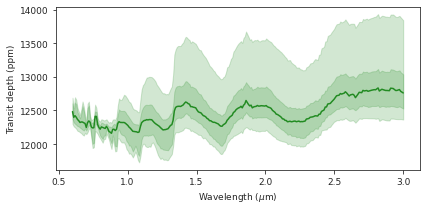

In [19]:
# Plot TESS retrieval:
plt.figure(figsize=(6,3))
#plt.errorbar(wavelengths, depths*1e6, errors*1e6, fmt = '.', elinewidth=1, ecolor='black', mfc='black', mec='black', zorder = 3)
plt.plot(wavelengths_model, median_model*1e6, color = 'ForestGreen', zorder = 2)
plt.fill_between(wavelengths_model, lower68*1e6, upper68*1e6, color = 'ForestGreen', alpha = 0.2)
plt.fill_between(wavelengths_model, lower95*1e6, upper95*1e6, color = 'ForestGreen', alpha = 0.2)
#plt.ylim(9800,11000)
#plt.xlim(np.min(wavelengths_model), 3.0)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (ppm)')
plt.tight_layout()
plt.show()
#plt.savefig('retrieval_tess-limbs-cov_wasp62.pdf')

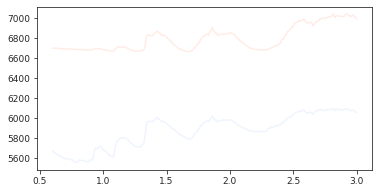

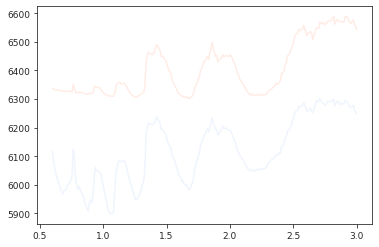

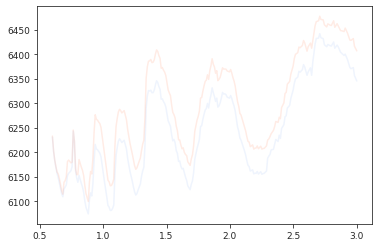

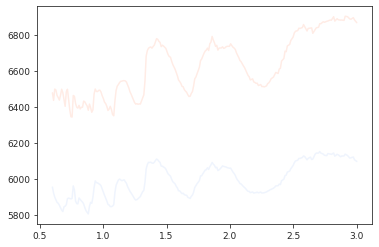

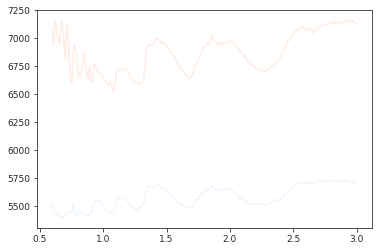

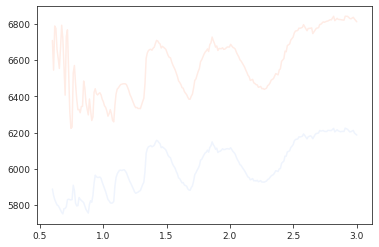

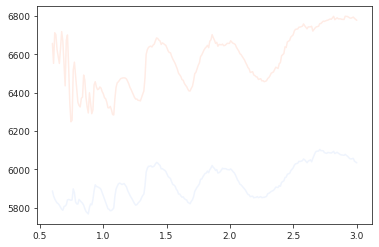

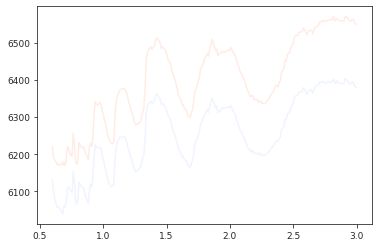

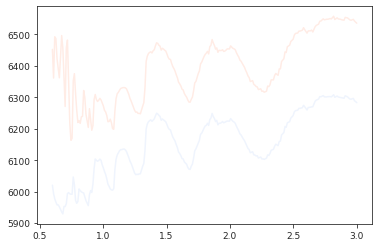

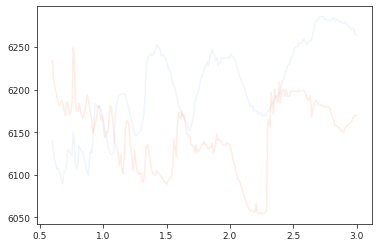

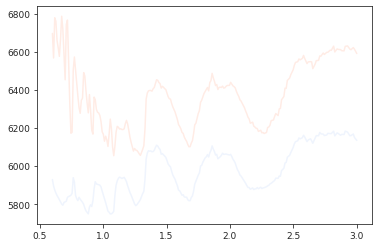

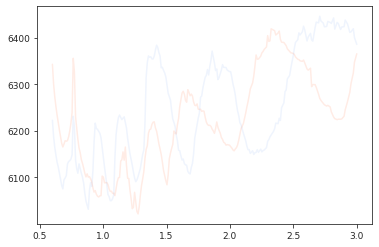

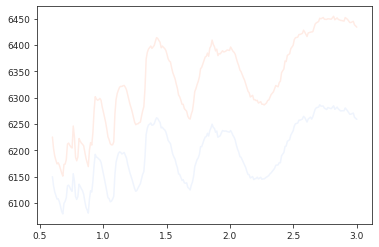

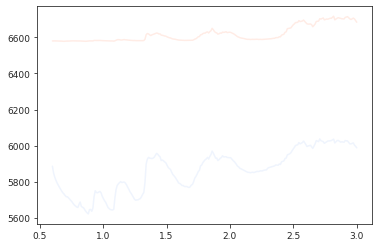

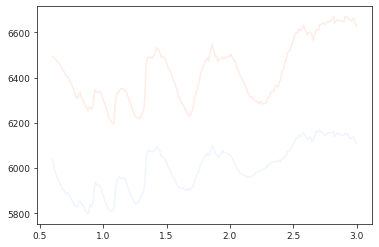

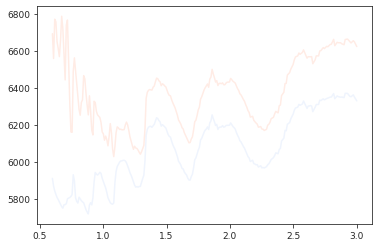

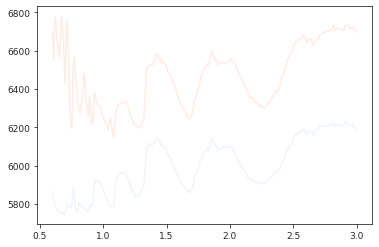

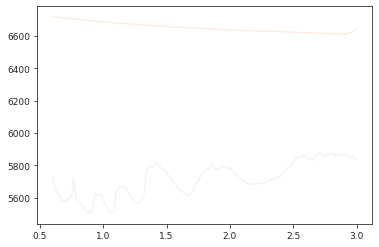

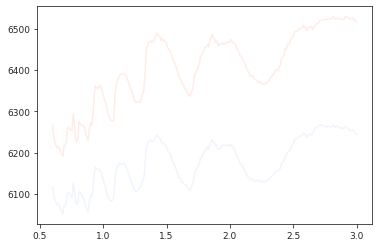

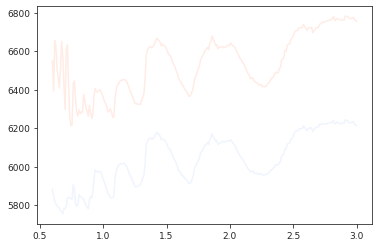

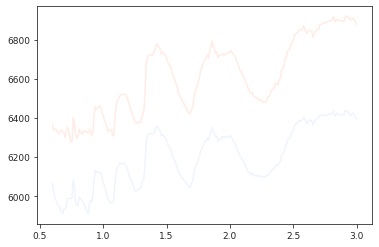

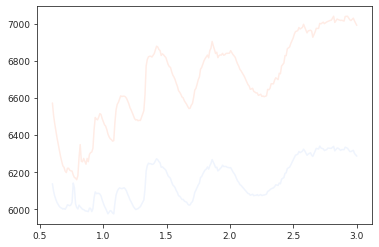

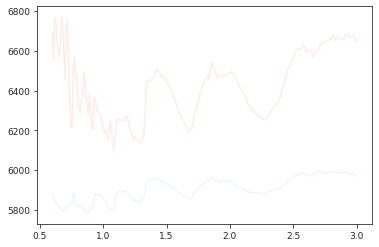

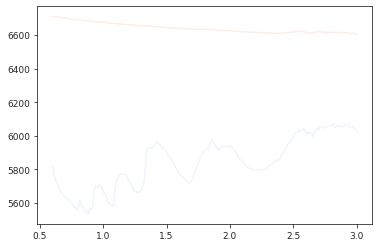

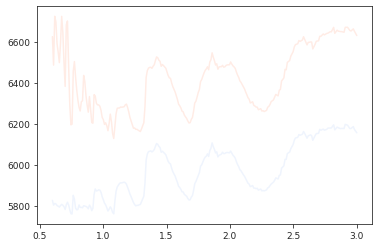

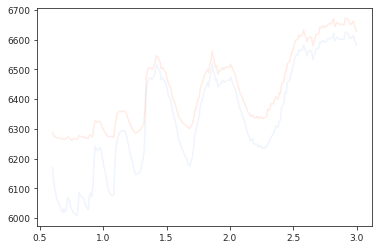

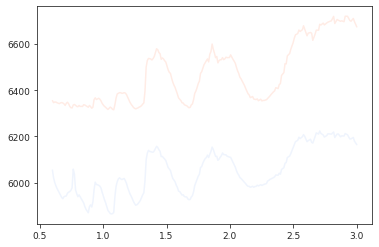

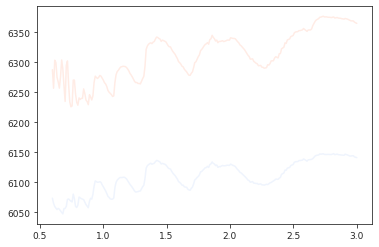

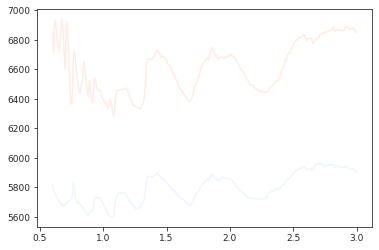

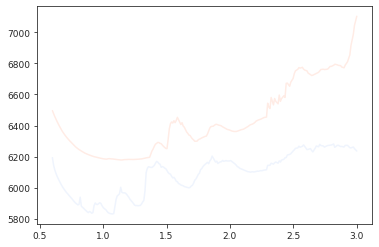

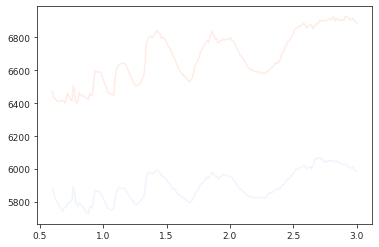

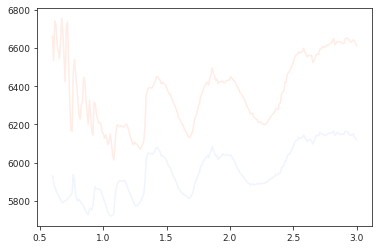

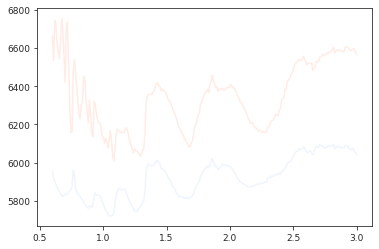

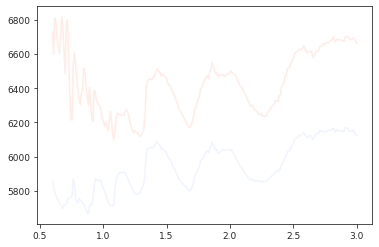

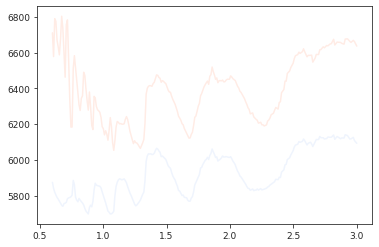

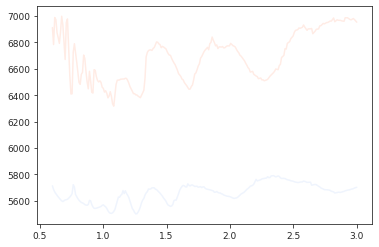

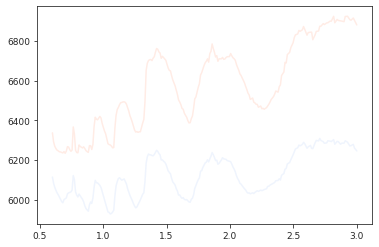

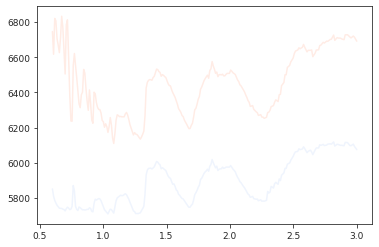

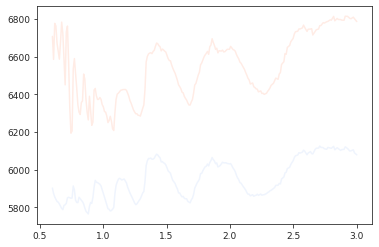

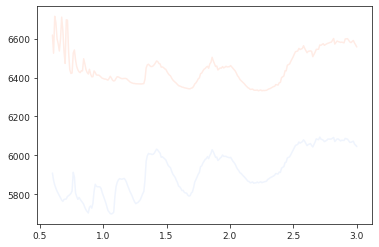

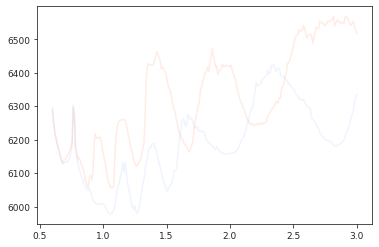

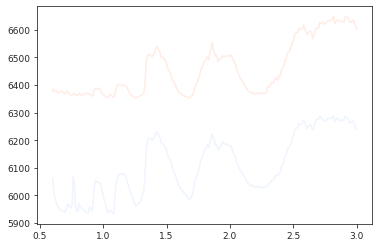

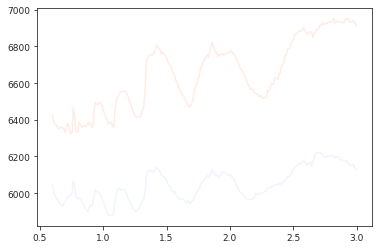

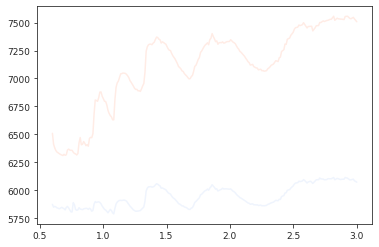

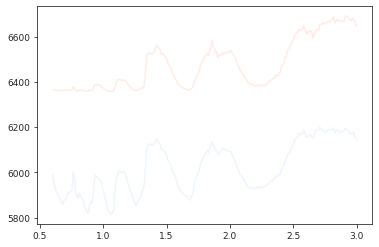

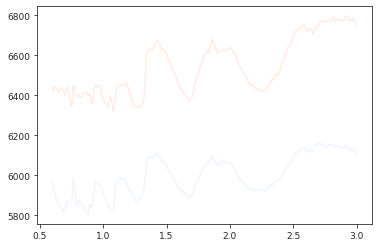

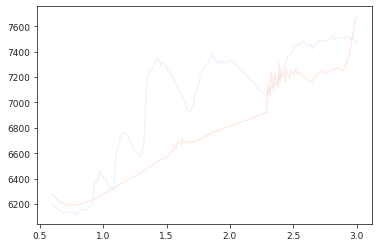

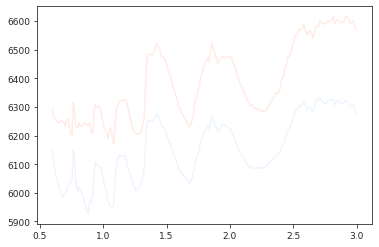

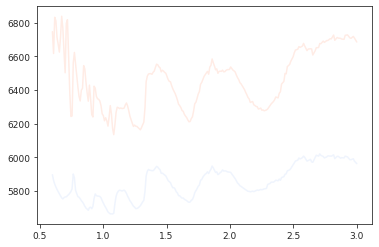

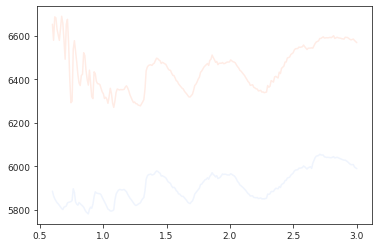

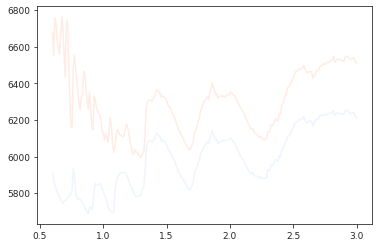

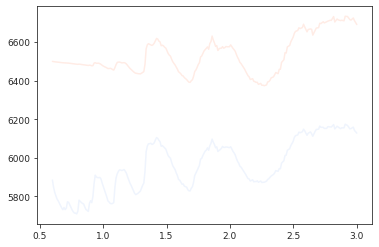

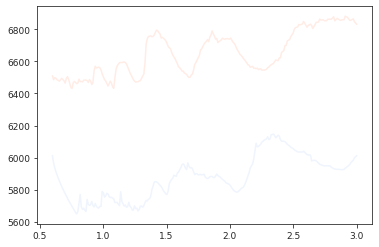

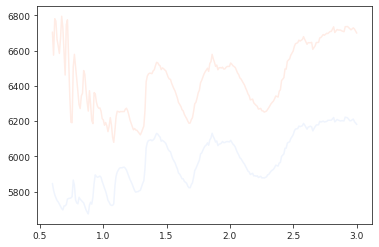

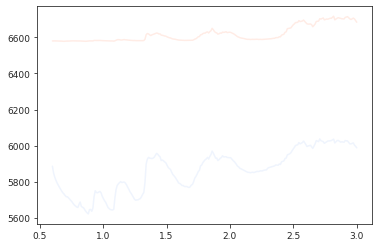

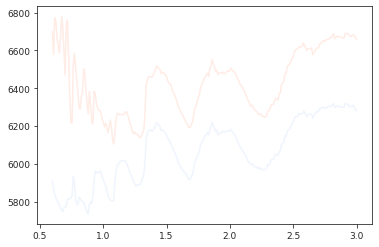

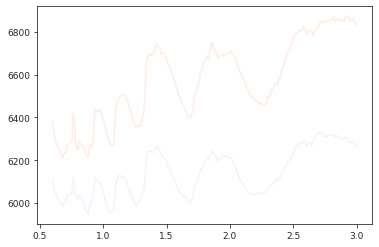

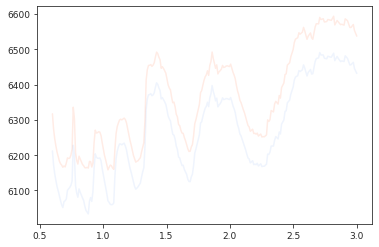

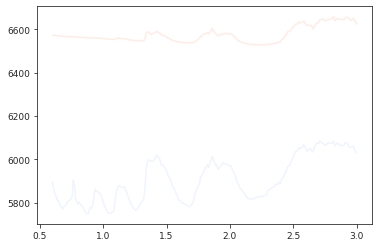

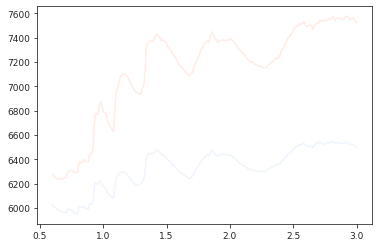

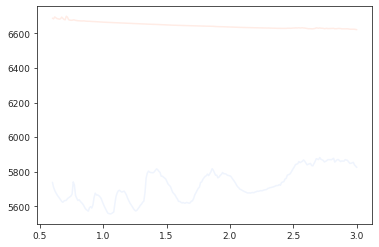

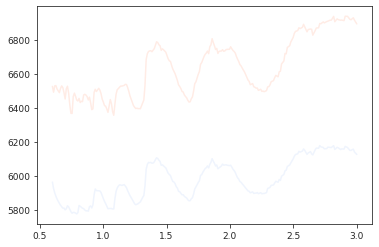

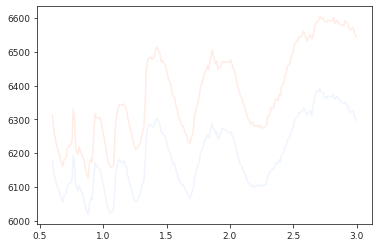

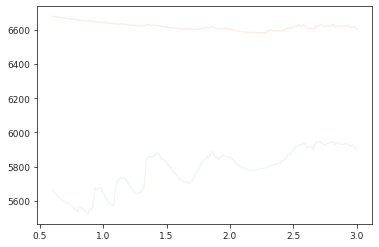

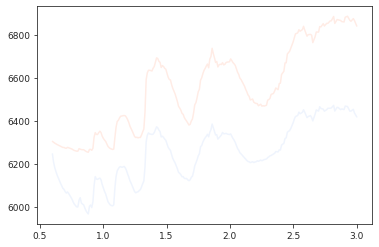

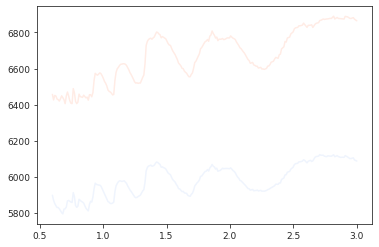

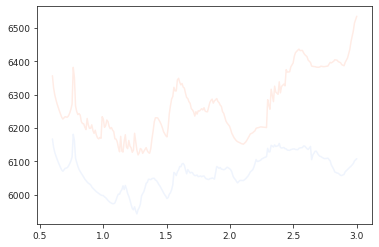

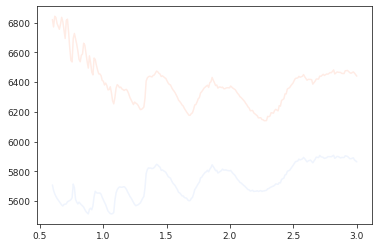

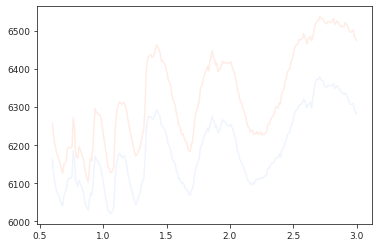

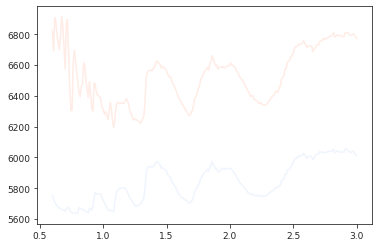

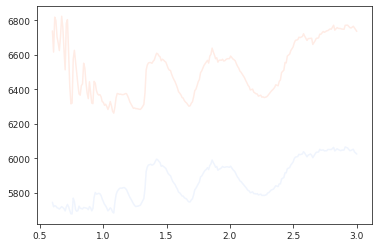

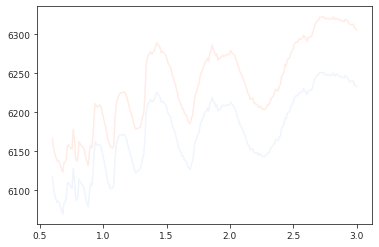

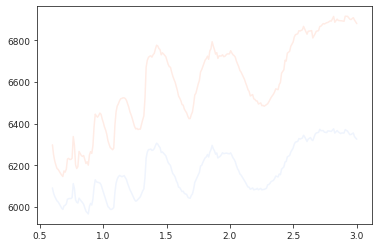

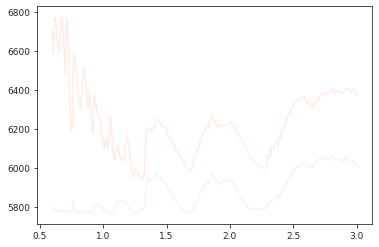

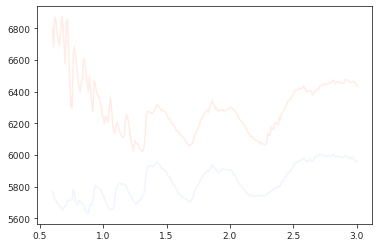

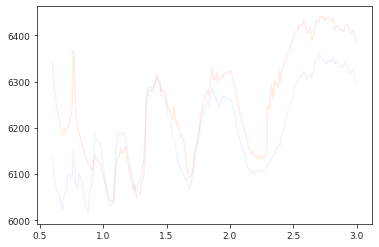

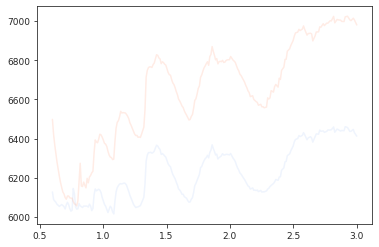

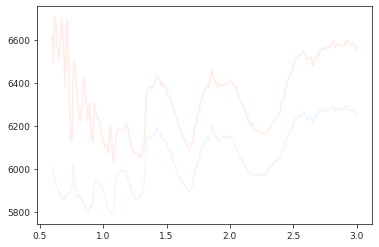

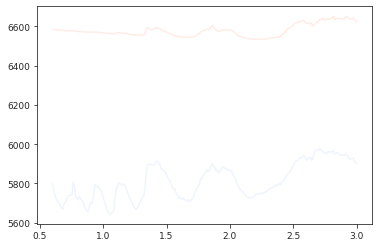

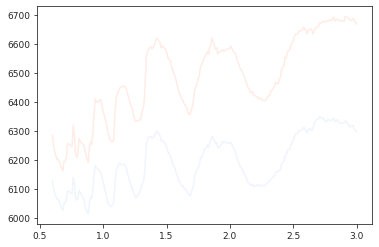

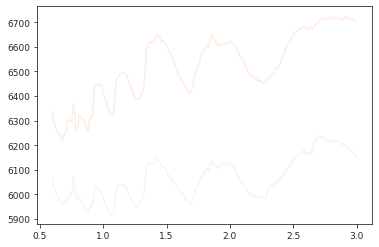

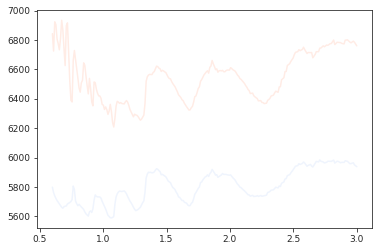

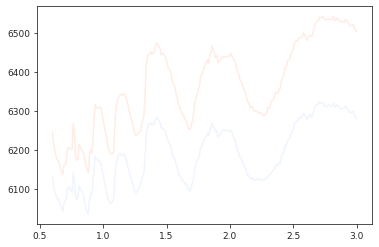

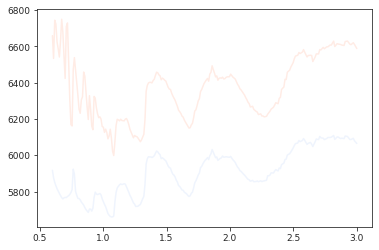

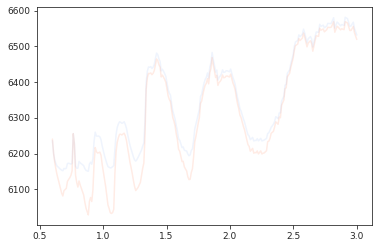

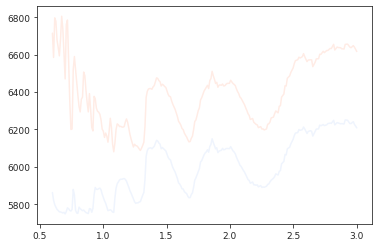

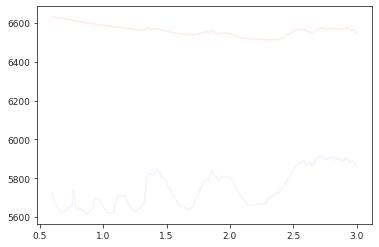

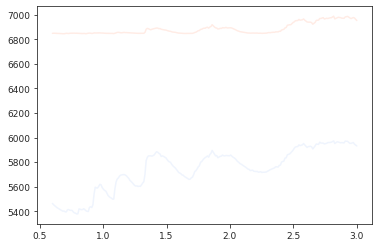

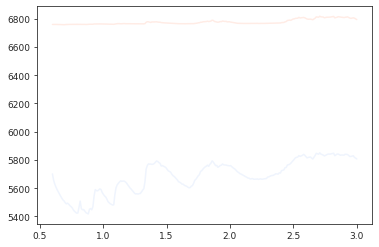

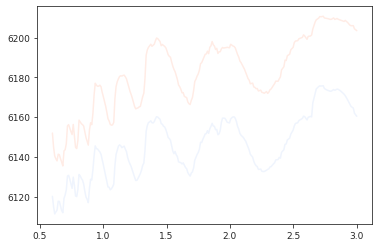

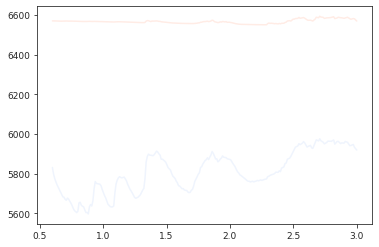

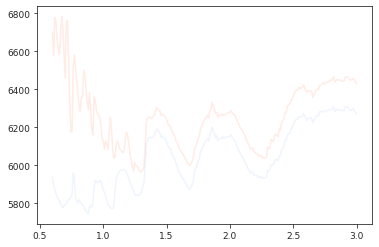

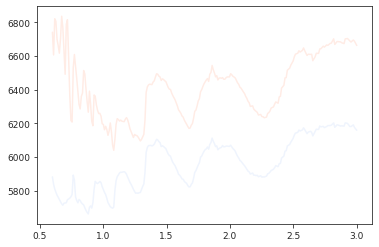

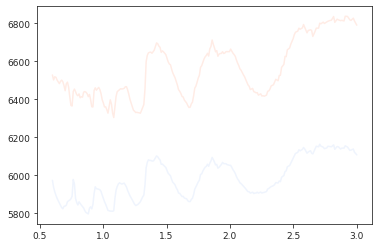

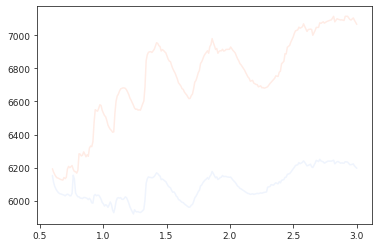

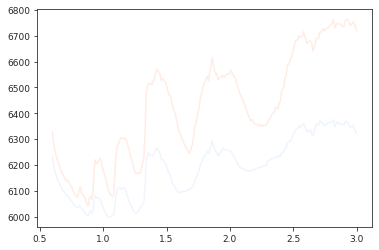

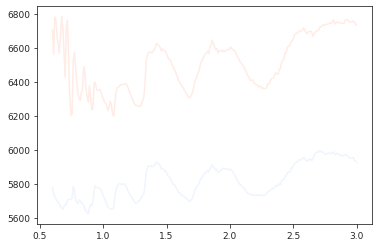

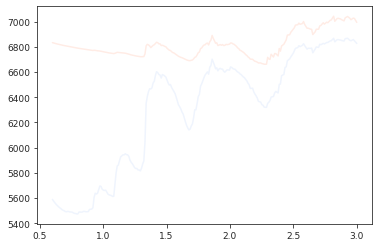

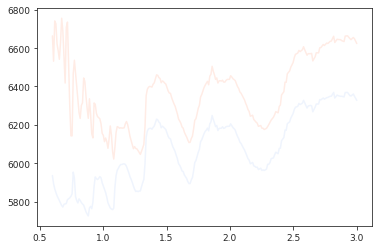

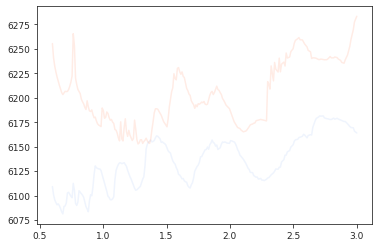

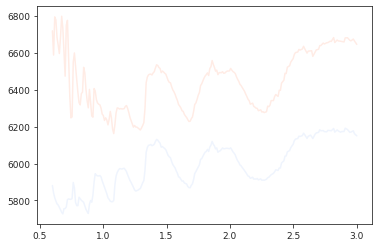

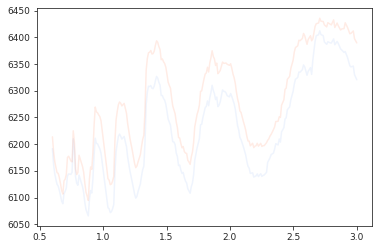

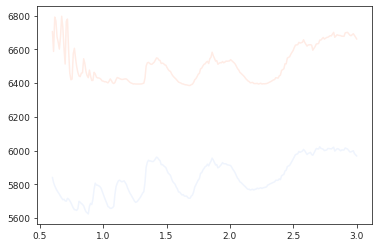

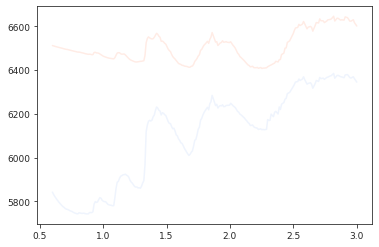

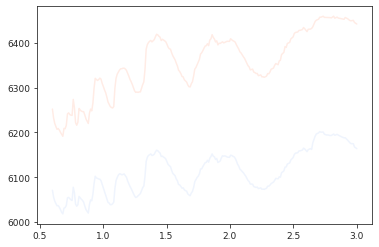

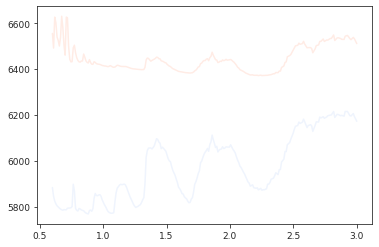

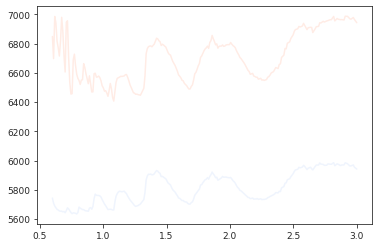

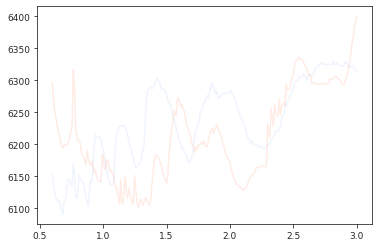

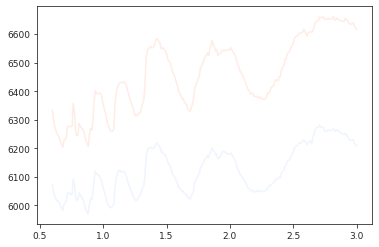

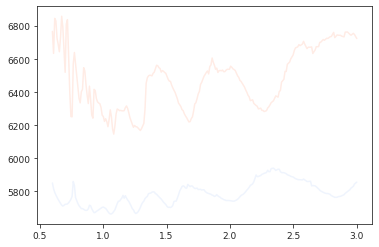

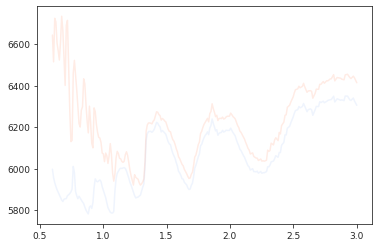

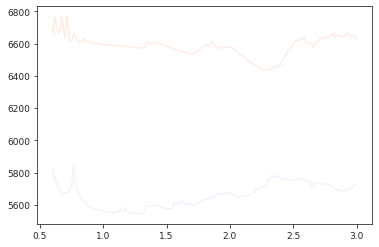

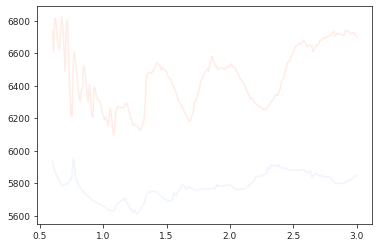

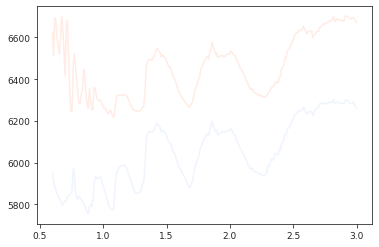

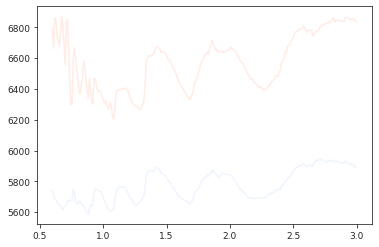

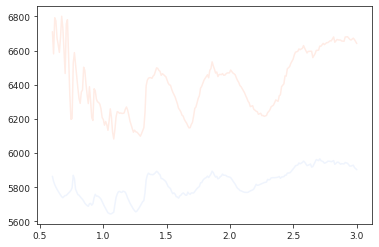

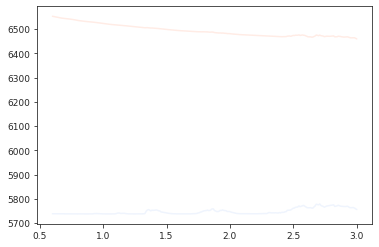

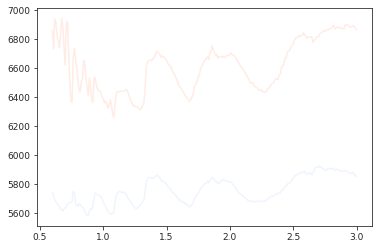

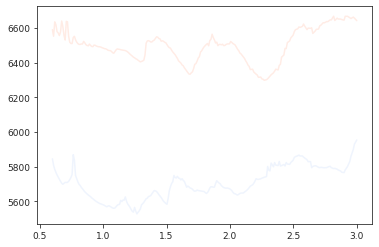

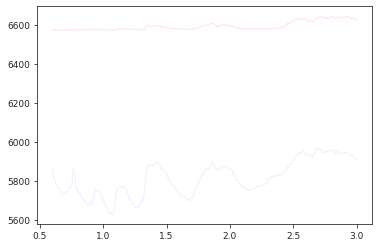

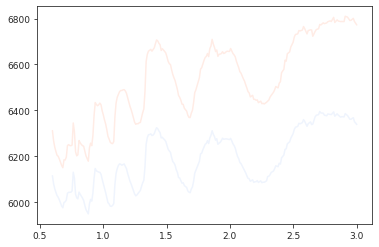

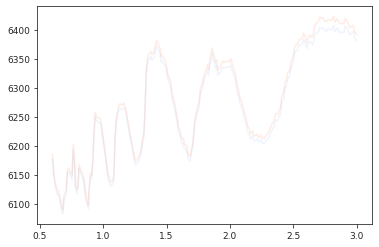

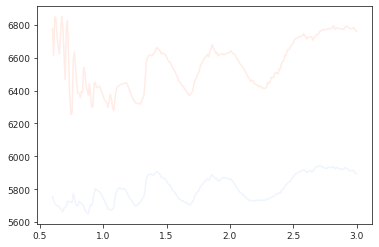

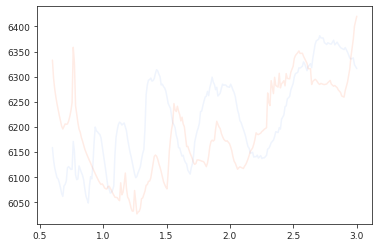

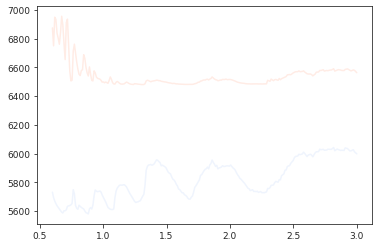

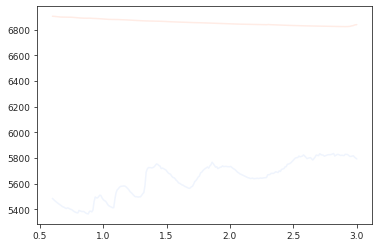

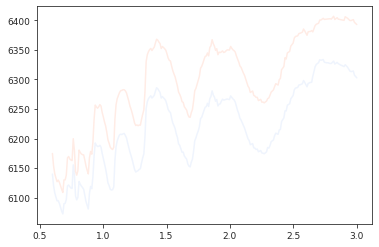

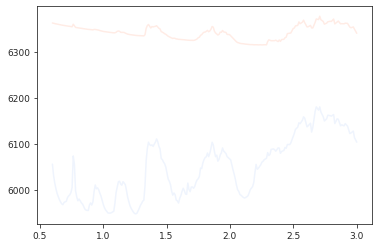

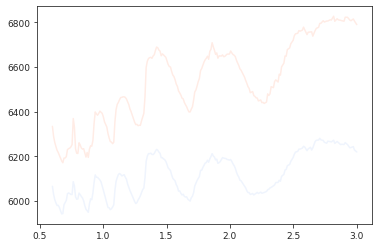

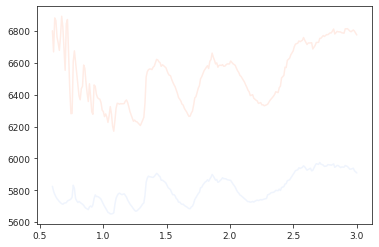

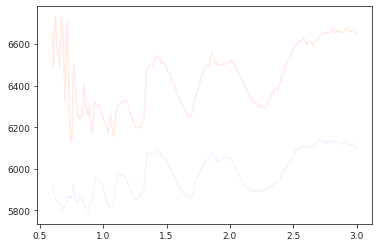

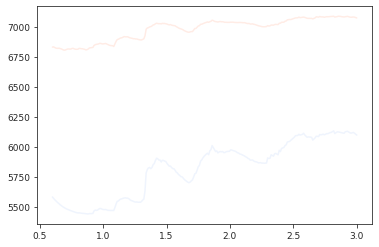

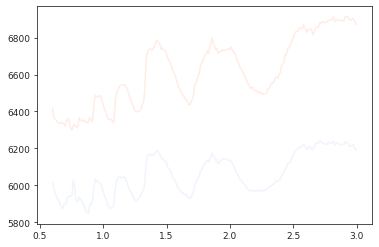

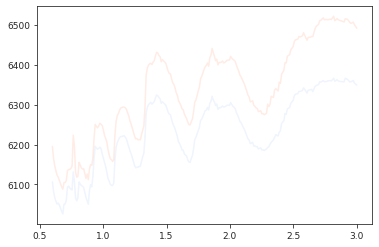

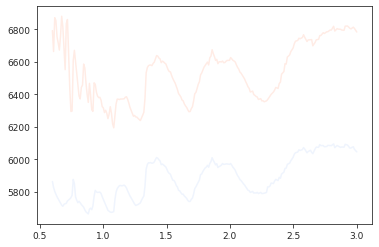

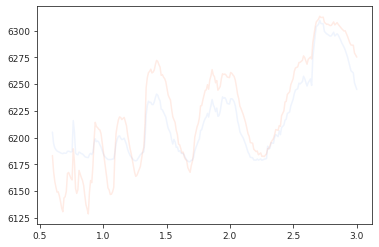

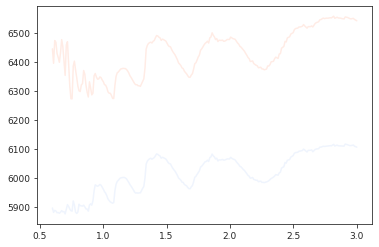

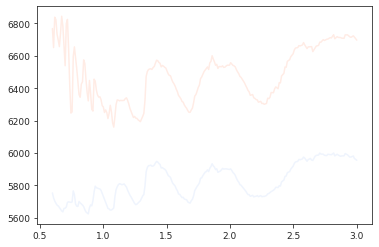

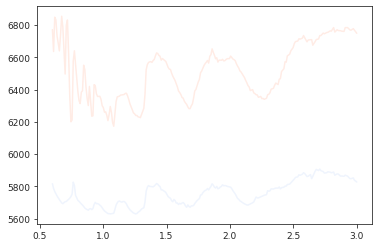

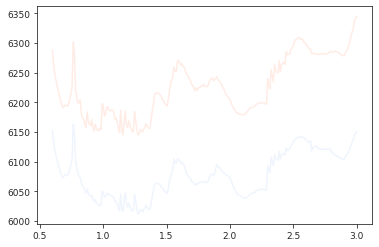

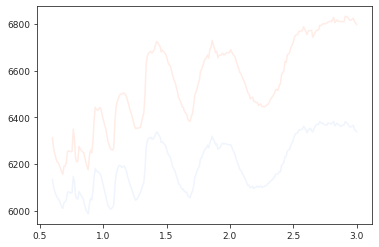

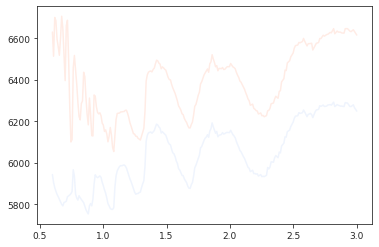

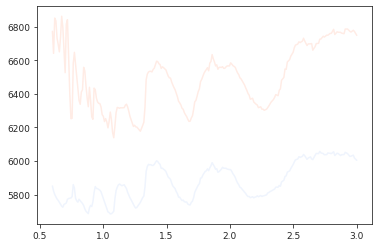

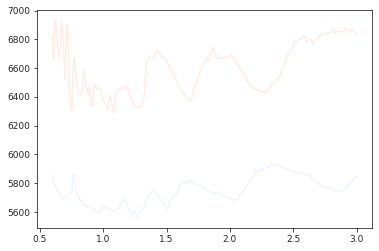

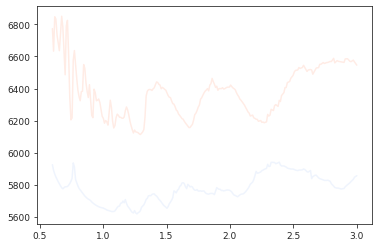

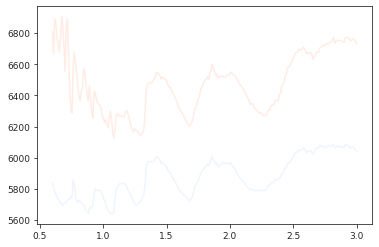

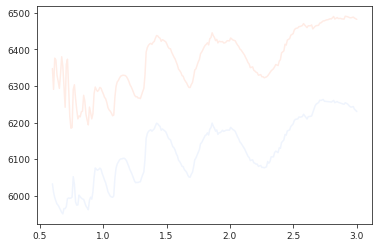

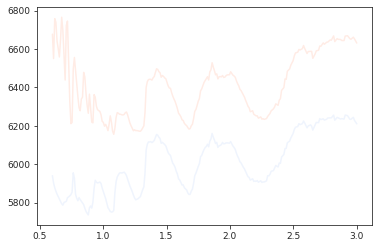

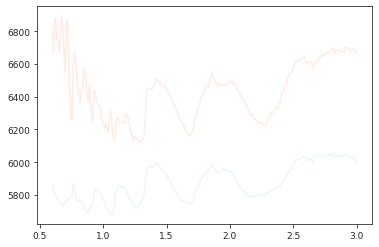

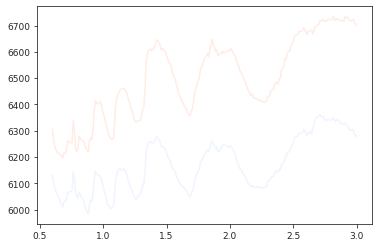

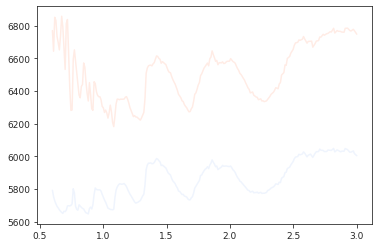

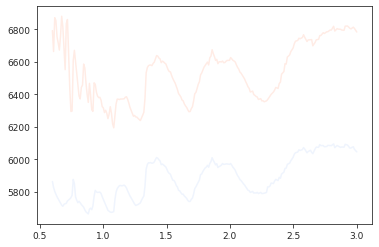

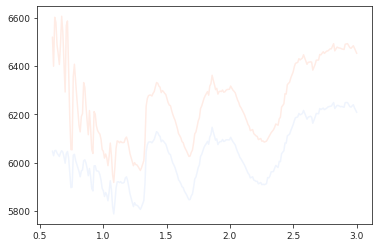

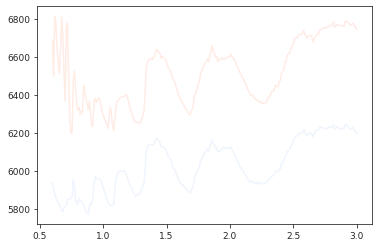

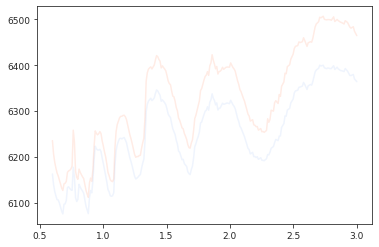

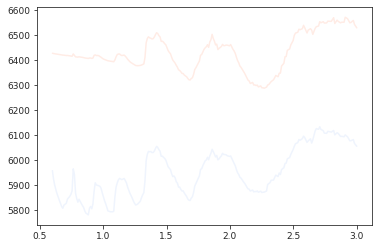

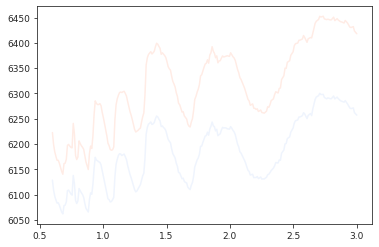

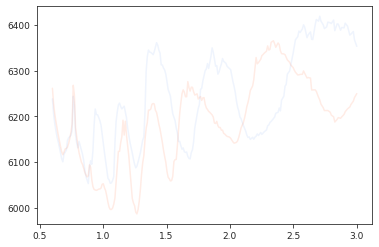

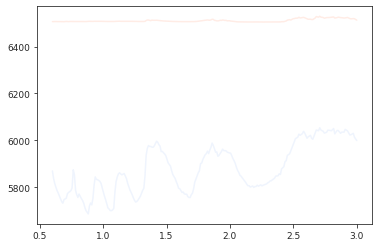

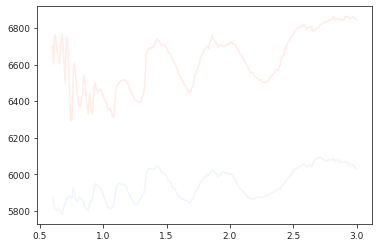

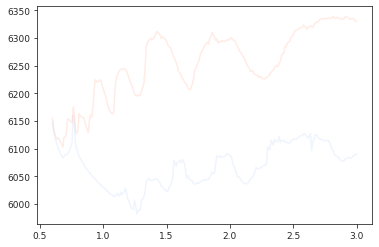

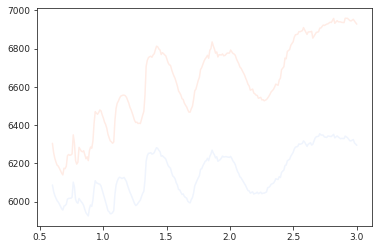

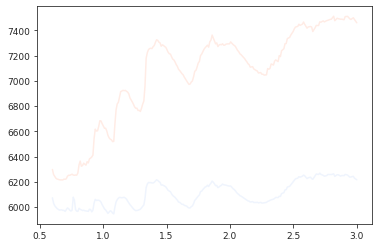

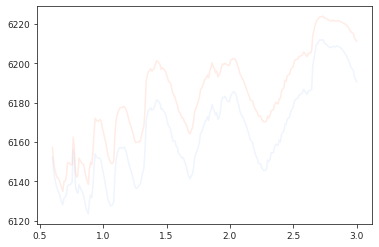

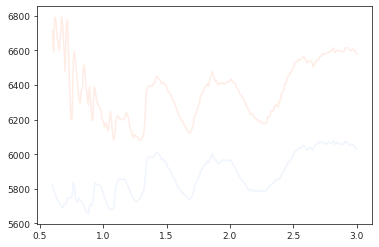

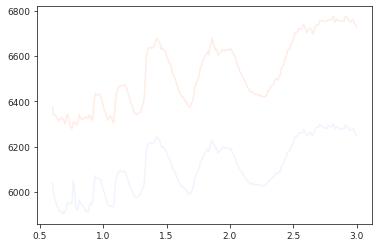

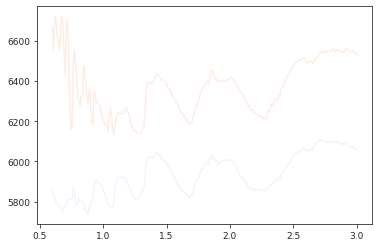

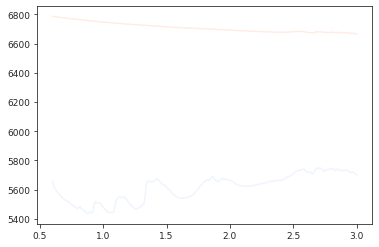

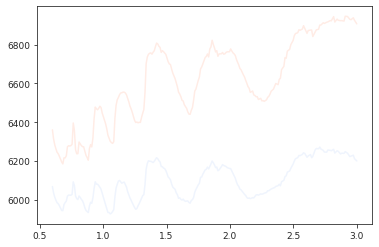

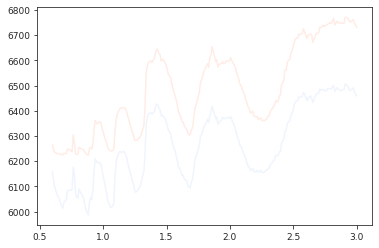

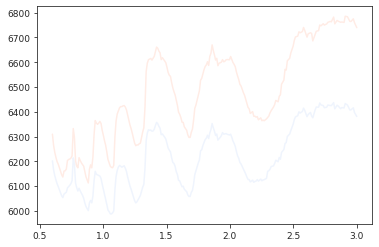

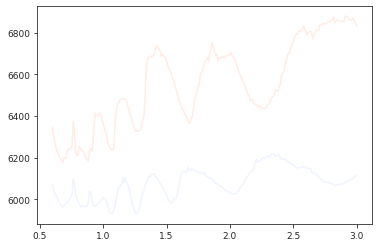

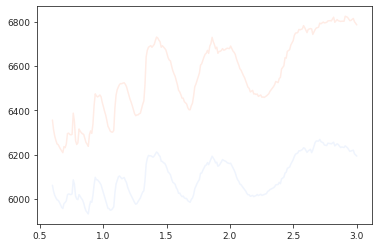

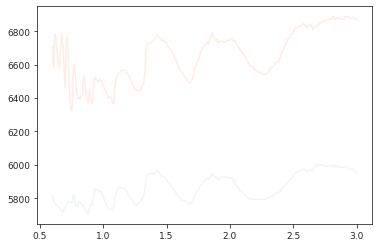

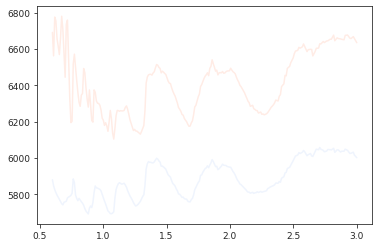

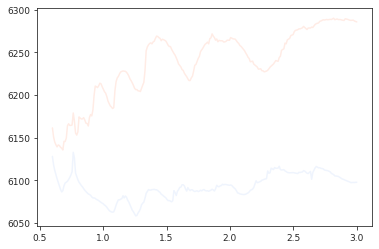

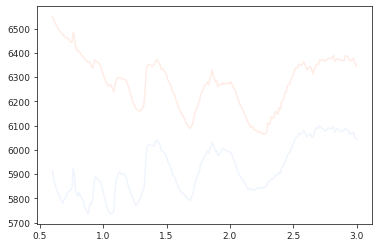

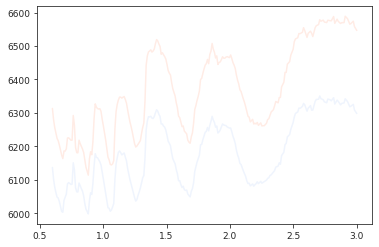

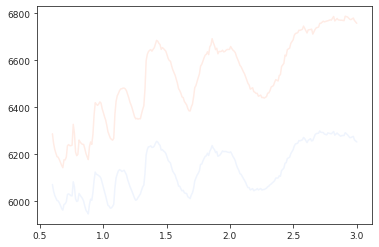

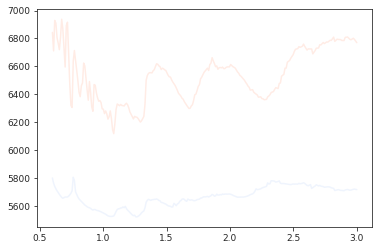

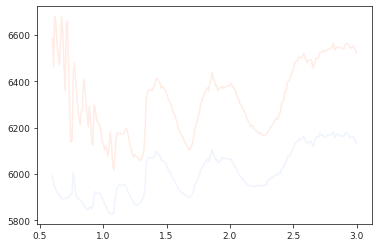

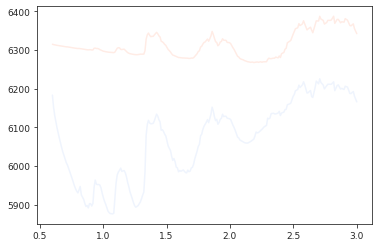

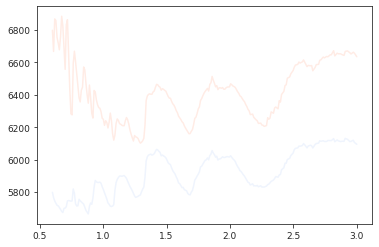

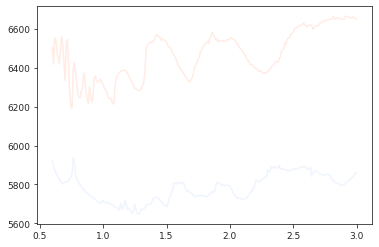

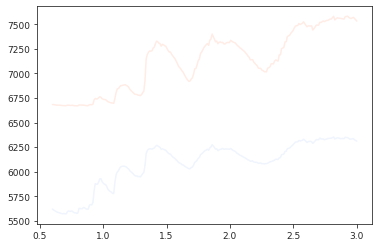

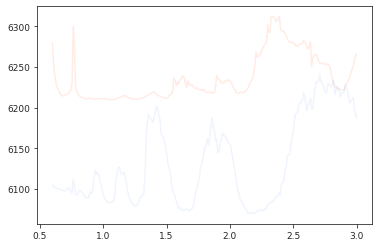

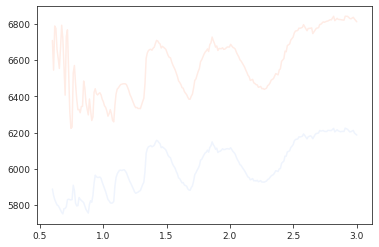

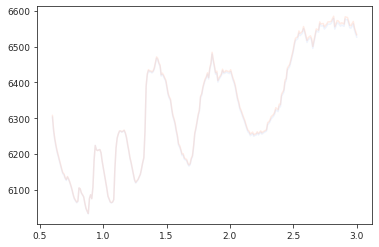

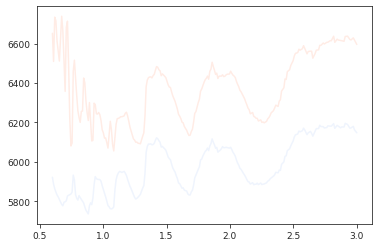

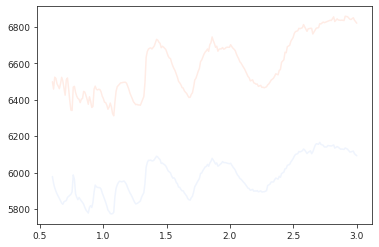

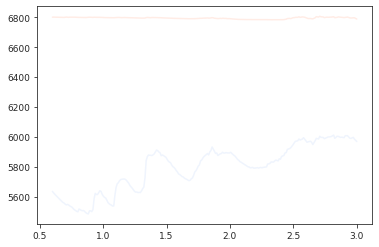

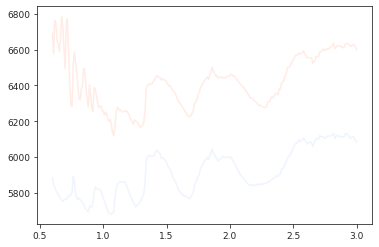

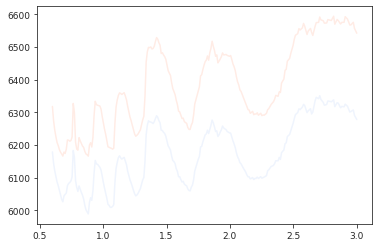

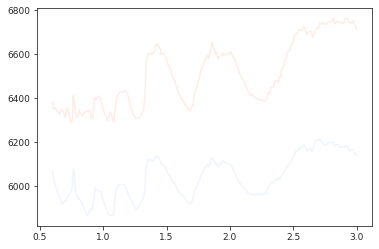

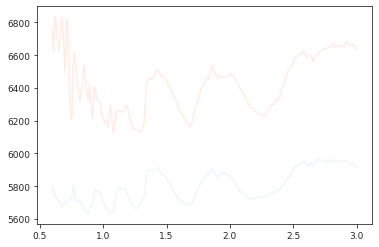

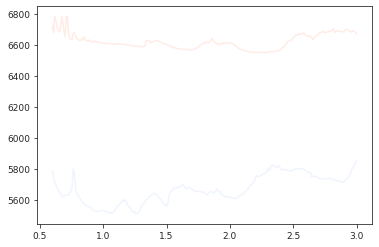

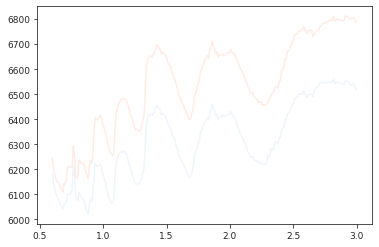

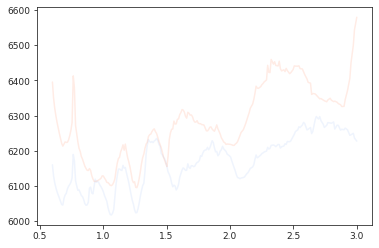

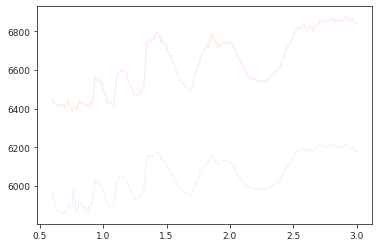

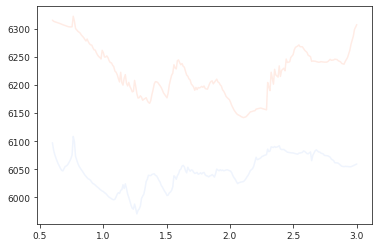

In [20]:
plt.figure(figsize=(6,3))
for i in range(model_samples.shape[0]):
    plt.plot(wavelengths_model, depth1_samples[i,:]*1e6, alpha=0.1, color = 'cornflowerblue')
    plt.plot(wavelengths_model, depth2_samples[i,:]*1e6, alpha=0.1, color = 'orangered')
    plt.show()

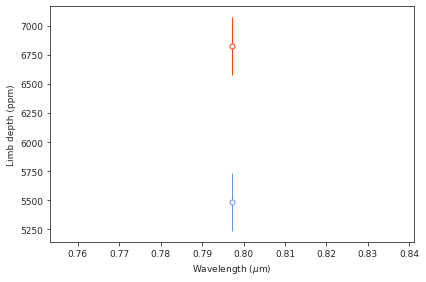

In [21]:
# Plot data:
plt.errorbar(wavelengths, depths_cl, errors_cl, fmt = 'o', elinewidth=1, ecolor='cornflowerblue', mfc='white', \
             mec='cornflowerblue', zorder = 3)

plt.errorbar(wavelengths, depths_hl, errors_hl, fmt = 'o', elinewidth=1, ecolor='orangered', mfc='white', \
             mec='orangered', zorder = 3)

#plt.ylim(9800,11000)
#plt.xlim(np.min(wavelengths_model), 3.0)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Limb depth (ppm)')
plt.tight_layout()
#plt.ylim(4900,5600)
plt.show()
#plt.savefig('tess_limb_constraint-limbs-cov_wasp62.pdf')

# Vertical Mixing Ratios

In [36]:
pic=pickle.load(open('/user/lmiller/CHIMERA_results/OUTPUT_Lauren_new/wasp62_tess_cc_two-limbs-cov_new.pic','rb'), \
                encoding='latin1')

In [37]:
samples=pic[:,:-1]

In [38]:
#unpacking parameters to retrieve
Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1 =  np.median(samples[:,[0]]),np.median(samples[:,[1]]),np.median(samples[:,[2]]),np.median(samples[:,[3]]),np.median(samples[:,[4]]),np.median(samples[:,[5]]),np.median(samples[:,[6]]),np.median(samples[:,[7]]), np.median(samples[:,[8]]), np.median(samples[:,[9]])

Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2 = np.median(samples[:,[10]]), np.median(samples[:,[11]]), np.median(samples[:,[12]]), np.median(samples[:,[13]]), np.median(samples[:,[14]]), np.median(samples[:,[15]])

print('Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1:')
print(Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1)
print('Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2:')
print(Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2)

Tirr, logMet, logCtoO, logKzz, fsed ,logPbase,logCldVMR,xRp, logKir, logg1:
1276.022258217734 0.41615634350977504 -0.7647654578201982 7.933984541632844 3.3344024949509983 -2.1172543485523727 -9.14588322183258 0.8911870746585299 -1.3620949140905783 -1.2617950963370643
Tirr2, logCtoO2, logKzz2, fsed2 ,logPbase2,logCldVMR2:
1839.963688418813 -0.8422384861983732 8.170993224412793 3.1783657128157676 -2.4284160526834304 -7.468522514684898


In [39]:
wavelengths= np.linspace(0.6, 3.0, 264) 

In [40]:
wlgrid = wavelengths

Rp = 1.390 #Stassun et al. 2017, Exoplanet Archive #0.930#*x[4]# Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar = 1.2142700 #TICv8, Exoplanet Archive #0.598   #Stellar Radius in Solar Radii
M = 0.52 #Stassun et al. 2017, Exoplanet Archive #1.78    #Mass in Jupiter Masses

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
#Tirr= 2091 #1500#x[0]#544.54 #terminator **isothermal** temperature--if full redistribution this is equilibrium temp
#logKir= -1.5  #TP profile IR opacity controlls the "vertical" location of the gradient
#logg1= -0.7     #single channel Vis/IR opacity. Controls the delta T between deep T and TOA T
Tint= 200.

#Composition parameters---assumes "chemically consistnat model" described in Kreidberg et al. 2015
#logMet= 0.0 #x[1]#1.5742E-2 #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1 used -1.01*log10(M)+0.6
#logCtoO= -0.26#x[2]#-1.97  #log C-to-O ratio: log solar is -0.26
logPQCarbon = -5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value
logPQNitrogen = -5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  --ad hoc for chemical kinetics--reasonable assumption

#A&M Cloud parameters--includes full multiple scattering (for realzz) in both reflected and emitted light
#logKzz=7 #log Rayleigh Haze Amplitude (relative to H2)
#fsed=3.0 #haze slope--4 is Rayeigh, 0 is "gray" or flat.  
#logPbase=-1.0  #gray "large particle" cloud opacity (-35 - -25)
#logCldVMR=-25.0 #cloud fraction

#simple 'grey+rayleigh' parameters--non scattering--just pure extinction
logKcld = -40
logRayAmp = -30
RaySlope = 0

In [41]:
xsects=xsects_HST(1500,27900)

Cross-sections Loaded


In [42]:
##all values required by forward model go here--even if they are fixed. First, one hemisphere:
x=np.array([Tirr, logKir,logg1, Tint,logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free
#wlgrid_fake=np.append(wlgrid,np.array([0.9,1.0,1.2]))
y_binned,y_mod,wno,atm = fx_trans(x,wlgrid,gas_scale,xsects)

<IPython.core.display.Javascript object>


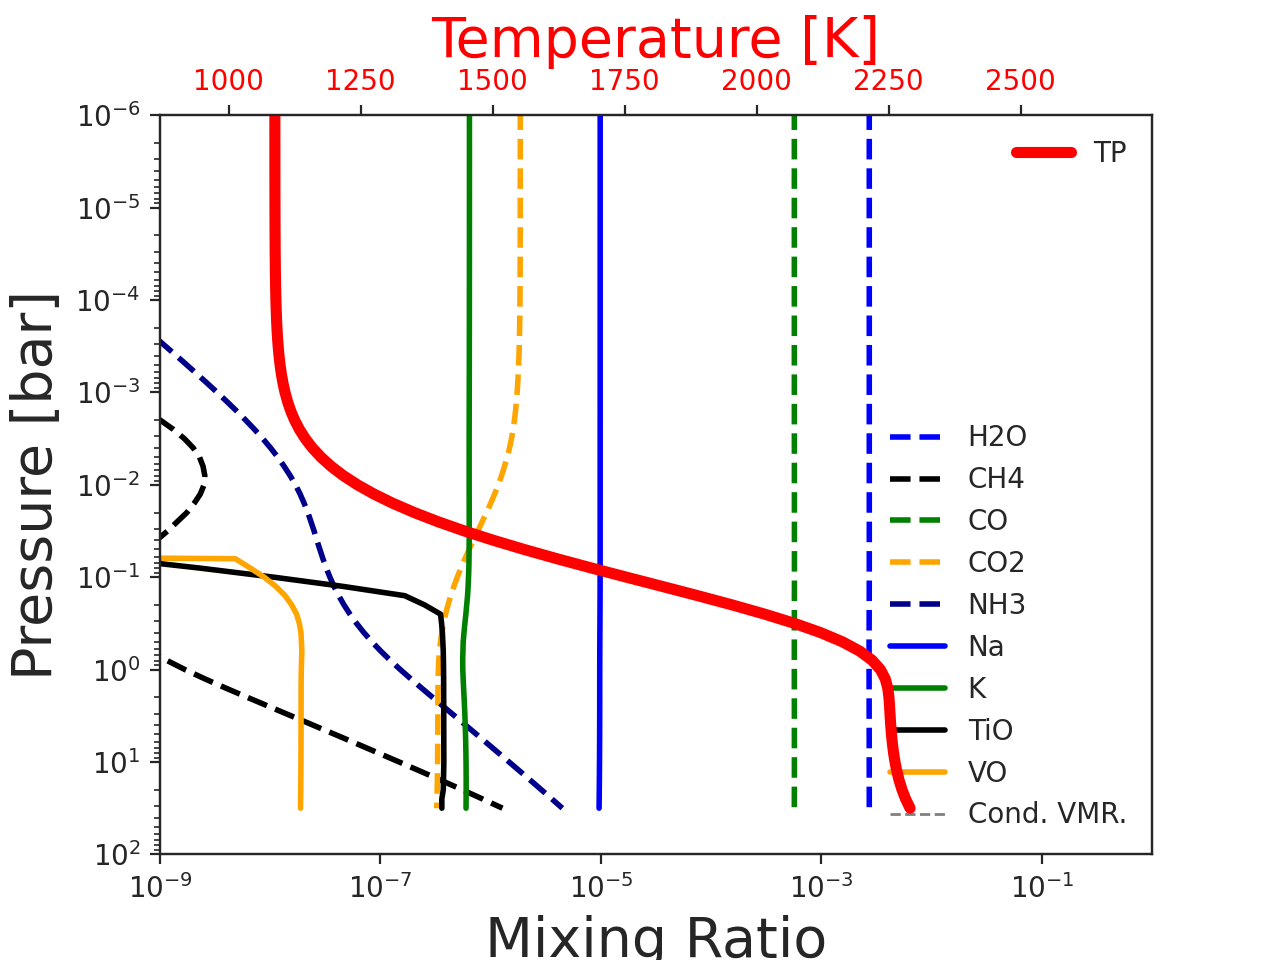

In [43]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter
%matplotlib notebook

#unpacking variables
#P is in bars
#T is in K
#H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He are gas mixing ratio profiles
#qc is the condensate abundance profile given an "f_sed" value and cloud base pressure
#r_eff is the effective cloud droplet radius given (see A&M 2001 or Charnay et al. 2017)
#f_r is the mixing ratio array for each of the cloud droplet sizes.
P,T, H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He,H,e, Hm,qc,r_eff,f_r=atm


fig2, ax1=subplots()
#feel free to plot whatever you want here....
ax1.semilogx(H2O,P,'b',ls='--',lw=2,label='H2O')
ax1.semilogx(CH4,P,'black',ls='--',lw=2,label='CH4')
ax1.semilogx(CO,P,'g',ls='--',lw=2,label='CO')
ax1.semilogx(CO2,P,'orange',ls='--',lw=2,label='CO2')
ax1.semilogx(NH3,P,'darkblue',ls='--',lw=2,label='NH3')
ax1.semilogx(Na,P,'b',lw=2,label='Na')
ax1.semilogx(K,P,'g',lw=2,label='K')
ax1.semilogx(TiO,P,'k',lw=2,label='TiO')
ax1.semilogx(VO,P,'orange',lw=2,label='VO')
ax1.semilogx(qc,P,'gray',lw=1,ls='--',label='Cond. VMR.')

ax1.set_xlabel('Mixing Ratio',fontsize=20)
ax1.set_ylabel('Pressure [bar]',fontsize=20)
ax1.semilogy()
ax1.legend(loc=4,frameon=False)
ax1.axis([1E-9,1,100,1E-7])

#plotting TP profile on other x-axis
ax2=ax1.twiny()
ax2.semilogy(T,P,'r-',lw='4',label='TP')
ax2.set_xlabel('Temperature [K]',color='r',fontsize=20)
ax2.axis([0.8*T.min(),1.2*T.max(),100,1E-6])
for tl in ax2.get_xticklabels(): tl.set_color('r')
ax2.legend(loc=1,frameon=False)

show()

In [44]:
x2=np.array([Tirr2, logKir,logg1, Tint,logMet, logCtoO2, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz2, fsed2,logPbase2,logCldVMR2, logKcld, logRayAmp, RaySlope])
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.])
#print(wlgrid)
y_binned,y_mod,wno,atm = fx_trans(x2,wlgrid,gas_scale,xsects)

<IPython.core.display.Javascript object>


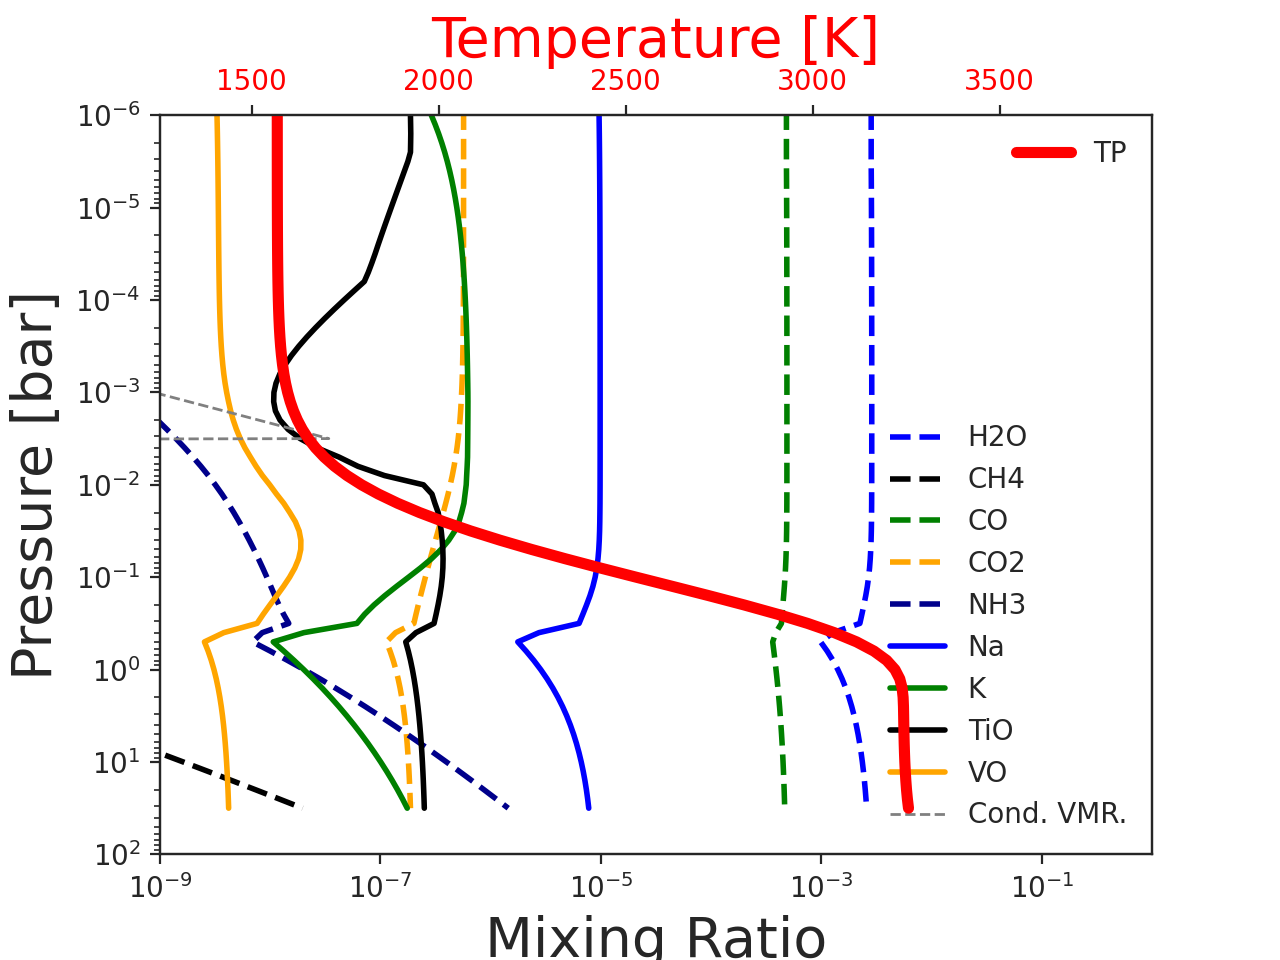

In [45]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter
%matplotlib notebook

#unpacking variables
#P is in bars
#T is in K
#H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He are gas mixing ratio profiles
#qc is the condensate abundance profile given an "f_sed" value and cloud base pressure
#r_eff is the effective cloud droplet radius given (see A&M 2001 or Charnay et al. 2017)
#f_r is the mixing ratio array for each of the cloud droplet sizes.
P,T, H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He,H,e, Hm,qc,r_eff,f_r=atm


fig2, ax1=subplots()
#feel free to plot whatever you want here....
ax1.semilogx(H2O,P,'b',ls='--',lw=2,label='H2O')
ax1.semilogx(CH4,P,'black',ls='--',lw=2,label='CH4')
ax1.semilogx(CO,P,'g',ls='--',lw=2,label='CO')
ax1.semilogx(CO2,P,'orange',ls='--',lw=2,label='CO2')
ax1.semilogx(NH3,P,'darkblue',ls='--',lw=2,label='NH3')
ax1.semilogx(Na,P,'b',lw=2,label='Na')
ax1.semilogx(K,P,'g',lw=2,label='K')
ax1.semilogx(TiO,P,'k',lw=2,label='TiO')
ax1.semilogx(VO,P,'orange',lw=2,label='VO')
ax1.semilogx(qc,P,'gray',lw=1,ls='--',label='Cond. VMR.')

ax1.set_xlabel('Mixing Ratio',fontsize=20)
ax1.set_ylabel('Pressure [bar]',fontsize=20)
ax1.semilogy()
ax1.legend(loc=4,frameon=False)
ax1.axis([1E-9,1,100,1E-7])

#plotting TP profile on other x-axis
ax2=ax1.twiny()
ax2.semilogy(T,P,'r-',lw='4',label='TP')
ax2.set_xlabel('Temperature [K]',color='r',fontsize=20)
ax2.axis([0.8*T.min(),1.2*T.max(),100,1E-6])
for tl in ax2.get_xticklabels(): tl.set_color('r')
ax2.legend(loc=1,frameon=False)

show()